Выполнил: Кагарманов Эрик  
Data scientist 
mail: kagarmanov.science@gmail.com  
telegram: https://t.me/erikkagarmanov  

# Описание задачи

Часть 1: Предварительная обработка данных
Необходимо рассчитать пиковые часы, используя данные о фактическом потреблении электроэнергии и интервалы из документа «Плановые часы пиковой нагрузки на 2021 год для территорий, отнесенных к ценовым зонам оптового рынка».
Для этого следует вычислить максимальное значение фактического потребления электроэнергии для каждого дня внутри диапазона, доступного в документе «Плановые часы пиковой нагрузки на 2021 год для территорий, отнесенных к ценовым зонам оптового рынка».
Таким образом, час пиковой нагрузки это:
1)	Час с наибольшим значением фактического потребления энергии в течение дня
2)	Находящийся в часовом диапазоне для ценовой зоны, соответствующем моделируемому региону

Часть 2: Эталонная модель  
Эталонная модель – способ прогнозирования, при котором в качестве прогноза для пиковых часов используются наиболее часто встречающиеся значения соответствующего месяца прошлого года, объединенные в 4-часовой диапазон.
Для построения эталонной модели необходимо:
1)	Вычислить статистику по пиковым часам за предыдущий год (доля значений пиковых часов за весь месяц, соответствующих каждому часу с 0-го по 23-й)
2)	Определить 4-часовой диапазон для месяца, для которого сумма долей максимальна
3)	Если пиковое значение попадает на единственный час, то для диапазона необходимо брать значения, предшествующие ему.
4)	Использовать данный диапазон для прогнозирования значений за соответствующие месяцы 2022 г.

Часть 3: Моделирование и прогнозирование часов пиковой нагрузки  
Необходимо предложить модель, способную спрогнозировать час пиковой нагрузки, а также диапазон из 4-х последовательно расположенных часов.
Прогноз необходимо построить в дневной динамике на месяц вперед.
Для оценки качества построенной модели предлагается осуществить ретропрогноз на май, июнь, июль, август, сентябрь и октябрь 2022 года.
Для этого необходимо рассчитать прогноз для рассматриваемого месяца оценив модель на данных до него.
Прогноз считается точным, если фактическое значение часа пиковой нагрузки совпало с одним из четырех подряд идущих часов из прогнозируемого диапазона (прогнозируемый час пиковой нагрузки + 3 соседних часа).

Описание признаков:  
P1	- Плановый объем производства (по типам станций), МВт.ч. ТЭС	  
P2	- Суммарные величины технического минимума  (по типам станций), МВт.ч. ТЭС	  
P3	- Суммарные величины технологического минимума  (по типам станций), МВт.ч. ТЭС	  
P4	- Суммарные величины технического максимума  (по типам станций), МВт.ч. ТЭС	  
P5	- Плановый объём потребления, МВт.ч.	  
P6	- Полный плановый объем потребления, МВт.ч.	  
subject -	Регион РФ	  
date -	Дата 	  
energy_consumption - Суммарное фактическое потребление электроэнергии в субъекте РФ  

# Imports

In [1]:
# работа с данными
import numpy as np 
import pandas as pd

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns 

# метрики
from sklearn.metrics import roc_auc_score, f1_score, mean_squared_error, mean_absolute_error

# алгоритмы машинного ообучения
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

# кросс-валидация
from sklearn.model_selection import  cross_validate

# нормализация и предобработка 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# eda
from dataprep import eda

# от предупрежденийPreferences: 
import warnings
warnings.simplefilter("ignore")

# фиксиурем рандом
random_state = 142

# Описание функций

In [5]:
def time_series_cv_indices(df, tick_series, min_tick, max_tick, min_numbers_train_ticks):
    """ Разделение выборки на фолды по time_series тикам """
    cv_indices = []
    ticks = np.arange(min_numbers_train_ticks, max_tick)
    for tick in ticks:
        train_index = df[tick_series.isin(range(min_tick, tick+1))].index
        test_index = df[tick_series == tick+1].index
        cv_indices.append( (train_index, test_index) )
    return cv_indices

def stat_time_series_4hours_window_cv(df, prediction_column, target_column, cv_indices):
    """ Расчёт метрики предсказания статистической модели на фолдах основанных на временных рядах """
    metric_table = pd.DataFrame()
    n = 0
    cv_test = np.array([])
    for train_index, test_index in cv_indices:

        df_valid_test = df.loc[test_index]

        score = np.where(
            (df_valid_test[prediction_column] - 3 <= df_valid_test[target_column]) & (
                df_valid_test[target_column] <= df_valid_test[prediction_column]),
            1,
            0).mean()

        cv_test = np.append(cv_test, score)

        metric_table.loc[n, 'cummulative_average_test_score'] = cv_test.mean()
        metric_table.loc[n, 'tick_test_score'] = score
        metric_table.loc[n, 'cummulative_std'] = cv_test.std()
        
        n += 1 

    return metric_table

def metric_visual(metric_table):
    """ Визуализация результатов тестрования на временных рядах """
    plt.figure(figsize=(12, 6))

    x_ticks = range(metric_table.shape[0])
    for col in metric_table.columns:
        plt.plot(x_ticks, metric_table[col], label = col, marker = 'o')
    plt.xticks(rotation = 45)
    plt.legend()
    plt.title('Средняя целевая метрика = ' + str(np.round(metric_table.iloc[-1, 0], 3)))
    plt.show()

def make_time_series_feats(temp_df, indexes, group_cols, target_cols, pre_name):
    """ Создание признаков на временных рядах для переданной группы объектов """
    for feat in target_cols:
        table = temp_df.groupby(group_cols, as_index = False)[feat].mean()

        for i in [3, 6, 12]:
                table['_'.join([pre_name, feat, 'shift_1', 'mean', str(i)])] = table[feat].rolling(window = i).mean().shift(1)

        for i in [1, 6, 12]:
                table['_'.join([pre_name, feat, 'shift', str(i)])] = table[feat].shift(i)

        table['_'.join([pre_name, feat, 'mean', 'shift_1_diff_2'])] = table[feat].shift(1) - table[feat].shift(2)
        table['_'.join([pre_name, feat, 'mean', 'shift_1_diff_mean3'])] = table[feat].shift(1) - table['_'.join([pre_name, feat, 'shift_1', 'mean', str(3)])].shift(2)                         
        table['_'.join([pre_name, feat, 'mean', 'shift_1_diff_12'])] = table[feat].shift(1) - table[feat].shift(12)

        temp_df = pd.merge(temp_df, table.drop(feat, axis = 1), on = group_cols, how = 'left')
        
    temp_df.index = indexes
    
    return temp_df

def cl_fs(
    cl, cl_helper, X_train, y_train, fs_indices, 
    step, ps, features, cv, table_train, 
    table_test, metric, name
    ):
    """ Итеративный отбор доли лучших признаков и проверка метрики на кросс-валидации """

    temp_features = features
    new_feats = []

    for p in ps:

        cl_helper.fit(X_train.loc[fs_indices, temp_features], y_train.loc[fs_indices])

        imp = pd.Series(data = cl_helper.feature_importances_, index = temp_features)

        number_of_feats = len(temp_features)
        h = int(number_of_feats * step)

        temp_features = imp.sort_values().iloc[h:].index
        print (len(temp_features))

        new_feats.append(list(temp_features))

        cv_res = cross_validate(cl, X_train[temp_features], y_train, 
        scoring= metric, n_jobs = -1, cv = cv, 
        return_train_score = True, verbose = 0)

        table_train.loc[name, str(p)] = cv_res['train_score'].mean()
        table_test.loc[name, str(p)] = cv_res['test_score'].mean()

    return new_feats, table_train, table_test


def time_series_cv_cl_scores(model, cv_indicies, X_train, features, target, df_base, subjects):
    """ Проведение тестирования на временных рядах: """
    """ обучение и предсказание, расчёт целевой и регрессионных метрик """

    metric_table = pd.DataFrame()

    cv_test = np.array([])
    cv_test_roc_auc = np.array([])
    cv_test_f1_score = np.array([])

    n = 0

    y_train = df_base[target]
    subject_index = df_base[df_base['subject'].isin(subjects)].index

    for train_index, test_index in cv_indicies:

        test_index = test_index.intersection(subject_index)

        model.fit(X_train.loc[train_index, features], y_train.loc[train_index])

        predict_proba_all = model.predict_proba(X_train.loc[test_index, features])
        predict_proba = (np.arange(1, predict_proba_all.shape[1]) * predict_proba_all[:, predict_proba_all.shape[1]-1:]).sum(axis = 1)

        if y_train.nunique() > 2:

            roc_auc = roc_auc_score(df_base.loc[test_index, target], predict_proba_all, average = 'macro', multi_class = 'ovr')
            f1_metric = f1_score(df_base.loc[test_index, target], model.predict(X_train.loc[test_index, features]), average = 'macro')
        else:
            roc_auc = roc_auc_score(df_base.loc[test_index, target].values, predict_proba_all[:,1])
            f1_metric = f1_score(df_base.loc[test_index, target].values, model.predict(X_train.loc[test_index, features]))


        df_valid = df_base.loc[test_index].reset_index(drop = True)
        df_valid['predict_proba'] = predict_proba

        new_df = pd.DataFrame()
        for indx in df_valid.groupby(['year', 'month', 'day', 'subject']):
            year = indx[0][0]
            month = indx[0][1]
            day = indx[0][2]
            subject = indx[0][3]

            temp_df = df_valid[(df_valid['year'] == year) & (
                df_valid['month'] == month) & (
                    df_valid['day'] == day) & (
                        df_valid['subject'] == subject)
                        ]
                    
            temp = pd.Series(np.where(temp_df['ec_interval_flag'] == 1, temp_df['predict_proba'], 0), index = temp_df.index)
            temp_df['window_sum'] = temp.rolling(window=4).sum().fillna(0)
            top_window = temp_df.sort_values(by = ['window_sum','hour'], ascending= [False, False]).iloc[0]['hour']
            hours = temp_df.loc[temp_df['ec_interval_flag'] == 1, 'hour'].unique()
            
            #подвинуть окно, которое выходит из интервала, если есть возможность
            for i in range(3):
                if (top_window - 3 not in hours) & (top_window + 1 in hours):
                    top_window += 1

            temp_df['hours4max_predict'] = top_window
            new_df = pd.concat([new_df, temp_df[['year', 'month', 'day','subject','hours4max_predict']]])       

        df_valid_test = pd.merge(df_valid, new_df, on = ['year', 'month', 'day','subject'], how = 'left').drop_duplicates()
        df_valid_test = df_valid_test[df_valid_test['max_ec_lim'] == 1]

        score = np.where(
            (df_valid_test['hours4max_predict'] - 3 <= df_valid_test['max_ec_lim_hour']) & (
                df_valid_test['max_ec_lim_hour'] <= df_valid_test['hours4max_predict']),
            1,
            0).mean()

        cv_test = np.append(cv_test, score)
        cv_test_roc_auc = np.append(cv_test_roc_auc, roc_auc)
        cv_test_f1_score = np.append(cv_test_f1_score, f1_metric)

        metric_table.loc[n, 'average_cv_test'] = cv_test.mean()
        metric_table.loc[n, 'tick_test'] = score
        metric_table.loc[n, 'cv_test_std'] = cv_test.std()
        metric_table.loc[n, 'tick_roc_auc'] = roc_auc
        metric_table.loc[n, 'average_cv_roc_auc'] = cv_test_roc_auc.mean()
        metric_table.loc[n, 'tick_f1_score'] = f1_metric
        metric_table.loc[n, 'average_cv_f1_score'] = cv_test_f1_score.mean()

        n+=1

    return metric_table

def time_series_cv_reg_scores(model, cv_indicies, X_train, features, target, df_base, subjects):
    """ Проведение тестирования на временных рядах: """
    """ обучение и предсказание, расчёт целевой и классификационных метрик """

    metric_table = pd.DataFrame()

    cv_test = np.array([])
    cv_test_mae = np.array([])
    cv_test_mse = np.array([])

    n = 0

    y_train = df_base[target]
    subject_index = df_base[df_base['subject'].isin(subjects)].index

    for train_index, test_index in cv_indicies:

        test_index = test_index.intersection(subject_index)

        model.fit(X_train.loc[train_index, features], y_train.loc[train_index])
                    
        predict_proba = model.predict(X_train.loc[test_index, features])

        mae = mean_absolute_error(df_base.loc[test_index, target], predict_proba)
        mse = mean_squared_error(df_base.loc[test_index, target], predict_proba)


        df_valid = df_base.loc[test_index].reset_index(drop = True)
        df_valid['predict_proba'] = predict_proba

        new_df = pd.DataFrame()
        for indx in df_valid.groupby(['year', 'month', 'day', 'subject']):
            year = indx[0][0]
            month = indx[0][1]
            day = indx[0][2]
            subject = indx[0][3]

            temp_df = df_valid[(df_valid['year'] == year) & (
                df_valid['month'] == month) & (
                    df_valid['day'] == day) & (
                        df_valid['subject'] == subject)
                        ]
                    
            temp = pd.Series(np.where(temp_df['ec_interval_flag'] == 1, temp_df['predict_proba'], 0), index = temp_df.index)
            temp_df['window_sum'] = temp.rolling(window=4).sum().fillna(0)
            top_window = temp_df.sort_values(by = ['window_sum','hour'], ascending= [False, False]).iloc[0]['hour']
            hours = temp_df.loc[temp_df['ec_interval_flag'] == 1, 'hour'].unique()
            
            #подвинуть окно, которое выходит из интервала, если есть возможность
            for i in range(3):
                if (top_window - 3 not in hours) & (top_window + 1 in hours):
                    top_window += 1

            temp_df['hours4max_predict'] = top_window
            new_df = pd.concat([new_df, temp_df[['year', 'month', 'day','subject','hours4max_predict']]])       

        df_valid_test = pd.merge(df_valid, new_df, on = ['year', 'month', 'day','subject'], how = 'left').drop_duplicates()
        df_valid_test = df_valid_test[df_valid_test['max_ec_lim'] == 1]

        score = np.where(
            (df_valid_test['hours4max_predict'] - 3 <= df_valid_test['max_ec_lim_hour']) & (
                df_valid_test['max_ec_lim_hour'] <= df_valid_test['hours4max_predict']),
            1,
            0).mean()

        cv_test = np.append(cv_test, score)
        cv_test_mae = np.append(cv_test_mae, mae)
        cv_test_mse = np.append(cv_test_mse, mse)
        
        metric_table.loc[n, 'average_cv_test'] = cv_test.mean()
        metric_table.loc[n, 'tick_test'] = score
        metric_table.loc[n, 'cv_test_std'] = cv_test.std()
        metric_table.loc[n, 'cv_test_mae'] = cv_test_mae.mean()
        metric_table.loc[n, 'cv_test_mse'] = cv_test_mse.mean()

        n+=1

    return metric_table

# Загрузка и обзор данных

In [3]:
plan_electr_consumpt_perm = pd.read_csv('data/Плановое потребление электроэнергии_Пермский_край.csv')
plan_electr_consumpt_perm

date        p1        p2        p3       p4  \
0      2019-09-04 00:00:00.000  2108.585  1925.165  1276.939   925.51   
1      2019-09-04 01:00:00.000  2095.950  1753.115  1084.544   894.11   
2      2019-09-04 02:00:00.000  2088.895  1558.524   877.092   878.75   
3      2019-09-04 03:00:00.000  2086.837  1579.843   884.063   873.03   
4      2019-09-04 04:00:00.000  2147.098  1544.407   896.641   924.05   
...                        ...       ...       ...       ...      ...   
27667  2022-10-31 19:00:00.000  2353.641  1441.758  1768.055  1466.81   
27668  2022-10-31 20:00:00.000  2280.513  1595.834  1874.015  1418.67   
27669  2022-10-31 21:00:00.000  2200.384  1716.497  1915.647  1341.90   
27670  2022-10-31 22:00:00.000  2135.249   933.732  1429.983  1154.63   
27671  2022-10-31 23:00:00.000  2108.881   511.540   972.806  1034.74   

            p5        p6        subject  
0       916.39  2404.885  Пермский край  
1       884.31  2392.250  Пермский край  
2       867.91  2385.195  Пермский край  
3       857.96  2383.137  Пермский край  
4       908.36  2443.398  Пермский край  
...        ...       ...            ...  
27667  1435.25  2748.341  Пермский край  
27668  1388.23  2672.213  Пермский край  
27669  1315.29  2592.084  Пермский край  
27670  1136.97  2526.949  Пермский край  
27671  1019.72  2498.581  Пермский край  

[27672 rows x 8 columns]

In [4]:
plan_electr_consumpt_tyumen = pd.read_csv('data/Плановое потребление электроэнергии_Тюменская область.csv')
plan_electr_consumpt_tyumen

date        p1        p2       p3       p4       p5  \
0      2019-09-04 00:00:00.000  8048.975   477.945  391.531   896.61   870.14   
1      2019-09-04 01:00:00.000  8023.158   386.711  592.522   894.45   867.82   
2      2019-09-04 02:00:00.000  7998.461   337.012  685.374   892.99   866.40   
3      2019-09-04 03:00:00.000  8017.681   380.330  567.106   894.67   867.97   
4      2019-09-04 04:00:00.000  8108.099   551.646  351.843   911.97   884.45   
...                        ...       ...       ...      ...      ...      ...   
27667  2022-10-31 19:00:00.000  9042.363  1881.804   70.978  1199.58  1157.97   
27668  2022-10-31 20:00:00.000  8918.771  1968.697   79.199  1141.48  1100.96   
27669  2022-10-31 21:00:00.000  8769.170  2021.635  130.700  1081.00  1041.71   
27670  2022-10-31 22:00:00.000  8648.255  1364.401  213.119  1006.81   972.51   
27671  2022-10-31 23:00:00.000  8546.518   795.969  439.974   984.44   951.84   

              p6            subject  
0       9665.977  Тюменская область  
1       9640.160  Тюменская область  
2       9615.745  Тюменская область  
3       9634.972  Тюменская область  
4       9725.090  Тюменская область  
...          ...                ...  
27667  10847.631  Тюменская область  
27668  10724.054  Тюменская область  
27669  10574.545  Тюменская область  
27670  10453.796  Тюменская область  
27671  10351.941  Тюменская область  

[27672 rows x 8 columns]

In [5]:
plan_ec = pd.concat([plan_electr_consumpt_perm, plan_electr_consumpt_tyumen])

In [6]:
plan_ec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55344 entries, 0 to 27671
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     55344 non-null  object 
 1   p1       55344 non-null  float64
 2   p2       55344 non-null  float64
 3   p3       55344 non-null  float64
 4   p4       55344 non-null  float64
 5   p5       55344 non-null  float64
 6   p6       55344 non-null  float64
 7   subject  55344 non-null  object 
dtypes: float64(6), object(2)
memory usage: 3.8+ MB


In [7]:
fact_electr_consumpt_perm = pd.read_csv('data/Фактическое потребление электроэнергии_Пермский_край.csv')
fact_electr_consumpt_perm

subject                      period                     date  \
0      Пермский край  c 01.04.2013 по 30.04.2013  2013-04-02 20:00:00.000   
1      Пермский край  c 01.04.2013 по 30.04.2013  2013-04-02 21:00:00.000   
2      Пермский край  c 01.04.2013 по 30.04.2013  2013-04-01 00:00:00.000   
3      Пермский край  c 01.04.2013 по 30.04.2013  2013-04-01 01:00:00.000   
4      Пермский край  c 01.04.2013 по 30.04.2013  2013-04-01 02:00:00.000   
...              ...                         ...                      ...   
56491  Пермский край  c 01.10.2022 по 31.10.2022  2022-10-31 19:00:00.000   
56492  Пермский край  c 01.10.2022 по 31.10.2022  2022-10-31 20:00:00.000   
56493  Пермский край  c 01.10.2022 по 31.10.2022  2022-10-31 21:00:00.000   
56494  Пермский край  c 01.10.2022 по 31.10.2022  2022-10-31 22:00:00.000   
56495  Пермский край  c 01.10.2022 по 31.10.2022  2022-10-31 23:00:00.000   

       energy_consumption  
0                2745.727  
1                2640.188  
2                2483.514  
3                2472.571  
4                2475.360  
...                   ...  
56491            2343.394  
56492            2261.894  
56493            2185.941  
56494            2109.249  
56495            2102.360  

[56496 rows x 4 columns]

In [8]:
fact_electr_consumpt_tyumen = pd.read_csv('data/Фактическое потребление электроэнергии_Тюменская область.csv')
fact_electr_consumpt_tyumen

subject                      period                     date  \
0      Тюменская область  c 01.04.2013 по 30.04.2013  2013-04-01 00:00:00.000   
1      Тюменская область  c 01.04.2013 по 30.04.2013  2013-04-01 01:00:00.000   
2      Тюменская область  c 01.04.2013 по 30.04.2013  2013-04-01 02:00:00.000   
3      Тюменская область  c 01.04.2013 по 30.04.2013  2013-04-01 03:00:00.000   
4      Тюменская область  c 01.04.2013 по 30.04.2013  2013-04-01 04:00:00.000   
...                  ...                         ...                      ...   
56491  Тюменская область  c 01.10.2022 по 31.10.2022  2022-10-31 19:00:00.000   
56492  Тюменская область  c 01.10.2022 по 31.10.2022  2022-10-31 20:00:00.000   
56493  Тюменская область  c 01.10.2022 по 31.10.2022  2022-10-31 21:00:00.000   
56494  Тюменская область  c 01.10.2022 по 31.10.2022  2022-10-31 22:00:00.000   
56495  Тюменская область  c 01.10.2022 по 31.10.2022  2022-10-31 23:00:00.000   

       energy_consumption  
0                8668.859  
1                8652.869  
2                8661.850  
3                8717.083  
4                8850.149  
...                   ...  
56491            9135.714  
56492            8963.056  
56493            8810.800  
56494            8749.756  
56495            8668.574  

[56496 rows x 4 columns]

In [9]:
fact_ec = pd.concat([fact_electr_consumpt_perm, fact_electr_consumpt_tyumen])

In [10]:
fact_ec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112992 entries, 0 to 56495
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   subject             112992 non-null  object 
 1   period              112992 non-null  object 
 2   date                112992 non-null  object 
 3   energy_consumption  112992 non-null  float64
dtypes: float64(1), object(3)
memory usage: 4.3+ MB


In [11]:
df = pd.merge(plan_ec, fact_ec, on = ['date', 'subject'], how = 'left').sort_values(by = 'date').reset_index(drop = True)

In [12]:
df['date'] = df['date'].apply(pd.to_datetime)

In [13]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['date_months'] = (df['year'].astype(str) + '-' + df['month'].astype(str)).apply(pd.to_datetime)

In [14]:
df.corr()

p1        p2        p3        p4        p5  \
p1                  1.000000 -0.458056 -0.776102 -0.237887 -0.269427   
p2                 -0.458056  1.000000  0.490847  0.416190  0.426331   
p3                 -0.776102  0.490847  1.000000  0.299436  0.324562   
p4                 -0.237887  0.416190  0.299436  1.000000  0.997927   
p5                 -0.269427  0.426331  0.324562  0.997927  1.000000   
p6                  0.999340 -0.463254 -0.781656 -0.244340 -0.275745   
energy_consumption  0.999781 -0.471334 -0.790657 -0.252712 -0.281817   
year               -0.008525  0.121124 -0.048063  0.370860  0.362193   
month              -0.021277 -0.024131 -0.016182  0.038745  0.041186   
day                 0.002191  0.033357  0.033018  0.000830 -0.000167   
hour                0.021309  0.359706  0.101340  0.323002  0.321078   

                          p6  energy_consumption          year         month  \
p1                  0.999340            0.999781 -8.525494e-03 -2.127727e-02   
p2                 -0.463254           -0.471334  1.211236e-01 -2.413093e-02   
p3                 -0.781656           -0.790657 -4.806301e-02 -1.618169e-02   
p4                 -0.244340           -0.252712  3.708604e-01  3.874459e-02   
p5                 -0.275745           -0.281817  3.621930e-01  4.118603e-02   
p6                  1.000000            0.999063  9.081792e-04 -2.022837e-02   
energy_consumption  0.999063            1.000000 -1.067469e-02 -1.126102e-02   
year                0.000908           -0.010675  1.000000e+00 -3.200514e-01   
month              -0.020228           -0.011261 -3.200514e-01  1.000000e+00   
day                 0.002391            0.006435 -7.964594e-03  1.377222e-02   
hour                0.017724            0.019619 -1.016704e-14  3.889114e-16   

                             day          hour  
p1                  2.191183e-03  2.130866e-02  
p2                  3.335718e-02  3.597056e-01  
p3                  3.301768e-02  1.013402e-01  
p4                  8.301493e-04  3.230017e-01  
p5                 -1.672610e-04  3.210776e-01  
p6                  2.390603e-03  1.772440e-02  
energy_consumption  6.435441e-03  1.961850e-02  
year               -7.964594e-03 -1.016704e-14  
month               1.377222e-02  3.889114e-16  
day                 1.000000e+00 -2.555798e-16  
hour               -2.555798e-16  1.000000e+00

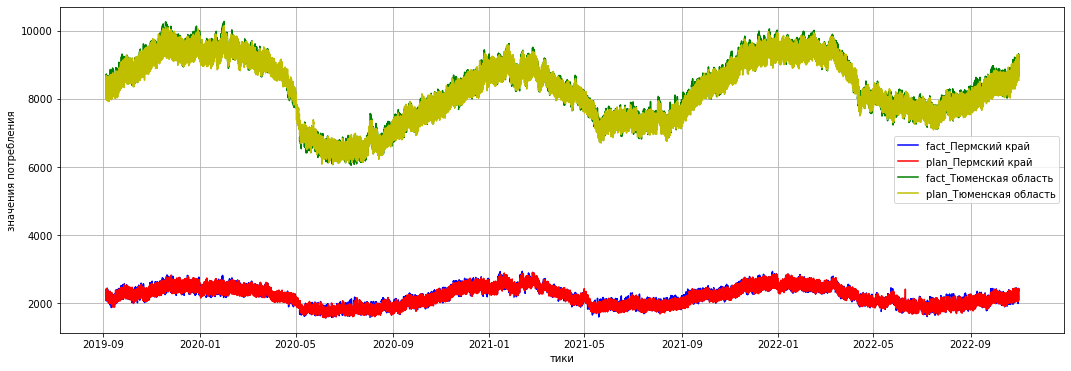

In [15]:
vis = df

# мастшабируем некоторые значения

t = vis['date'].unique()
ecf_p = vis.loc[vis['subject'] == 'Пермский край', 'energy_consumption'].values
ecf_t = vis.loc[vis['subject'] == 'Тюменская область', 'energy_consumption'].values
ecp_p = vis.loc[vis['subject'] == 'Пермский край', 'p1'].values
ecp_t = vis.loc[vis['subject'] == 'Тюменская область', 'p1'].values
plt.figure(figsize= (18, 6))
plt.plot(t, ecf_p, 'b', label = 'fact_Пермский край')
plt.plot(t, ecp_p, 'r', label = 'plan_Пермский край')
plt.plot(t, ecf_t, 'g', label = 'fact_Тюменская область')
plt.plot(t, ecp_t, 'y', label = 'plan_Тюменская область')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения потребления')
plt.legend()

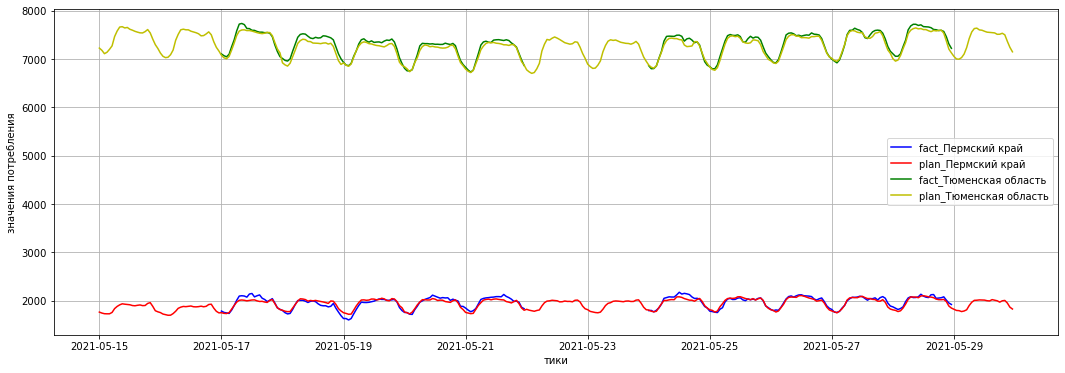

In [16]:
vis = df[(df.year == 2021) & (df.month == 5) & (df.day.isin(np.arange(15, 30)))]

# мастшабируем некоторые значения

t = vis['date'].unique()
ecf_p = vis.loc[vis['subject'] == 'Пермский край', 'energy_consumption'].values
ecf_t = vis.loc[vis['subject'] == 'Тюменская область', 'energy_consumption'].values
ecp_p = vis.loc[vis['subject'] == 'Пермский край', 'p1'].values
ecp_t = vis.loc[vis['subject'] == 'Тюменская область', 'p1'].values
plt.figure(figsize= (18, 6))
plt.plot(t, ecf_p, 'b', label = 'fact_Пермский край')
plt.plot(t, ecp_p, 'r', label = 'plan_Пермский край')
plt.plot(t, ecf_t, 'g', label = 'fact_Тюменская область')
plt.plot(t, ecp_t, 'y', label = 'plan_Тюменская область')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения потребления')
plt.legend()

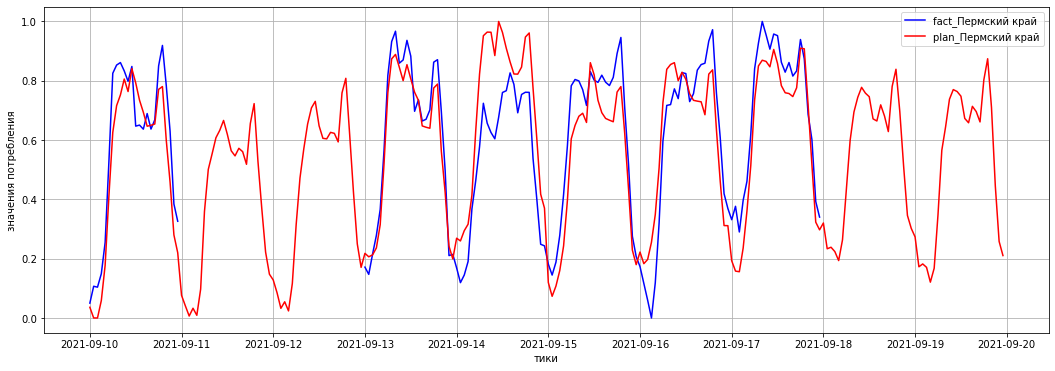

In [17]:
vis = df[(df.year == 2021) & (df.month == 9) & (df.day.isin(np.arange(10, 20)))]

# мастшабируем некоторые значения

scl_minmax = MinMaxScaler()

t = vis['date'].unique()
ecf_p = scl_minmax.fit_transform(vis.loc[vis['subject'] == 'Пермский край', 'energy_consumption'].values.reshape(-1, 1))
ecp_p = scl_minmax.fit_transform(vis.loc[vis['subject'] == 'Пермский край', 'p1'].values.reshape(-1, 1))

plt.figure(figsize= (18, 6))
plt.plot(t, ecf_p, 'b', label = 'fact_Пермский край')
plt.plot(t, ecp_p, 'r', label = 'plan_Пермский край')

plt.grid()
plt.xlabel('тики')
plt.ylabel('значения потребления')
plt.legend()

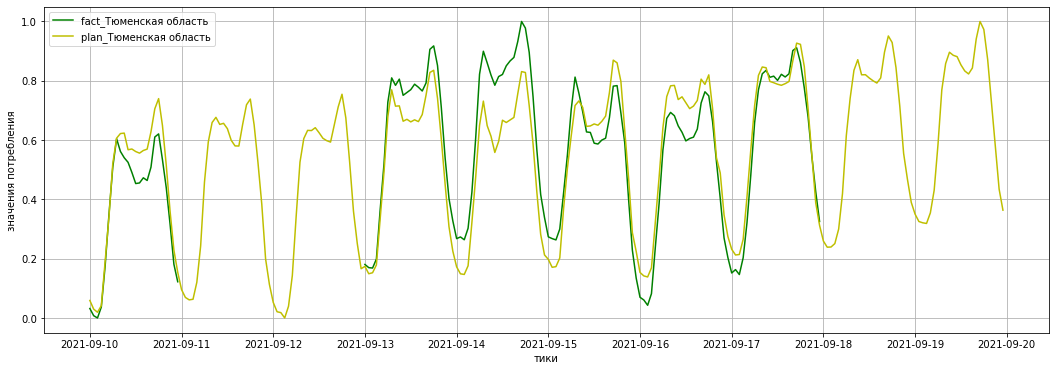

In [18]:
vis = df[(df.year == 2021) & (df.month == 9) & (df.day.isin(np.arange(10, 20)))]

# мастшабируем некоторые значения

scl_minmax = MinMaxScaler()

t = vis['date'].unique()
ecf_t = scl_minmax.fit_transform(vis.loc[vis['subject'] == 'Тюменская область', 'energy_consumption'].values.reshape(-1, 1))
ecp_t = scl_minmax.fit_transform(vis.loc[vis['subject'] == 'Тюменская область', 'p1'].values.reshape(-1, 1))
plt.figure(figsize= (18, 6))
plt.plot(t, ecf_t, 'g', label = 'fact_Тюменская область')
plt.plot(t, ecp_t, 'y', label = 'plan_Тюменская область')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения потребления')
plt.legend()

На данный момент мы не имеем информации о потреблении в нерабочие дни и выходные, поэтому мы не можем на них обучаться, исключим их.

In [19]:
df = df[~df['energy_consumption'].isna()].reset_index(drop = True).drop(['period'], axis = 1) #.drop(['isholiday', 'isworkday', 'weekend', 'period'], axis = 1)

In [20]:
df

date        p1        p2        p3       p4       p5  \
0     2019-09-04 00:00:00  2108.585  1925.165  1276.939   925.51   916.39   
1     2019-09-04 00:00:00  8048.975   477.945   391.531   896.61   870.14   
2     2019-09-04 01:00:00  2095.950  1753.115  1084.544   894.11   884.31   
3     2019-09-04 01:00:00  8023.158   386.711   592.522   894.45   867.82   
4     2019-09-04 02:00:00  2088.895  1558.524   877.092   878.75   867.91   
...                   ...       ...       ...       ...      ...      ...   
36715 2022-10-31 21:00:00  2200.384  1716.497  1915.647  1341.90  1315.29   
36716 2022-10-31 22:00:00  8648.255  1364.401   213.119  1006.81   972.51   
36717 2022-10-31 22:00:00  2135.249   933.732  1429.983  1154.63  1136.97   
36718 2022-10-31 23:00:00  2108.881   511.540   972.806  1034.74  1019.72   
36719 2022-10-31 23:00:00  8546.518   795.969   439.974   984.44   951.84   

              p6            subject  energy_consumption  year  month  day  \
0       2404.885      Пермский край            2099.557  2019      9    4   
1       9665.977  Тюменская область            8089.631  2019      9    4   
2       2392.250      Пермский край            2105.597  2019      9    4   
3       9640.160  Тюменская область            8081.073  2019      9    4   
4       2385.195      Пермский край            2079.832  2019      9    4   
...          ...                ...                 ...   ...    ...  ...   
36715   2592.084      Пермский край            2185.941  2022     10   31   
36716  10453.796  Тюменская область            8749.756  2022     10   31   
36717   2526.949      Пермский край            2109.249  2022     10   31   
36718   2498.581      Пермский край            2102.360  2022     10   31   
36719  10351.941  Тюменская область            8668.574  2022     10   31   

       hour date_months  
0         0  2019-09-01  
1         0  2019-09-01  
2         1  2019-09-01  
3         1  2019-09-01  
4         2  2019-09-01  
...     ...         ...  
36715    21  2022-10-01  
36716    22  2022-10-01  
36717    22  2022-10-01  
36718    23  2022-10-01  
36719    23  2022-10-01  

[36720 rows x 14 columns]

# Часть 1. Определение пиков

Определим пики и отметим их признаком max_ec для фактического пика и max_ep для планового пика по результатам торгов.  
Также для каждого часа отметим час, в который был пик фактического и планового потребления в этот день в признаках max_ec_hour и max_ep_hour.

In [21]:
mapping_max = df[['year', 'month', 'day','hour','energy_consumption','subject']].groupby(['year', 'month', 'day', 'subject'], as_index = False)['energy_consumption'].max()
max_ec = pd.merge(df[['year', 'month', 'day','subject']], mapping_max, on = ['year', 'month', 'day','subject'], how = 'left')['energy_consumption']
df['max_ec'] = np.where(df['energy_consumption'] == max_ec, 1, 0)

mapping_max['max_ec_hour'] = df[df['max_ec'] == 1].groupby(['year', 'month', 'day', 'subject'], as_index = False)['hour'].max()['hour']
df = pd.merge(df, mapping_max[['year', 'month', 'day', 'subject', 'max_ec_hour']], on = ['year', 'month', 'day', 'subject'], how = 'left')

In [22]:
mapping_max_p = df[['year', 'month', 'day','hour','p1', 'subject']].groupby(['year', 'month', 'day','subject'], as_index = False)['p1'].max()
max_ep = pd.merge(df[['year', 'month', 'day','subject']], mapping_max_p, on = ['year', 'month', 'day','subject'], how = 'left')['p1']
df['max_ep'] = np.where(df['p1'] == max_ep, 1, 0)

mapping_max['max_ep_hour'] = df[df['max_ep'] == 1].groupby(['year', 'month', 'day', 'subject'], as_index = False)['hour'].max()['hour']
df = pd.merge(df, mapping_max[['year', 'month', 'day', 'subject', 'max_ep_hour']], on = ['year', 'month', 'day', 'subject'], how = 'left')

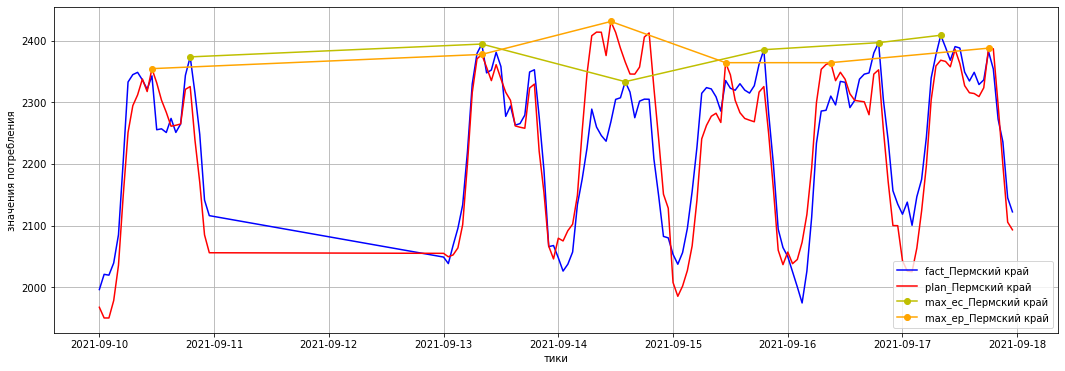

In [23]:
vis = df[(df.year == 2021) & (df.month == 9) & (df.day.isin(np.arange(10, 20)))]

# мастшабируем некоторые значения

t = vis['date'].unique()
ecf_p = vis.loc[vis['subject'] == 'Пермский край', 'energy_consumption'].values

ecp_p = vis.loc[vis['subject'] == 'Пермский край', 'p1'].values

max_ec_p = (vis.loc[(vis['max_ec'] == 1) & (vis['subject'] == 'Пермский край'), 'max_ec'] * vis.loc[(vis['max_ec'] == 1) & (vis['subject'] == 'Пермский край'),'energy_consumption']).values
max_ep_p = (vis.loc[(vis['max_ep'] == 1) & (vis['subject'] == 'Пермский край'), 'max_ep'] * vis.loc[(vis['max_ep'] == 1) & (vis['subject'] == 'Пермский край'),'p1']).values


plt.figure(figsize= (18, 6))
plt.plot(t, ecf_p, 'b', label = 'fact_Пермский край')
plt.plot(t, ecp_p, 'r', label = 'plan_Пермский край')

plt.plot(vis.loc[(vis['max_ec'] == 1) & (vis['subject'] == 'Пермский край'), 'date'], max_ec_p, 'y', label = 'max_ec_Пермский край', marker = 'o')
plt.plot(vis.loc[(vis['max_ep'] == 1) & (vis['subject'] == 'Пермский край'), 'date'], max_ep_p, 'orange', label = 'max_ep_Пермский край', marker = 'o')


plt.grid()
plt.xlabel('тики')
plt.ylabel('значения потребления')
plt.legend()

Добавим строгие интервалы, в которые должны входить максимумы. Максимумы в данных интервалах мы будем предсказывать.

In [24]:
plan_max_ec_intervals = [[[8, 21]],
[[8, 13], [17,21]],
[[8,21]],
[[8, 15], [20,21]],
[[8, 15], [20,21]],
[[8, 16], [20,21]],
[[8, 17], [20,21]],
[[8,21]],
[[8, 15], [18,21]],
[[8,21]],
[[8, 11], [16,21]],
[[8, 12], [15,21]]]

In [25]:
plan_max_ec_hours = []
for i in range(len(plan_max_ec_intervals)):
    num_of_intervals = len(plan_max_ec_intervals[i])
    hours = []
    for n in range(num_of_intervals):
        interval = np.arange(plan_max_ec_intervals[i][n][0] -1, plan_max_ec_intervals[i][n][1])
        hours.extend(interval)
    plan_max_ec_hours.append(hours)

# словарь месяц : часы, входящие в необходимые инетрвалы пиковых часов
limited_intervals = dict(zip(np.unique(df.month), plan_max_ec_hours))
limited_intervals

{1: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 2: [7, 8, 9, 10, 11, 12, 16, 17, 18, 19, 20],
 3: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 4: [7, 8, 9, 10, 11, 12, 13, 14, 19, 20],
 5: [7, 8, 9, 10, 11, 12, 13, 14, 19, 20],
 6: [7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 20],
 7: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20],
 8: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 9: [7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20],
 10: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 11: [7, 8, 9, 10, 15, 16, 17, 18, 19, 20],
 12: [7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20]}

In [26]:
# количество фактических меток (часов), входящих в интервалы в разные месяцы
[len(x) for x in plan_max_ec_hours]

[14, 11, 14, 10, 10, 11, 12, 14, 12, 14, 10, 12]

Добавим строгий фильтр по интервалам и переназначим максимумы пиковые в тех днях, в которых фактические максимумы выходят за рамки строго инетрвала.

In [27]:
for month in limited_intervals.keys():
    df.loc[(df.month == month), 'ec_interval_flag'] = np.where(df.loc[df.month == month, 'hour'].isin(limited_intervals[month]), 1, 0)

Отметим пиковые часы фактического и планового потребления в строгих интервала в признаках max_ec_lim и max_ep_lim.  
Запишем для каждого часа в дне максимальные значения в строгих интервалах в признаках max_ec_lim_hour и max_ep_lim_hour

In [28]:
mapping_max = df.loc[df['ec_interval_flag'] == 1, ['year', 'month', 'day','hour','energy_consumption','subject']].groupby(['year', 'month', 'day', 'subject'], as_index = False)['energy_consumption'].max()
max_ec_lim = pd.merge(df[['year', 'month', 'day','subject']], mapping_max, on = ['year', 'month', 'day','subject'], how = 'left')['energy_consumption']
df['max_ec_lim'] = np.where(df['energy_consumption'] == max_ec_lim, 1, 0)

mapping_max['max_ec_lim_hour'] = df[df['max_ec_lim'] == 1].groupby(['year', 'month', 'day', 'subject'], as_index = False)['hour'].max()['hour']
df = pd.merge(df, mapping_max[['year', 'month', 'day', 'subject', 'max_ec_lim_hour']], on = ['year', 'month', 'day', 'subject'], how = 'left')

In [29]:
mapping_max_p = df.loc[df['ec_interval_flag'] == 1, ['year', 'month', 'day','hour','p1', 'subject']].groupby(['year', 'month', 'day','subject'], as_index = False)['p1'].max()
max_ep_lim = pd.merge(df[['year', 'month', 'day','subject']], mapping_max_p, on = ['year', 'month', 'day','subject'], how = 'left')['p1']
df['max_ep_lim'] = np.where(df['p1'] == max_ep_lim, 1, 0)

mapping_max['max_ep_lim_hour'] = df[df['max_ep_lim'] == 1].groupby(['year', 'month', 'day', 'subject'], as_index = False)['hour'].max()['hour']
df = pd.merge(df, mapping_max[['year', 'month', 'day', 'subject', 'max_ep_lim_hour']], on = ['year', 'month', 'day', 'subject'], how = 'left')

Посмотрим сколько фактических максимумов выходит за рамки интервалов.

<AxesSubplot:xlabel='hour', ylabel='Count'>

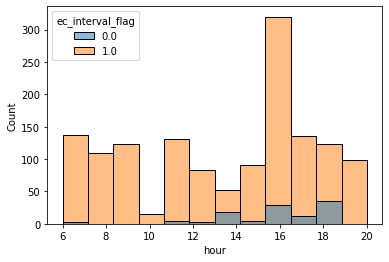

In [30]:
sns.histplot(
    data = df.loc[df['max_ec'] == 1],
    x = 'hour',
    hue = 'ec_interval_flag')

<AxesSubplot:xlabel='month', ylabel='Count'>

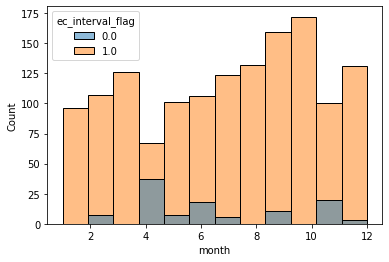

In [31]:
sns.histplot(
    data = df.loc[df['max_ec'] == 1],
    x = 'month',
    hue = 'ec_interval_flag')

In [32]:
result_table = df[df['max_ec_lim'] == 1]
result_table['Регион РФ'] = result_table['subject']
result_table['Дата'] = pd.to_datetime(result_table[["year", "month", "day"]])
result_table['Номер часа пиковой нагрузки'] = result_table['hour']
result_table = result_table[
    ['Регион РФ', 'Дата', 'Номер часа пиковой нагрузки']
    ].reset_index(
    drop = True
    ).sort_values(
        by = ['Дата', 'Регион РФ', 'Номер часа пиковой нагрузки']
        )

In [33]:
result_table

Регион РФ       Дата  Номер часа пиковой нагрузки
1         Пермский край 2019-09-04                           19
0     Тюменская область 2019-09-04                           18
3         Пермский край 2019-09-05                           19
2     Тюменская область 2019-09-05                           18
4         Пермский край 2019-09-06                            7
...                 ...        ...                          ...
1525  Тюменская область 2022-10-27                           16
1526      Пермский край 2022-10-28                            9
1527  Тюменская область 2022-10-28                           15
1529      Пермский край 2022-10-31                           16
1528  Тюменская область 2022-10-31                           16

[1530 rows x 3 columns]

In [34]:
result_table.dtypes

Регион РФ                              object
Дата                           datetime64[ns]
Номер часа пиковой нагрузки             int64
dtype: object

In [35]:
result_table.to_excel('Часы пиковой нагрузки.xlsx', index = False)

In [36]:
# визуализация признаков для тренировочной выборки
# report = eda.create_report(df[~((df.year == 2022) & (df.month.isin([5,6,7,8,9,10])))])
# report.show_browser() # вывести отчёт в браузере
# report

# Часть 2. Эталонная модель

Смоделируем эталонные предсказания основанные на статистике пиковых нагрузок для каждого месяца за прошлый год.
1)	Вычислить статистику по пиковым часам за предыдущий год (доля значений пиковых часов за весь месяц, соответствующих каждому часу с 0-го по 23-й)
2)	Определить 4-часовой диапазон для месяца, для которого сумма долей максимальна
3)	Если пиковое значение попадает на единственный час, то для диапазона необходимо брать значения, предшествующие ему.
4)	Использовать данный диапазон для прогнозирования значений за соответствующие месяцы 2022 г.

In [37]:
# создадим таблицу для сбора статистики (year, month, subject)
yms_max_ec_stat = pd.DataFrame()

# выбираем каждый уникальный год_месяц_субъект
for indx in df.groupby(['year', 'month', 'subject']):
        year = indx[0][0]
        month = indx[0][1]
        subject = indx[0][2]
        
        # рассчитываем долю пиковых часов для каждого года_месяца_субъекта
        temp_df = df[(df['year'] == year) & (df['month'] == month) & (df['subject'] == subject)].groupby(['year','month', 'subject','hour'], as_index = False)['max_ec'].mean()
        # рассчитываем сумму долей в окне из 4х часов
        temp_df['window_sum'] = temp_df['max_ec'].rolling(window=4).sum().fillna(0)

        # выбираем окно по максимальному значению, при равенстве сумм, выбираем значение, которое встретилось раньше
        temp_df['hours4max'] = temp_df.sort_values(by = ['window_sum','hour'], ascending= [False, True]).iloc[0]['hour']

        # собираем значения
        yms_max_ec_stat = pd.concat([yms_max_ec_stat, temp_df[['year', 'month','subject','hours4max']].drop_duplicates()])

yms_max_ec_stat = yms_max_ec_stat.sort_values(by = ['year', 'month'])

In [38]:
# пример последнего расчёта для эталонной модели для 2022 года 10 месяца Тюменской области
temp_df

year  month            subject  hour  max_ec  window_sum  hours4max
0   2022     10  Тюменская область     0    0.00        0.00         17
1   2022     10  Тюменская область     1    0.00        0.00         17
2   2022     10  Тюменская область     2    0.00        0.00         17
3   2022     10  Тюменская область     3    0.00        0.00         17
4   2022     10  Тюменская область     4    0.00        0.00         17
5   2022     10  Тюменская область     5    0.00        0.00         17
6   2022     10  Тюменская область     6    0.00        0.00         17
7   2022     10  Тюменская область     7    0.00        0.00         17
8   2022     10  Тюменская область     8    0.00        0.00         17
9   2022     10  Тюменская область     9    0.00        0.00         17
10  2022     10  Тюменская область    10    0.00        0.00         17
11  2022     10  Тюменская область    11    0.00        0.00         17
12  2022     10  Тюменская область    12    0.00        0.00         17
13  2022     10  Тюменская область    13    0.00        0.00         17
14  2022     10  Тюменская область    14    0.00        0.00         17
15  2022     10  Тюменская область    15    0.05        0.05         17
16  2022     10  Тюменская область    16    0.90        0.95         17
17  2022     10  Тюменская область    17    0.05        1.00         17
18  2022     10  Тюменская область    18    0.00        1.00         17
19  2022     10  Тюменская область    19    0.00        0.95         17
20  2022     10  Тюменская область    20    0.00        0.05         17
21  2022     10  Тюменская область    21    0.00        0.00         17
22  2022     10  Тюменская область    22    0.00        0.00         17
23  2022     10  Тюменская область    23    0.00        0.00         17

Верхняя граница интервала в 17 часов рассчитана правильно. 

In [39]:
# таблица с верхними границами интервалов для каждого месяца
yms_max_ec_stat

year  month            subject  hours4max
0   2019      9      Пермский край         19
0   2019      9  Тюменская область         18
0   2019     10      Пермский край         18
0   2019     10  Тюменская область         17
0   2019     11      Пермский край         16
..   ...    ...                ...        ...
0   2022      8  Тюменская область         11
0   2022      9      Пермский край          9
0   2022      9  Тюменская область         18
0   2022     10      Пермский край          9
0   2022     10  Тюменская область         17

[76 rows x 4 columns]

In [40]:
# сделаем сдвиг на 12 месяцев для каждого региона
shift_step = 12 * yms_max_ec_stat['subject'].nunique()
yms_max_ec_stat['hours4max_shift_year'] = yms_max_ec_stat['hours4max'].shift(shift_step)

In [41]:
# оценим результат для октября
yms_max_ec_stat[yms_max_ec_stat['month'] == 10].sort_values(by = 'subject')

year  month            subject  hours4max  hours4max_shift_year
0  2019     10      Пермский край         18                   NaN
0  2020     10      Пермский край         19                  18.0
0  2021     10      Пермский край         17                  19.0
0  2022     10      Пермский край          9                  17.0
0  2019     10  Тюменская область         17                   NaN
0  2020     10  Тюменская область         17                  17.0
0  2021     10  Тюменская область         17                  17.0
0  2022     10  Тюменская область         17                  17.0

Видим, что для каждого региона верхняя граница интервала предсказывается так, как нам нужно.  
Подготовим таблицу с предсказаниями и целевыми часами.  
Самый первый год, где у нас нет предсказаний, отбросим из таблцы.  
В итоге у нас останется таблица с датами, субъектом, номером часа максимального потребления и предсказанием верха интервала.

In [42]:
df_baseline = pd.merge(
    df[['year', 'month', 'day', 'subject', 'date_months','max_ec_lim_hour']], 
    yms_max_ec_stat[['year', 'month', 'subject', 'hours4max_shift_year']],
    on = ['year', 'month', 'subject'], how = 'left'
    ).dropna().drop_duplicates().reset_index(drop = True)

In [43]:
df_baseline

year  month  day            subject date_months  max_ec_lim_hour  \
0     2020      9    1      Пермский край  2020-09-01               10   
1     2020      9    1  Тюменская область  2020-09-01               14   
2     2020      9    2      Пермский край  2020-09-01               19   
3     2020      9    2  Тюменская область  2020-09-01               18   
4     2020      9    3      Пермский край  2020-09-01               19   
...    ...    ...  ...                ...         ...              ...   
1069  2022     10   27      Пермский край  2022-10-01               16   
1070  2022     10   28      Пермский край  2022-10-01                9   
1071  2022     10   28  Тюменская область  2022-10-01               15   
1072  2022     10   31      Пермский край  2022-10-01               16   
1073  2022     10   31  Тюменская область  2022-10-01               16   

      hours4max_shift_year  
0                     19.0  
1                     18.0  
2                     19.0  
3                     18.0  
4                     19.0  
...                    ...  
1069                  17.0  
1070                  17.0  
1071                  17.0  
1072                  17.0  
1073                  17.0  

[1074 rows x 7 columns]

## Прогноз и оценка прогноза.

Разобъём выборку на обучающую и тестовую.  
На обучающей выборке будем проводить валидацию, отбор фичей, тюнинг гиперпараметров.  
На тестовой части будем проверять работу модели.  
Наивные модели без машинного обучения так же будем тестировать и на валидации и на тестовой выборке,  
т.к. мы не имеем возможности проверить на тестовой выборке весь год и информация из валидационной части по остальным месяцам будет для нас также полезной.  
Тестовая выборка это май, июнь, июль, август, сентябрь, октябрь 2022 года. Всё остальное - валидационная выборка.  
Результаты будем складировать в results_cv, results_cv_perm, results_cv_tyumen, results_test, results_test_perm, results_test_tyumen, 

In [44]:
results_cv = pd.DataFrame()
results_cv_perm = pd.DataFrame()
results_cv_tyumen = pd.DataFrame()
results_test = pd.DataFrame()
results_test_perm = pd.DataFrame()
results_test_tyumen = pd.DataFrame()

### Общий результат

In [45]:
enc_ticks = LabelEncoder()
time_series_ticks = pd.Series(enc_ticks.fit_transform(df_baseline['date_months']))

val_cv_indices = time_series_cv_indices(
    df_baseline, 
    time_series_ticks, 
    0, 19, 11)

test_cv_indices = time_series_cv_indices(
    df_baseline, 
    time_series_ticks, 
    0, 25, 19)

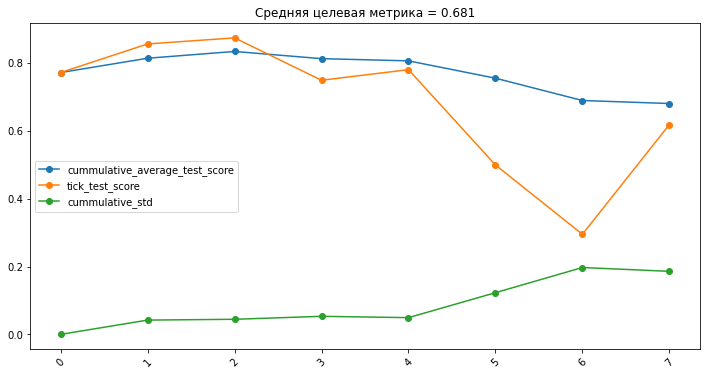

In [46]:
metric_table = stat_time_series_4hours_window_cv(df_baseline, 'hours4max_shift_year', 'max_ec_lim_hour', val_cv_indices)
metric_visual(metric_table)

In [47]:
metric_table

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.772727         0.772727         0.000000
1                        0.814935         0.857143         0.042208
2                        0.834957         0.875000         0.044603
3                        0.813718         0.750000         0.053342
4                        0.807224         0.781250         0.049446
5                        0.756020         0.500000         0.123072
6                        0.690225         0.295455         0.197375
7                        0.681328         0.619048         0.186122

In [48]:
results_cv['baseline'] = metric_table['tick_test_score']

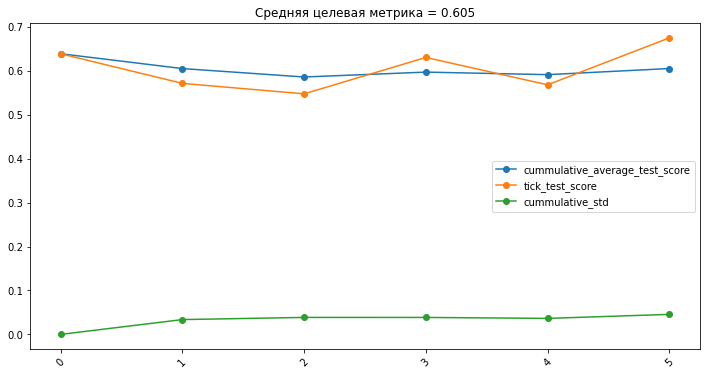

In [49]:
metric_table = stat_time_series_4hours_window_cv(df_baseline, 'hours4max_shift_year', 'max_ec_lim_hour', test_cv_indices)
metric_visual(metric_table)

In [50]:
display(metric_table)
results_test['baseline'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.638889         0.638889         0.000000
1                        0.605159         0.571429         0.033730
2                        0.585979         0.547619         0.038655
3                        0.597093         0.630435         0.038616
4                        0.591311         0.568182         0.036424
5                        0.605259         0.675000         0.045589

### Пермский край

In [51]:
enc_ticks = LabelEncoder()
time_series_ticks = pd.Series(enc_ticks.fit_transform(df_baseline['date_months']))

mask_df = df_baseline[df_baseline['subject'] == 'Пермский край']

val_cv_indices = time_series_cv_indices(
    mask_df, 
    time_series_ticks, 
    0, 19, 11)

test_cv_indices = time_series_cv_indices(
    mask_df, 
    time_series_ticks, 
    0, 25, 19)

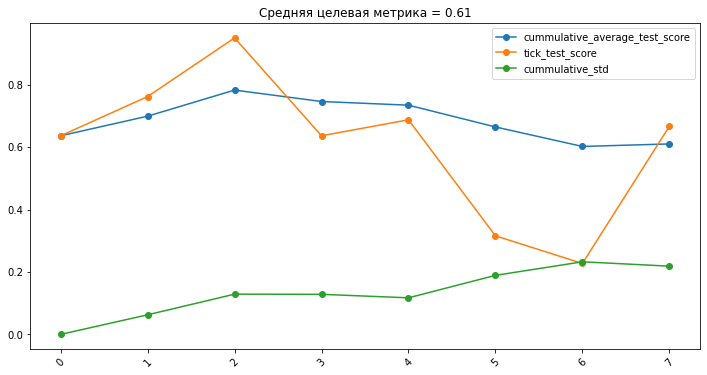

In [52]:
metric_table = stat_time_series_4hours_window_cv(mask_df, 'hours4max_shift_year', 'max_ec_lim_hour', val_cv_indices)
metric_visual(metric_table)

In [53]:
display(metric_table)
results_cv_perm['baseline'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.636364         0.636364         0.000000
1                        0.699134         0.761905         0.062771
2                        0.782756         0.950000         0.128888
3                        0.746158         0.636364         0.128364
4                        0.734426         0.687500         0.117185
5                        0.664654         0.315789         0.189169
6                        0.602171         0.227273         0.232589
7                        0.610233         0.666667         0.218610

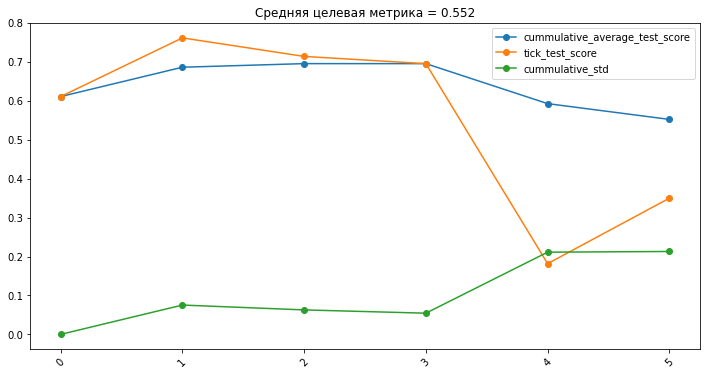

In [54]:
metric_table = stat_time_series_4hours_window_cv(mask_df, 'hours4max_shift_year', 'max_ec_lim_hour', test_cv_indices)
metric_visual(metric_table)

In [55]:
display(metric_table)
results_test_perm['baseline'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.611111         0.611111         0.000000
1                        0.686508         0.761905         0.075397
2                        0.695767         0.714286         0.062939
3                        0.695738         0.695652         0.054506
4                        0.592954         0.181818         0.211270
5                        0.552462         0.350000         0.213059

### Тюменская область

In [56]:
enc_ticks = LabelEncoder()
time_series_ticks = pd.Series(enc_ticks.fit_transform(df_baseline['date_months']))

mask_df = df_baseline[df_baseline['subject'] == 'Тюменская область']

val_cv_indices = time_series_cv_indices(
    mask_df, 
    time_series_ticks, 
    0, 19, 11)

test_cv_indices = time_series_cv_indices(
    mask_df, 
    time_series_ticks, 
    0, 25, 19)

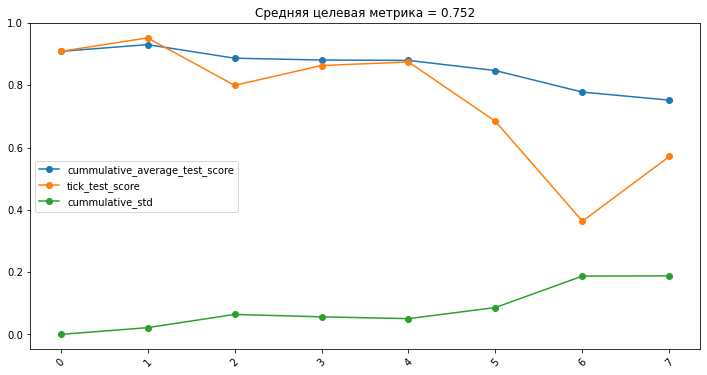

In [57]:
metric_table = stat_time_series_4hours_window_cv(mask_df, 'hours4max_shift_year', 'max_ec_lim_hour', val_cv_indices)
metric_visual(metric_table)

In [58]:
display(metric_table)
results_cv_tyumen['baseline'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.909091         0.909091         0.000000
1                        0.930736         0.952381         0.021645
2                        0.887157         0.800000         0.064113
3                        0.881277         0.863636         0.056450
4                        0.880022         0.875000         0.050553
5                        0.847386         0.684211         0.086342
6                        0.778279         0.363636         0.187202
7                        0.752423         0.571429         0.188000

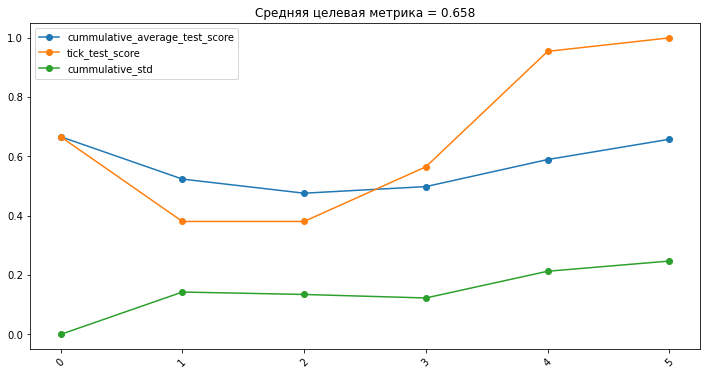

In [59]:
metric_table = stat_time_series_4hours_window_cv(mask_df, 'hours4max_shift_year', 'max_ec_lim_hour', test_cv_indices)
metric_visual(metric_table)

In [60]:
display(metric_table)
results_test_tyumen['baseline'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.666667         0.666667         0.000000
1                        0.523810         0.380952         0.142857
2                        0.476190         0.380952         0.134687
3                        0.498447         0.565217         0.122848
4                        0.589667         0.954545         0.212973
5                        0.658056         1.000000         0.247352

# Часть 3. Модели машинного обучения

## Подготовка выборки и целевой метрики

Мы имеем низкую долю пиковых часов в выборке. Всего 1 час из 24 часов.  
Это усложнит поиск пикового часа для алгоритмов машинного обучения.  
Попробуем преобразовать выборку и целевую переменную, чтобы повысить эффективность будущей модели.

In [61]:
df['max_ec'].value_counts(normalize = True)

0    0.958333
1    0.041667
Name: max_ec, dtype: float64

### Возможность использовать undersampling

За прошлые года строгий интервал плановых пиковых нагрузок для первой ценовой зоны не менялся.  
Посмотрим ещё раз на количество и долю пиковых часов в определённые часы.

<AxesSubplot:xlabel='hour', ylabel='Count'>

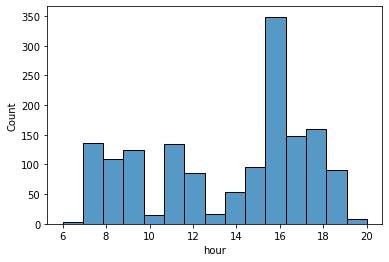

In [62]:
sns.histplot(
    data = df[df['max_ec'] == 1],
    x = 'hour',
    bins = df.loc[df['max_ec'] == 1, 'hour'].nunique()
    # hue = 'max_ec'
)

In [63]:
df.groupby(['hour'])['max_ec'].mean()

hour
0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.001961
7     0.089542
8     0.071242
9     0.081046
10    0.009804
11    0.088235
12    0.056209
13    0.011111
14    0.034641
15    0.062745
16    0.228105
17    0.096732
18    0.103922
19    0.059477
20    0.005229
21    0.000000
22    0.000000
23    0.000000
Name: max_ec, dtype: float64

Часы 6, 21, 22, 23 не входят в диапазон [7, 21), которые представлены в требованиях строгости нахождения часов в интервале.  
Избавимся от данных интервалов, чтобы увеличить долю пиковых часов общей выборке.  
Перед этим посмотрим и преобразуем информацию в тот, день, когда пиковая нагрузка пришлась на 6 утра.  
Будем считать это выбросом в данных.

In [64]:
df[(df['max_ec'] == 1) & (df['hour'] == 6)]

date        p1        p2       p3       p4       p5  \
109   2019-09-06 06:00:00  2364.658  1858.981  930.299  1256.31  1233.12   
16572 2021-02-20 06:00:00  2704.089  1187.772  867.251  1350.00  1319.38   
30301 2022-04-19 06:00:00  2182.912  1209.515  713.138  1360.30  1326.40   

             p6        subject  energy_consumption  year  ...  date_months  \
109    2671.258  Пермский край            2398.685  2019  ...   2019-09-01   
16572  3100.829  Пермский край            2814.238  2021  ...   2021-02-01   
30301  2502.612  Пермский край            2257.607  2022  ...   2022-04-01   

       max_ec  max_ec_hour max_ep  max_ep_hour  ec_interval_flag  max_ec_lim  \
109         1            6      0           11               0.0           0   
16572       1            6      0           17               0.0           0   
30301       1            6      0            9               0.0           0   

       max_ec_lim_hour  max_ep_lim  max_ep_lim_hour  
109                  7           0               11  
16572               17           0               17  
30301                7           0                9  

[3 rows x 23 columns]

Преобразуем максимум в этих днях так, чтобы максимум потребления приходился на часы, которые входят в интервал.

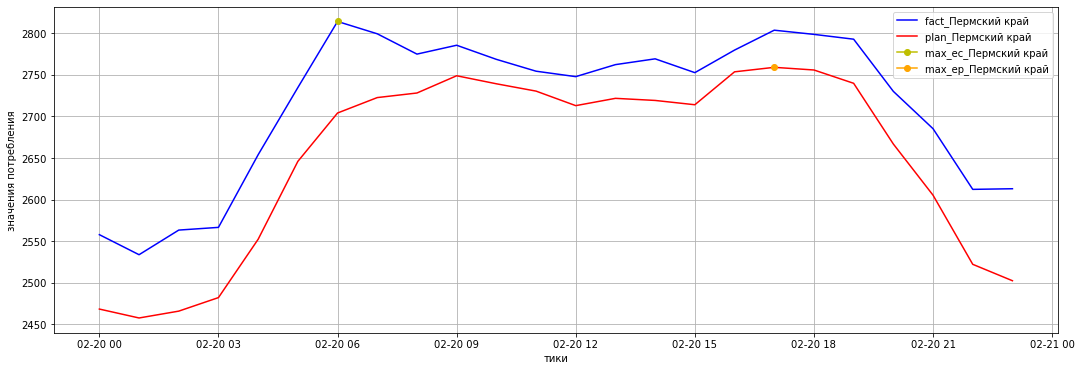

In [65]:
vis = df[(df.year == 2021) & (df.month == 2) & (df.day == 20)]

# мастшабируем некоторые значения

t = vis['date'].unique()
ecf_p = vis.loc[vis['subject'] == 'Пермский край', 'energy_consumption'].values

ecp_p = vis.loc[vis['subject'] == 'Пермский край', 'p1'].values

max_ec_p = (vis.loc[(vis['max_ec'] == 1) & (vis['subject'] == 'Пермский край'), 'max_ec'] * vis.loc[(vis['max_ec'] == 1) & (vis['subject'] == 'Пермский край'),'energy_consumption']).values
max_ep_p = (vis.loc[(vis['max_ep'] == 1) & (vis['subject'] == 'Пермский край'), 'max_ep'] * vis.loc[(vis['max_ep'] == 1) & (vis['subject'] == 'Пермский край'),'p1']).values


plt.figure(figsize= (18, 6))
plt.plot(t, ecf_p, 'b', label = 'fact_Пермский край')
plt.plot(t, ecp_p, 'r', label = 'plan_Пермский край')

plt.plot(vis.loc[(vis['max_ec'] == 1) & (vis['subject'] == 'Пермский край'), 'date'], max_ec_p, 'y', label = 'max_ec_Пермский край', marker = 'o')
plt.plot(vis.loc[(vis['max_ep'] == 1) & (vis['subject'] == 'Пермский край'), 'date'], max_ep_p, 'orange', label = 'max_ep_Пермский край', marker = 'o')

plt.grid()
plt.xlabel('тики')
plt.ylabel('значения потребления')
plt.legend()

In [66]:
df.loc[16572, 'energy_consumption'] = 2799

mask = (df.year == 2021) & (df.month == 2) & (df.day == 20) & (df.subject == 'Пермский край') & (df.hour == 17)
df.loc[mask, 'max_ec'] = 1
mask = (df.year == 2021) & (df.month == 2) & (df.day == 20) & (df.subject == 'Пермский край') & (df.hour == 6)
df.loc[mask, 'max_ec'] = 0

mask = (df.year == 2021) & (df.month == 2) & (df.day == 20) & (df.subject == 'Пермский край')
df.loc[mask, 'max_ec_hour'] = 17

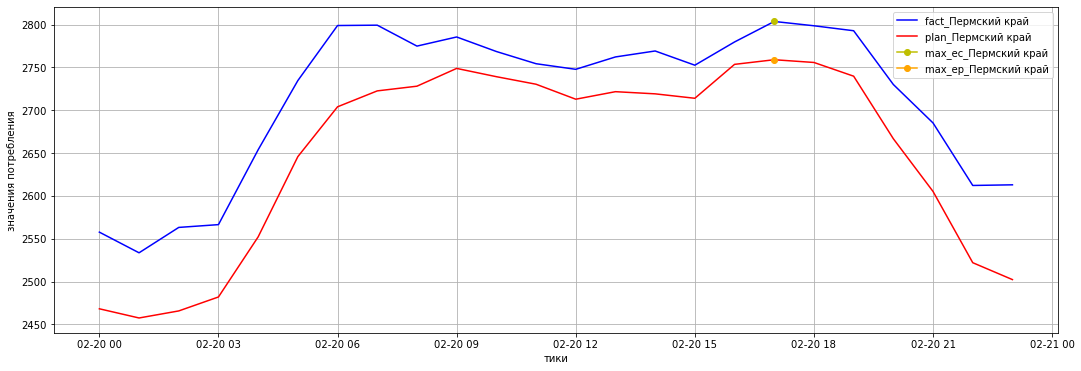

In [67]:
vis = df[(df.year == 2021) & (df.month == 2) & (df.day == 20)]

# мастшабируем некоторые значения

t = vis['date'].unique()
ecf_p = vis.loc[vis['subject'] == 'Пермский край', 'energy_consumption'].values

ecp_p = vis.loc[vis['subject'] == 'Пермский край', 'p1'].values

max_ec_p = (vis.loc[(vis['max_ec'] == 1) & (vis['subject'] == 'Пермский край'), 'max_ec'] * vis.loc[(vis['max_ec'] == 1) & (vis['subject'] == 'Пермский край'),'energy_consumption']).values
max_ep_p = (vis.loc[(vis['max_ep'] == 1) & (vis['subject'] == 'Пермский край'), 'max_ep'] * vis.loc[(vis['max_ep'] == 1) & (vis['subject'] == 'Пермский край'),'p1']).values


plt.figure(figsize= (18, 6))
plt.plot(t, ecf_p, 'b', label = 'fact_Пермский край')
plt.plot(t, ecp_p, 'r', label = 'plan_Пермский край')

plt.plot(vis.loc[(vis['max_ec'] == 1) & (vis['subject'] == 'Пермский край'), 'date'], max_ec_p, 'y', label = 'max_ec_Пермский край', marker = 'o')
plt.plot(vis.loc[(vis['max_ep'] == 1) & (vis['subject'] == 'Пермский край'), 'date'], max_ep_p, 'orange', label = 'max_ep_Пермский край', marker = 'o')

plt.grid()
plt.xlabel('тики')
plt.ylabel('значения потребления')
plt.legend()

In [68]:
mapping = df[(df['max_ec'] == 1) & (df['hour'] == 6)][['year', 'month', 'day', 'subject']]
for i in mapping.index:
    mask = (
        df['year'] == mapping.loc[i, 'year']) & (
            df['month'] == mapping.loc[i, 'month']) & (
                df['day'] == mapping.loc[i, 'day']) & (
                    df['subject'] == mapping.loc[i, 'subject'])
    df.loc[mask, 'max_ec_hour'] = 7
    df.loc[(mask) & (df['hour'] == 6), 'max_ec'] = 0
    df.loc[(mask) & (df['hour'] == 7), 'max_ec'] = 1

In [69]:
df.groupby(['hour'])['max_ec'].mean()

hour
0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.090850
8     0.071242
9     0.081046
10    0.009804
11    0.088235
12    0.056209
13    0.011111
14    0.034641
15    0.062745
16    0.228105
17    0.097386
18    0.103922
19    0.059477
20    0.005229
21    0.000000
22    0.000000
23    0.000000
Name: max_ec, dtype: float64

Выбросим часы без максимального потребления перед самым обучением после генерации признаков.  
Посмотрим как измеятся доли пиковых и непиковых часов.

In [70]:
df.loc[df['hour'].isin(range(7,21)), 'max_ec'].value_counts(normalize = True)

0    0.928571
1    0.071429
Name: max_ec, dtype: float64

Ситуация улучшилась. Искомого класса станет больше

### Преобразование таргета

Так как у нас есть возможность предсказывать интервалом из 4х часов, то закодируем целевую переменную так, чтобы у нас была информация о том, какие часы находятся рядом с пиковыми.
Также можно объяснитькак количество верно предсказанных интервалов существующет для этого часа. Для пикового часа существует 4 верных интервала, для соседей - 3, для часа, который расположен на расстоянии двух часов - 2, трёх - 1, на расстоянии более 3х часов от пикового не существует верных интервалов, их кодируем нулями.

In [71]:
df['new_class'] = 0
for n in range (5):
    df.loc[(
        df['max_ec_hour'] == df['hour'] + n) | (
            df['max_ec_hour'] == df['hour'] - n), 'new_class'] = 4 - n

In [72]:
df.loc[df['hour'].isin(range(7, 21)), 'new_class'].value_counts(normalize = True)

0    0.552474
3    0.135994
2    0.126657
1    0.113445
4    0.071429
Name: new_class, dtype: float64

<AxesSubplot:xlabel='new_class', ylabel='Count'>

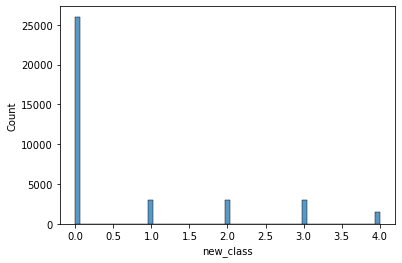

In [73]:
sns.histplot(df['new_class'])

Сравним плотность распредения метрики до и после преобразования.

<AxesSubplot:xlabel='hour', ylabel='Density'>

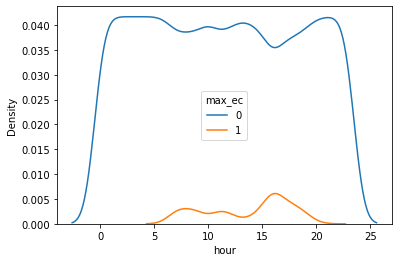

In [74]:
sns.kdeplot(
    data = df, 
    x = 'hour',
    hue = 'max_ec')

<AxesSubplot:xlabel='hour', ylabel='Density'>

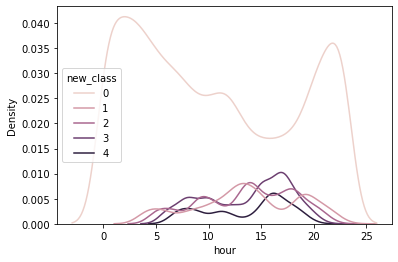

In [75]:
sns.kdeplot(
    data = df, 
    x = 'hour',
    hue = 'new_class')

<AxesSubplot:xlabel='hour', ylabel='Density'>

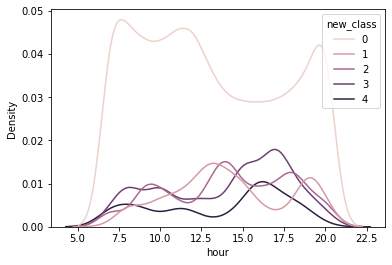

In [76]:
sns.kdeplot(
    data = df[df['hour'].isin(range(7, 21))], 
    x = 'hour',
    hue = 'new_class')

Закодируем интуитивный признак, удаление наблюдаемого часа от 11 часов.  
В таком случае плотность распределения нулевого класса возрастает с ростом, удалённости, а распределение класса 4 относительно этого расстояния становится более нормальным.

<AxesSubplot:xlabel='half_day_distance', ylabel='Density'>

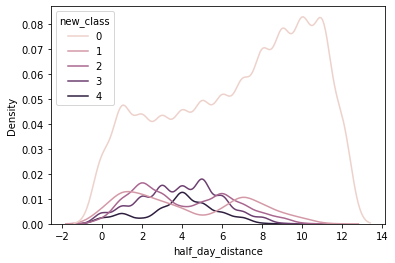

In [77]:
df['half_day_distance'] = np.abs(11 - df['hour'] + 1)

sns.kdeplot(
    data = df, 
    x = 'half_day_distance',
    hue = 'new_class')

## Stat_model_1

Повторим эталонную модель с новым классом

In [78]:
yms_max_ec_stat = pd.DataFrame()
for indx in df.groupby(['year', 'month', 'subject']):
        year = indx[0][0]
        month = indx[0][1]
        subject = indx[0][2]

        temp_df = df[(df['year'] == year) & (df['month'] == month) & (df['subject'] == subject)].groupby(['year','month', 'subject','hour'], as_index = False)['new_class'].mean()
        temp_df['window_sum'] = temp_df['new_class'].rolling(window=4).sum().fillna(0)
        temp_df['hours4max'] = temp_df.sort_values(by = ['window_sum','hour'], ascending= [False, True]).iloc[0]['hour']
        yms_max_ec_stat = pd.concat([yms_max_ec_stat, temp_df[['year', 'month','subject','hours4max']].drop_duplicates()])

yms_max_ec_stat = yms_max_ec_stat.sort_values(by = ['year', 'month'])

shift_step = 12 * yms_max_ec_stat['subject'].nunique()
yms_max_ec_stat['hours4max2_shift_year'] = yms_max_ec_stat['hours4max'].shift(shift_step)

In [79]:
df_naive_model_1 = pd.merge(
    df[['year', 'month', 'day', 'subject', 'date_months','max_ec_lim_hour']], 
    yms_max_ec_stat[['year', 'month', 'subject', 'hours4max2_shift_year']],
    on = ['year', 'month', 'subject'], how = 'left'
    ).dropna().drop_duplicates().reset_index(drop = True)

### Прогноз и оценка прогноза.

#### Общий результат

In [80]:
enc_ticks = LabelEncoder()
time_series_ticks = pd.Series(enc_ticks.fit_transform(df_naive_model_1['date_months']))

val_cv_indices = time_series_cv_indices(
    df_naive_model_1, 
    time_series_ticks, 
    0, 19, 11)

test_cv_indices = time_series_cv_indices(
    df_naive_model_1, 
    time_series_ticks, 
    0, 25, 19)

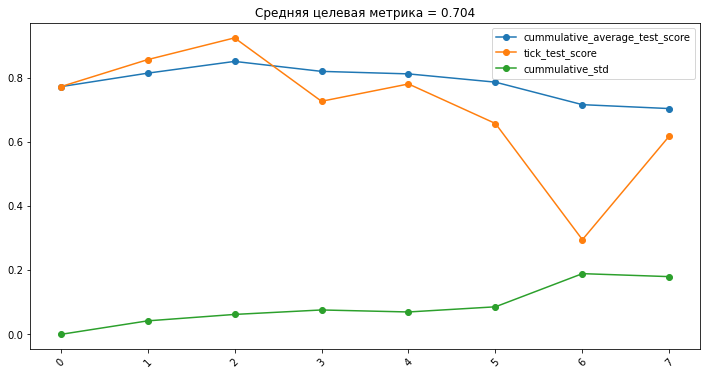

In [81]:
metric_table = stat_time_series_4hours_window_cv(df_naive_model_1, 'hours4max2_shift_year', 'max_ec_lim_hour', val_cv_indices)
metric_visual(metric_table)

In [82]:
display(metric_table)
results_cv['stat_model_1'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.772727         0.772727         0.000000
1                        0.814935         0.857143         0.042208
2                        0.851623         0.925000         0.062287
3                        0.820536         0.727273         0.076218
4                        0.812679         0.781250         0.069959
5                        0.786881         0.657895         0.086058
6                        0.716677         0.295455         0.189524
7                        0.704474         0.619048         0.180200

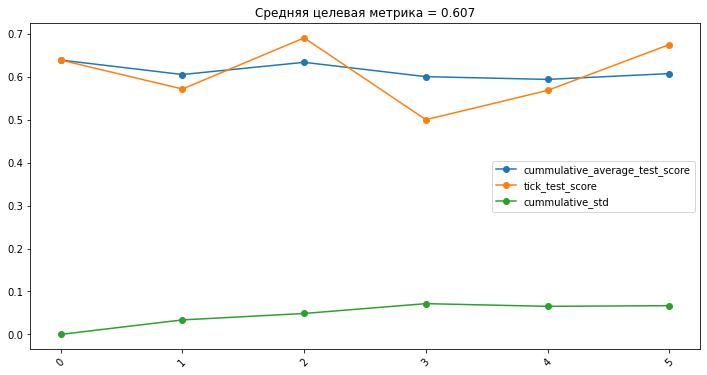

In [83]:
metric_table = stat_time_series_4hours_window_cv(df_naive_model_1, 'hours4max2_shift_year', 'max_ec_lim_hour', test_cv_indices)
metric_visual(metric_table)

In [84]:
display(metric_table)
results_test['stat_model_1'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.638889         0.638889         0.000000
1                        0.605159         0.571429         0.033730
2                        0.633598         0.690476         0.048745
3                        0.600198         0.500000         0.071614
4                        0.593795         0.568182         0.065322
5                        0.607329         0.675000         0.066870

#### Пермский край

In [85]:
enc_ticks = LabelEncoder()
time_series_ticks = pd.Series(enc_ticks.fit_transform(df_naive_model_1['date_months']))

mask_df = df_naive_model_1[df_naive_model_1['subject'] == 'Пермский край']

val_cv_indices = time_series_cv_indices(
    mask_df, 
    time_series_ticks, 
    0, 19, 11)

test_cv_indices = time_series_cv_indices(
    mask_df, 
    time_series_ticks, 
    0, 25, 19)

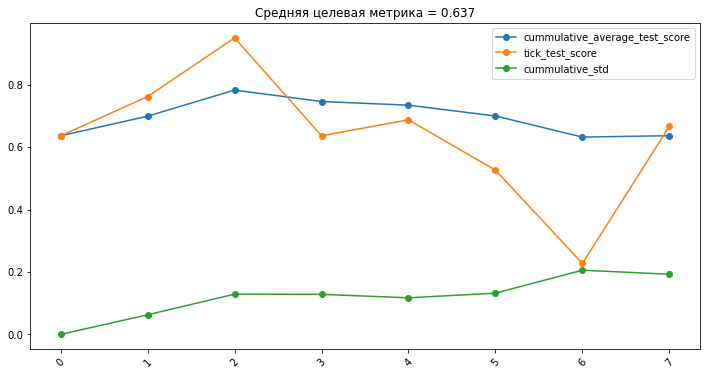

In [86]:
metric_table = stat_time_series_4hours_window_cv(mask_df, 'hours4max2_shift_year', 'max_ec_lim_hour', val_cv_indices)
metric_visual(metric_table)

In [87]:
display(metric_table)
results_cv_perm['stat_model_1'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.636364         0.636364         0.000000
1                        0.699134         0.761905         0.062771
2                        0.782756         0.950000         0.128888
3                        0.746158         0.636364         0.128364
4                        0.734426         0.687500         0.117185
5                        0.699741         0.526316         0.132132
6                        0.632246         0.227273         0.205666
7                        0.636548         0.666667         0.192720

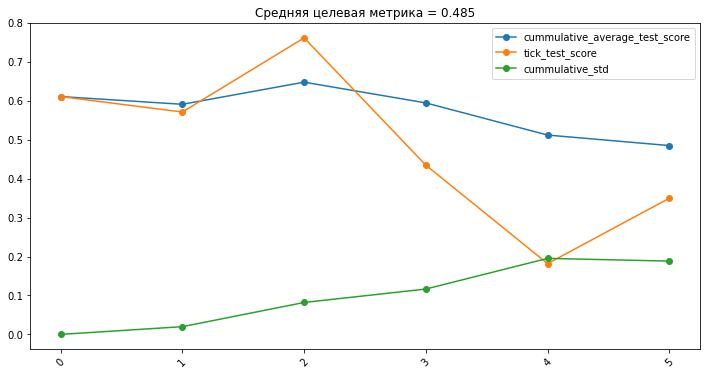

In [88]:
metric_table = stat_time_series_4hours_window_cv(mask_df, 'hours4max2_shift_year', 'max_ec_lim_hour', test_cv_indices)
metric_visual(metric_table)

In [89]:
display(metric_table)
results_test_perm['stat_model_1'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.611111         0.611111         0.000000
1                        0.591270         0.571429         0.019841
2                        0.648148         0.761905         0.082053
3                        0.594807         0.434783         0.116557
4                        0.512209         0.181818         0.195340
5                        0.485174         0.350000         0.188289

#### Тюменская область

In [90]:
enc_ticks = LabelEncoder()
time_series_ticks = pd.Series(enc_ticks.fit_transform(df_naive_model_1['date_months']))

mask_df = df_naive_model_1[df_naive_model_1['subject'] == 'Тюменская область']

val_cv_indices = time_series_cv_indices(
    mask_df, 
    time_series_ticks, 
    0, 19, 11)

test_cv_indices = time_series_cv_indices(
    mask_df, 
    time_series_ticks, 
    0, 25, 19)

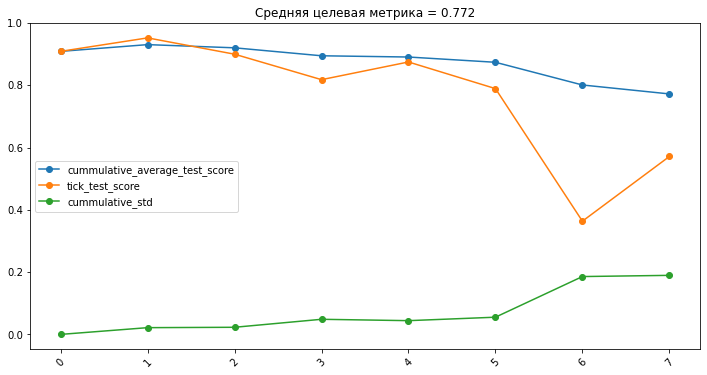

In [91]:
metric_table = stat_time_series_4hours_window_cv(mask_df, 'hours4max2_shift_year', 'max_ec_lim_hour', val_cv_indices)
metric_visual(metric_table)

In [92]:
display(metric_table)
results_cv_tyumen['stat_model_1'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.909091         0.909091         0.000000
1                        0.930736         0.952381         0.021645
2                        0.920491         0.900000         0.022853
3                        0.894913         0.818182         0.048521
4                        0.890931         0.875000         0.044123
5                        0.874021         0.789474         0.055245
6                        0.801109         0.363636         0.185777
7                        0.772399         0.571429         0.189655

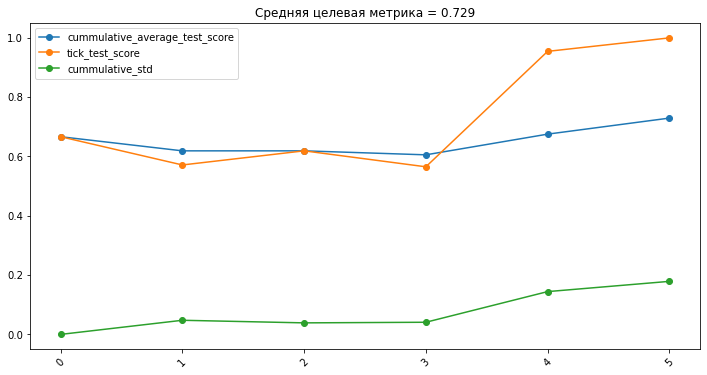

In [93]:
metric_table = stat_time_series_4hours_window_cv(mask_df, 'hours4max2_shift_year', 'max_ec_lim_hour', test_cv_indices)
metric_visual(metric_table)

In [94]:
display(metric_table)
results_test_tyumen['stat_model_1'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.666667         0.666667         0.000000
1                        0.619048         0.571429         0.047619
2                        0.619048         0.619048         0.038881
3                        0.605590         0.565217         0.040952
4                        0.675381         0.954545         0.144308
5                        0.729484         1.000000         0.178857

In [95]:
results_test_tyumen

baseline  stat_model_1
0  0.666667      0.666667
1  0.380952      0.571429
2  0.380952      0.619048
3  0.565217      0.565217
4  0.954545      0.954545
5  1.000000      1.000000

## Stat model 2

Создадим новый признак - день недели. Подчистим его и используем в группировках.  
В данных есть три дня, которые являюься субботами. Заменим эти значения на ближайшее - на пятницу(4)

In [96]:
df['weekday'] = df['date'].dt.weekday
df.loc[df['weekday'] == 5, 'weekday'] = 4

<AxesSubplot:xlabel='max_ec_hour', ylabel='Density'>

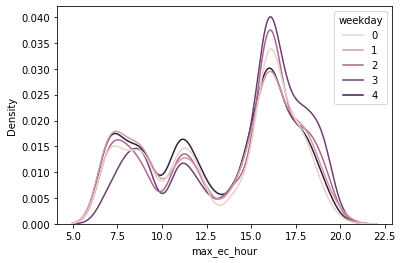

In [97]:
sns.kdeplot(
    data = df,
    hue = 'weekday',
    x = 'max_ec_hour'
)

<AxesSubplot:xlabel='weekday', ylabel='max_ec_hour'>

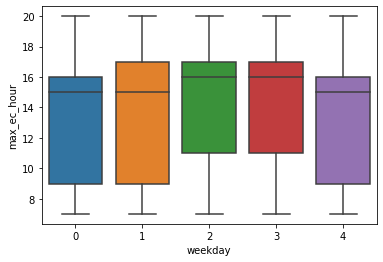

In [98]:
sns.boxplot(
    data = df,
    x = 'weekday',
    y = 'max_ec_hour'
)

Оформим признак как начало недели, середина и конец.

In [99]:
df.loc[df['weekday'].isin([0,1]), 'weekday'] = 0
df.loc[df['weekday'].isin([2,3]), 'weekday'] = 1
df.loc[df['weekday'] == 4, 'weekday'] = 2

In [100]:
yms_max_ec_stat = pd.DataFrame()
for indx in df.groupby(['year', 'month','weekday','subject']):
        year = indx[0][0]
        month = indx[0][1]
        weekday = indx[0][2]
        subject = indx[0][3]

        temp_df = df[(df['year'] == year) & (df['month'] == month) & (df['subject'] == subject) & (df['weekday'] == weekday)].groupby(['year','month', 'weekday', 'subject','hour'], as_index = False)['max_ec'].mean()
        temp_df['window_sum'] = temp_df['max_ec'].rolling(window=4).sum().fillna(0)
        temp_df['hours4max'] = temp_df.sort_values(by = ['window_sum','hour'], ascending= [False, True]).iloc[0]['hour']
        yms_max_ec_stat = pd.concat([yms_max_ec_stat, temp_df[['year', 'month', 'weekday','subject','hours4max']].drop_duplicates()])

yms_max_ec_stat = yms_max_ec_stat.sort_values(by = ['year', 'month'])

shift_step = 12 * yms_max_ec_stat['subject'].nunique() * yms_max_ec_stat['weekday'].nunique()
yms_max_ec_stat['hours4max3_shift_year'] = yms_max_ec_stat['hours4max'].shift(shift_step)

In [101]:
# проверим
yms_max_ec_stat[(yms_max_ec_stat['weekday'] == 0) & (yms_max_ec_stat['month'] == 8) & (yms_max_ec_stat['subject'] == 'Пермский край')]

year  month  weekday        subject  hours4max  hours4max3_shift_year
0  2020      8        0  Пермский край         12                    NaN
0  2021      8        0  Пермский край         12                   12.0
0  2022      8        0  Пермский край         12                   12.0

In [102]:
yms_max_ec_stat

year  month  weekday            subject  hours4max  hours4max3_shift_year
0   2019      9        0      Пермский край         12                    NaN
0   2019      9        0  Тюменская область         18                    NaN
0   2019      9        1      Пермский край         19                    NaN
0   2019      9        1  Тюменская область         18                    NaN
0   2019      9        2      Пермский край         19                    NaN
..   ...    ...      ...                ...        ...                    ...
0   2022     10        0  Тюменская область         17                   17.0
0   2022     10        1      Пермский край          8                   17.0
0   2022     10        1  Тюменская область         16                   17.0
0   2022     10        2      Пермский край          9                   17.0
0   2022     10        2  Тюменская область         16                   17.0

[228 rows x 6 columns]

In [103]:
df_naive_model_2 = pd.merge(
    df[['year', 'month', 'day', 'weekday', 'subject', 'date_months','max_ec_lim_hour']], 
    yms_max_ec_stat[['year', 'month', 'subject', 'hours4max3_shift_year', 'weekday']],
    on = ['year', 'month', 'subject', 'weekday'], how = 'left'
    ).dropna().drop_duplicates().reset_index(drop = True)

### Прогноз и оценка прогноза.

In [104]:
df_model = df_naive_model_2
pred_col = 'hours4max3_shift_year'
target_col = 'max_ec_lim_hour'

#### Общий результат

In [105]:
enc_ticks = LabelEncoder()
time_series_ticks = pd.Series(enc_ticks.fit_transform(df_model['date_months']))

val_cv_indices = time_series_cv_indices(
    df_model, 
    time_series_ticks, 
    0, time_series_ticks.max() - 6, time_series_ticks.max() - 6 - 8)

test_cv_indices = time_series_cv_indices(
    df_model, 
    time_series_ticks, 
    0, time_series_ticks.max(), time_series_ticks.max() - 6)

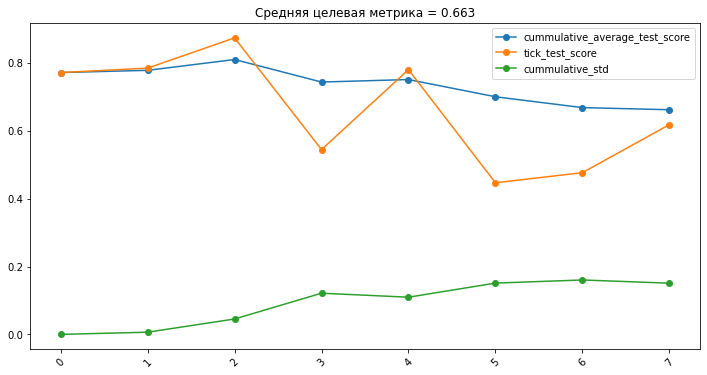

In [106]:
metric_table = stat_time_series_4hours_window_cv(df_model, pred_col, target_col, val_cv_indices)
metric_visual(metric_table)

In [107]:
display(metric_table)
results_cv['stat_model_2'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.772727         0.772727         0.000000
1                        0.779221         0.785714         0.006494
2                        0.811147         0.875000         0.045461
3                        0.744724         0.545455         0.121598
4                        0.752029         0.781250         0.109738
5                        0.701252         0.447368         0.151416
6                        0.669255         0.477273         0.160606
7                        0.662979         0.619048         0.151148

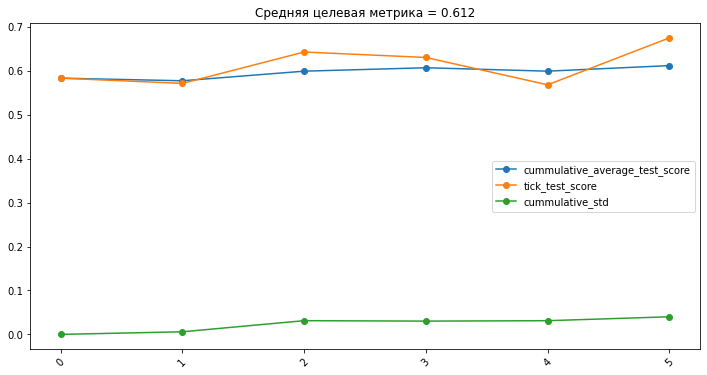

In [108]:
metric_table = stat_time_series_4hours_window_cv(df_model, pred_col, target_col, test_cv_indices)
metric_visual(metric_table)

In [109]:
display(metric_table)
results_test['stat_model_2'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.583333         0.583333         0.000000
1                        0.577381         0.571429         0.005952
2                        0.599206         0.642857         0.031246
3                        0.607013         0.630435         0.030250
4                        0.599247         0.568182         0.031198
5                        0.611873         0.675000         0.040101

#### Пермский край

In [110]:
enc_ticks = LabelEncoder()
time_series_ticks = pd.Series(enc_ticks.fit_transform(df_model['date_months']))

mask_df = df_model[df_model['subject'] == 'Пермский край']

val_cv_indices = time_series_cv_indices(
    mask_df, 
    time_series_ticks, 
    0, 19, 11)

test_cv_indices = time_series_cv_indices(
    mask_df, 
    time_series_ticks, 
    0, 25, 19)

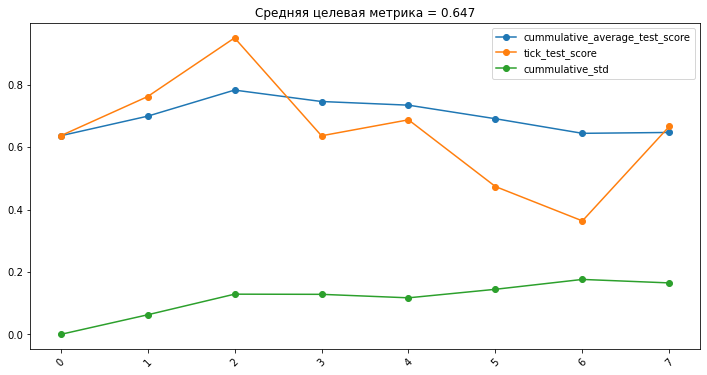

In [111]:
metric_table = stat_time_series_4hours_window_cv(mask_df, pred_col, target_col, val_cv_indices)
metric_visual(metric_table)

In [112]:
display(metric_table)
results_cv_perm['stat_model_2'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.636364         0.636364         0.000000
1                        0.699134         0.761905         0.062771
2                        0.782756         0.950000         0.128888
3                        0.746158         0.636364         0.128364
4                        0.734426         0.687500         0.117185
5                        0.690969         0.473684         0.144521
6                        0.644208         0.363636         0.176132
7                        0.647015         0.666667         0.164924

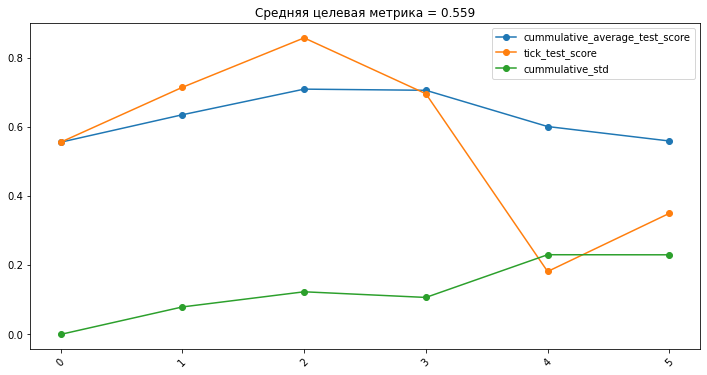

In [113]:
metric_table = stat_time_series_4hours_window_cv(mask_df, pred_col, target_col, test_cv_indices)
metric_visual(metric_table)

In [114]:
display(metric_table)
results_test_perm['stat_model_2'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.555556         0.555556         0.000000
1                        0.634921         0.714286         0.079365
2                        0.708995         0.857143         0.123179
3                        0.705659         0.695652         0.106833
4                        0.600891         0.181818         0.230296
5                        0.559076         0.350000         0.230085

#### Тюменская область

In [115]:
enc_ticks = LabelEncoder()
time_series_ticks = pd.Series(enc_ticks.fit_transform(df_model['date_months']))

mask_df = df_model[df_model['subject'] == 'Тюменская область']

val_cv_indices = time_series_cv_indices(
    mask_df, 
    time_series_ticks, 
    0, 19, 11)

test_cv_indices = time_series_cv_indices(
    mask_df, 
    time_series_ticks, 
    0, 25, 19)

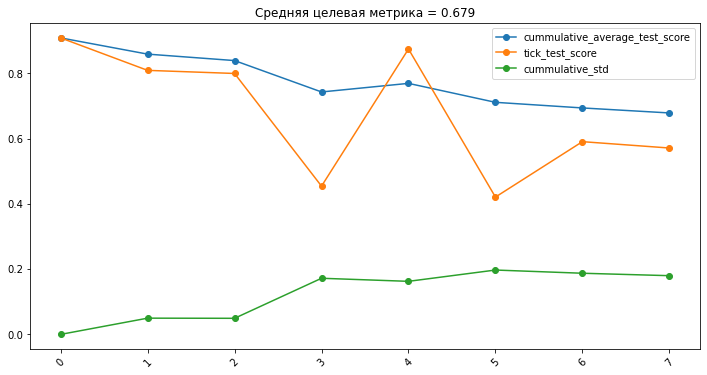

In [116]:
metric_table = stat_time_series_4hours_window_cv(mask_df, pred_col, target_col, val_cv_indices)
metric_visual(metric_table)

In [117]:
display(metric_table)
results_cv_tyumen['stat_model_2'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.909091         0.909091         0.000000
1                        0.859307         0.809524         0.049784
2                        0.839538         0.800000         0.049335
3                        0.743290         0.454545         0.172095
4                        0.769632         0.875000         0.162693
5                        0.711535         0.421053         0.197316
6                        0.694303         0.590909         0.187492
7                        0.678944         0.571429         0.180029

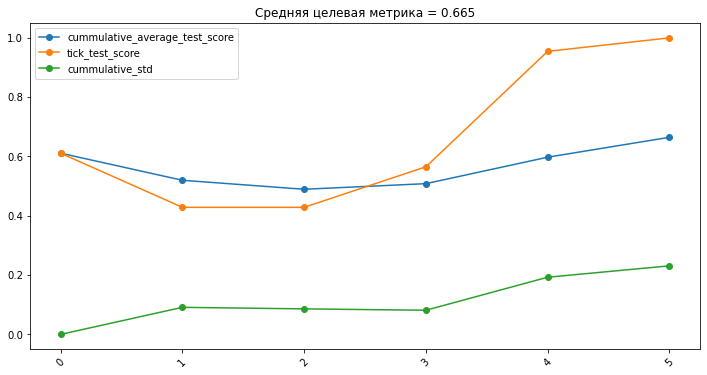

In [118]:
metric_table = stat_time_series_4hours_window_cv(mask_df, pred_col, target_col, test_cv_indices)
metric_visual(metric_table)

In [119]:
display(metric_table)
results_test_tyumen['stat_model_2'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.611111         0.611111         0.000000
1                        0.519841         0.428571         0.091270
2                        0.489418         0.428571         0.086050
3                        0.508368         0.565217         0.081429
4                        0.597603         0.954545         0.192760
5                        0.664669         1.000000         0.231199

## Stat model 3

Создадим новый признак - ~ середина месяца.

In [120]:
df['half_month'] = np.where(df['day'] > 16, 1, 0)

In [121]:
df['half_month'].value_counts(normalize = True)

1    0.501961
0    0.498039
Name: half_month, dtype: float64

<AxesSubplot:xlabel='half_month', ylabel='max_ec_hour'>

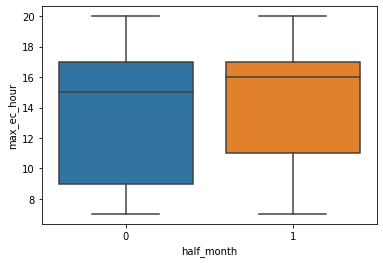

In [122]:
sns.boxplot(
    data = df,
    x = 'half_month',
    y = 'max_ec_hour'
)

In [123]:
yms_max_ec_stat = pd.DataFrame()
for indx in df.groupby(['year', 'month','half_month','subject']):
        year = indx[0][0]
        month = indx[0][1]
        half_month = indx[0][2]
        subject = indx[0][3]

        temp_df = df[(df['year'] == year) & (df['month'] == month) & (df['subject'] == subject) & (df['half_month'] == half_month)].groupby(['year','month', 'half_month', 'subject','hour'], as_index = False)['new_class'].mean()
        temp_df['window_sum'] = temp_df['new_class'].rolling(window=4).sum().fillna(0)
        temp_df['hours4max'] = temp_df.sort_values(by = ['window_sum','hour'], ascending= [False, True]).iloc[0]['hour']
        yms_max_ec_stat = pd.concat([yms_max_ec_stat, temp_df[['year', 'month', 'half_month','subject','hours4max']].drop_duplicates()])

yms_max_ec_stat = yms_max_ec_stat.sort_values(by = ['year', 'month'])

shift_step = 12 * yms_max_ec_stat['subject'].nunique() * yms_max_ec_stat['half_month'].nunique()
yms_max_ec_stat['hours4max4_shift_year'] = yms_max_ec_stat['hours4max'].shift(shift_step)

In [124]:
# проверим
yms_max_ec_stat[(yms_max_ec_stat['half_month'] == 0) & (yms_max_ec_stat['month'] == 8) & (yms_max_ec_stat['subject'] == 'Пермский край')]

year  month  half_month        subject  hours4max  hours4max4_shift_year
0  2020      8           0  Пермский край         13                    NaN
0  2021      8           0  Пермский край         13                   13.0
0  2022      8           0  Пермский край         12                   13.0

In [125]:
df_naive_model_3 = pd.merge(
    df[['year', 'month', 'day', 'half_month', 'subject', 'date_months','max_ec_lim_hour']], 
    yms_max_ec_stat[['year', 'month', 'subject', 'hours4max4_shift_year', 'half_month']],
    on = ['year', 'month', 'subject', 'half_month'], how = 'left'
    ).dropna().drop_duplicates().reset_index(drop = True)

### Прогноз и оценка прогноза.

In [126]:
df_model = df_naive_model_3
pred_col = 'hours4max4_shift_year'
target_col = 'max_ec_lim_hour'

#### Общий результат

In [127]:
enc_ticks = LabelEncoder()
time_series_ticks = pd.Series(enc_ticks.fit_transform(df_model['date_months']))

val_cv_indices = time_series_cv_indices(
    df_model, 
    time_series_ticks, 
    0, time_series_ticks.max() - 6, time_series_ticks.max() - 6 - 8)

test_cv_indices = time_series_cv_indices(
    df_model, 
    time_series_ticks, 
    0, time_series_ticks.max(), time_series_ticks.max() - 6)

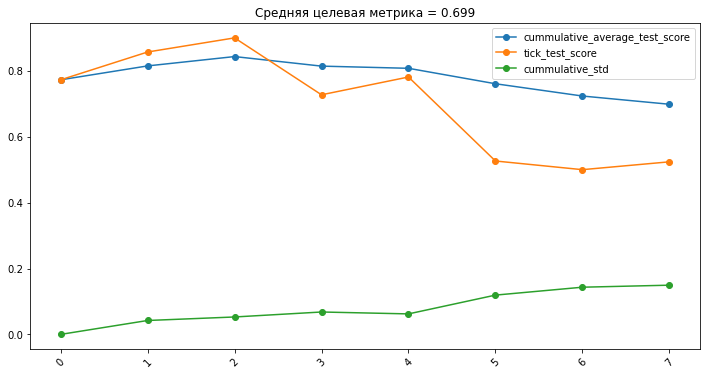

In [128]:
metric_table = stat_time_series_4hours_window_cv(df_model, pred_col, target_col, val_cv_indices)
metric_visual(metric_table)

In [129]:
display(metric_table)
results_cv['stat_model_3'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.772727         0.772727         0.000000
1                        0.814935         0.857143         0.042208
2                        0.843290         0.900000         0.052874
3                        0.814286         0.727273         0.067974
4                        0.807679         0.781250         0.062218
5                        0.760785         0.526316         0.119252
6                        0.723530         0.500000         0.143238
7                        0.698565         0.523810         0.149383

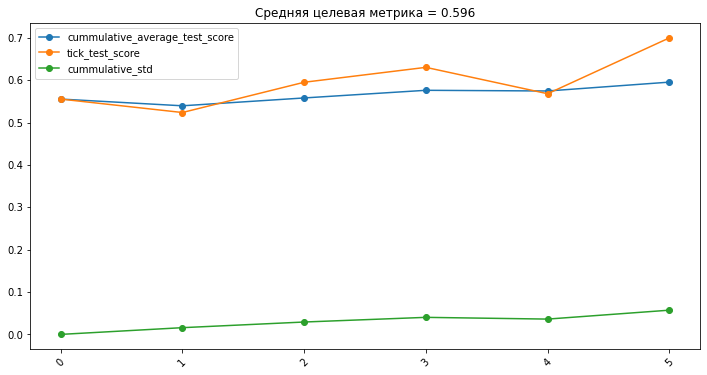

In [130]:
metric_table = stat_time_series_4hours_window_cv(df_model, pred_col, target_col, test_cv_indices)
metric_visual(metric_table)

In [131]:
display(metric_table)
results_test['stat_model_3'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.555556         0.555556         0.000000
1                        0.539683         0.523810         0.015873
2                        0.558201         0.595238         0.029221
3                        0.576259         0.630435         0.040233
4                        0.574644         0.568182         0.036130
5                        0.595537         0.700000         0.057187

#### Пермский край

In [132]:
enc_ticks = LabelEncoder()
time_series_ticks = pd.Series(enc_ticks.fit_transform(df_model['date_months']))

mask_df = df_model[df_model['subject'] == 'Пермский край']

val_cv_indices = time_series_cv_indices(
    mask_df, 
    time_series_ticks, 
    0, 19, 11)

test_cv_indices = time_series_cv_indices(
    mask_df, 
    time_series_ticks, 
    0, 25, 19)

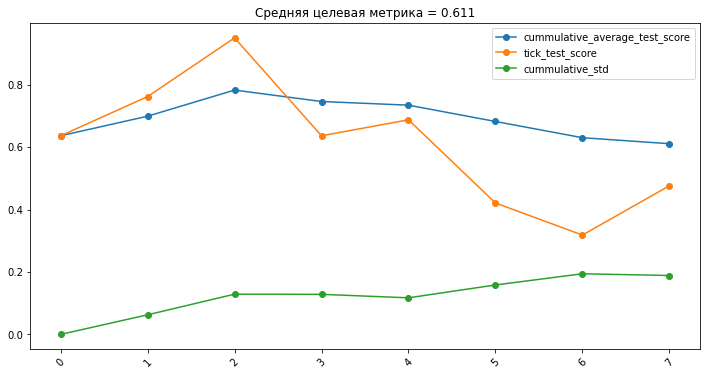

In [133]:
metric_table = stat_time_series_4hours_window_cv(mask_df, pred_col, target_col, val_cv_indices)
metric_visual(metric_table)

In [134]:
display(metric_table)
results_cv_perm['stat_model_3'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.636364         0.636364         0.000000
1                        0.699134         0.761905         0.062771
2                        0.782756         0.950000         0.128888
3                        0.746158         0.636364         0.128364
4                        0.734426         0.687500         0.117185
5                        0.682197         0.421053         0.158376
6                        0.630195         0.318182         0.194229
7                        0.610945         0.476190         0.188689

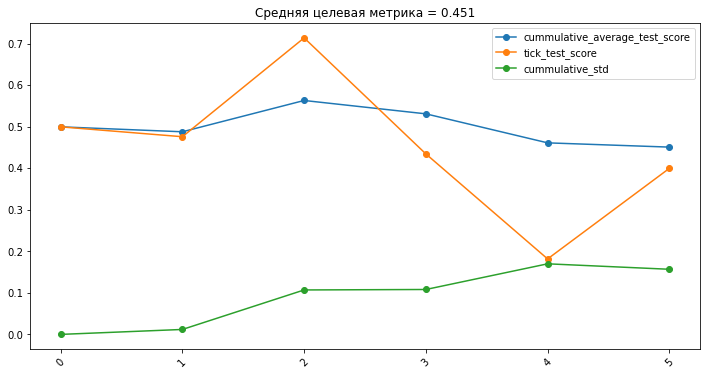

In [135]:
metric_table = stat_time_series_4hours_window_cv(mask_df, pred_col, target_col, test_cv_indices)
metric_visual(metric_table)

In [136]:
display(metric_table)
results_test_perm['stat_model_3'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.500000         0.500000         0.000000
1                        0.488095         0.476190         0.011905
2                        0.563492         0.714286         0.107069
3                        0.531315         0.434783         0.108185
4                        0.461415         0.181818         0.170020
5                        0.451179         0.400000         0.156885

#### Тюменская область

In [137]:
enc_ticks = LabelEncoder()
time_series_ticks = pd.Series(enc_ticks.fit_transform(df_model['date_months']))

mask_df = df_model[df_model['subject'] == 'Тюменская область']

val_cv_indices = time_series_cv_indices(
    mask_df, 
    time_series_ticks, 
    0, 19, 11)

test_cv_indices = time_series_cv_indices(
    mask_df, 
    time_series_ticks, 
    0, 25, 19)

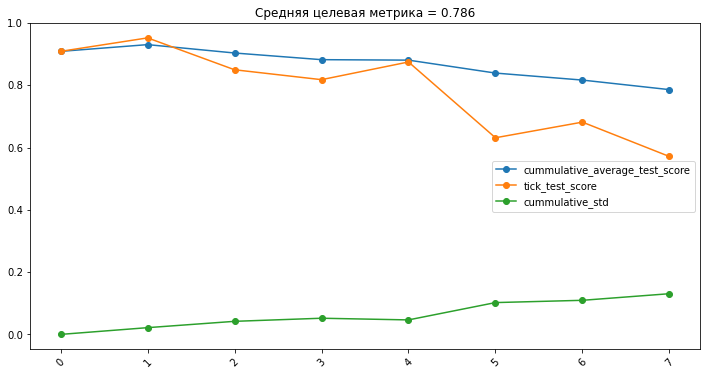

In [138]:
metric_table = stat_time_series_4hours_window_cv(mask_df, pred_col, target_col, val_cv_indices)
metric_visual(metric_table)

In [139]:
display(metric_table)
results_cv_tyumen['stat_model_3'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.909091         0.909091         0.000000
1                        0.930736         0.952381         0.021645
2                        0.903824         0.850000         0.041962
3                        0.882413         0.818182         0.051922
4                        0.880931         0.875000         0.046535
5                        0.839372         0.631579         0.102177
6                        0.816864         0.681818         0.109491
7                        0.786185         0.571429         0.130684

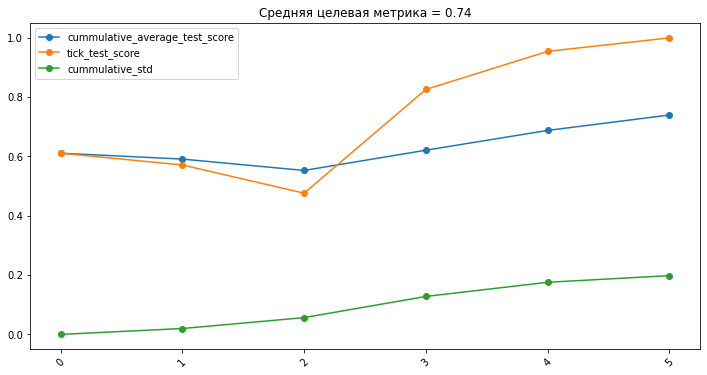

In [140]:
metric_table = stat_time_series_4hours_window_cv(mask_df, pred_col, target_col, test_cv_indices)
metric_visual(metric_table)

In [141]:
display(metric_table)
results_test_tyumen['stat_model_3'] = metric_table['tick_test_score']

cummulative_average_test_score  tick_test_score  cummulative_std
0                        0.611111         0.611111         0.000000
1                        0.591270         0.571429         0.019841
2                        0.552910         0.476190         0.056616
3                        0.621204         0.826087         0.128048
4                        0.687873         0.954545         0.175772
5                        0.739894         1.000000         0.198185

## LogisticRegression

Построим логистическую регрессию на той информации, которая у нас есть.  
Сделаем некоторые преобразования с существующими признаками.  
Будем использовать даты, субъекты и преобразованные предсказания эталонной модели.  

In [142]:
# объеденим признаки и предсказания предыдущих моделей
df_naive_logistic = df[['year', 'month', 'day', 'hour','subject','date_months', 'max_ec', 'new_class', 'max_ec_lim', 'max_ec_hour', 'max_ec_lim_hour','half_day_distance', 'ec_interval_flag']]
for merge_df in [df_baseline, df_naive_model_1, df_naive_model_2, df_naive_model_3,]:
    df_naive_logistic = df_naive_logistic.merge(
    merge_df, 
    on = ['year', 'month', 'day','subject','date_months' , 'max_ec_lim_hour'],
    how = 'left')

In [143]:
df_naive_logistic = df_naive_logistic[df_naive_logistic['hour'].isin(range(7, 21))].dropna().drop_duplicates().reset_index(drop = True)

In [144]:
# отметим предсказанные часы предыдущими моделями
for prediction in ['hours4max_shift_year', 'hours4max2_shift_year', 'hours4max3_shift_year', 'hours4max4_shift_year']:
    df_naive_logistic[prediction + str('_flag')] = np.where(
        (df_naive_logistic['hour'] <= df_naive_logistic[prediction]) & (df_naive_logistic['hour'] >= df_naive_logistic[prediction] - 3), 1, 0)

Сделаем ещё несколько преобразований с предсказаниями.

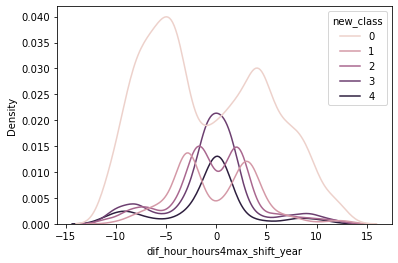

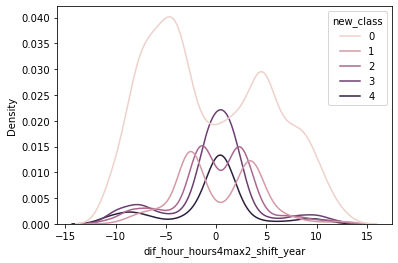

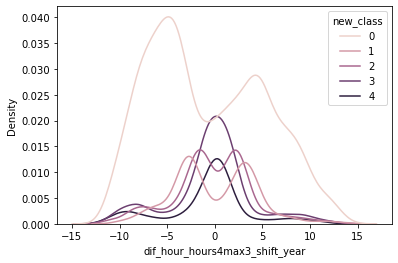

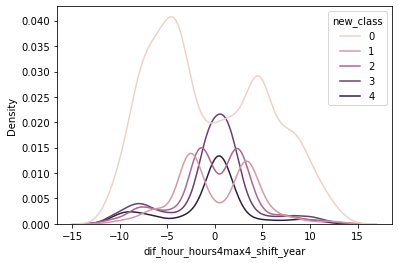

In [145]:
for prediction in ['hours4max_shift_year', 'hours4max2_shift_year', 'hours4max3_shift_year', 'hours4max4_shift_year']:
    df_naive_logistic['dif_hour_' + prediction] = df_naive_logistic['hour']  - df_naive_logistic[prediction]
    
    #сдвинем распределение на 0 относительно класса 4
    df_naive_logistic['dif_hour_' + prediction] = df_naive_logistic['dif_hour_' + prediction] - df_naive_logistic.loc[df_naive_logistic['new_class'] == 4,'dif_hour_' + prediction].median()
    
    sns.kdeplot(
    data = df_naive_logistic,
    x = 'dif_hour_' + prediction,
    hue = 'new_class')
    plt.show()

Мы видим, что все предсказания статистических моделей в принципе справляются с базовой задачей:  
чем сильнее различается предсказанный час и наблюдаемый, тем ниже вероятность наступления часа с пиковым потреблением 

Отбросим знаки, возьмём модуль. Станут ли классы лучше разделимы.

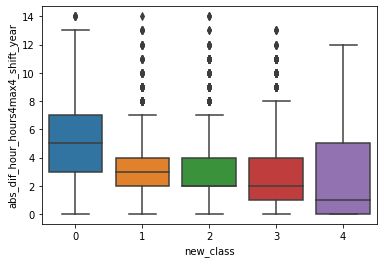

In [146]:
for prediction in ['hours4max_shift_year', 'hours4max2_shift_year', 'hours4max3_shift_year', 'hours4max4_shift_year']:
    df_naive_logistic['abs_dif_hour_' + prediction] =  np.abs(df_naive_logistic['dif_hour_' + prediction])

sns.boxplot(
    data = df_naive_logistic,
    y = 'abs_dif_hour_' + prediction,
    x = 'new_class'
)
plt.show()

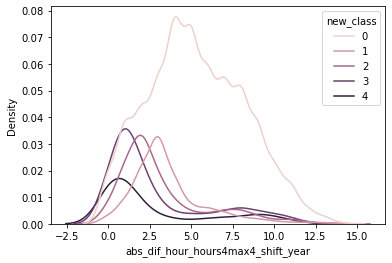

In [147]:
sns.kdeplot(
    data = df_naive_logistic,
    x = 'abs_dif_hour_' + prediction,
    hue = 'new_class'
)
plt.show()

Мы сделали несколько похожих признаков. Избавимся от сильно коррелирующих.  
Для линейной модели это будет полезно.

In [148]:
# часть признаков мы уже перекодировали, избавимся от них тоже
df_naive_logistic = df_naive_logistic.drop(['hours4max_shift_year', 'hours4max2_shift_year', 
    'hours4max3_shift_year', 'hours4max4_shift_year'], axis = 1)

In [149]:
correls = np.round(df_naive_logistic[['half_day_distance',
     'half_month',
    'dif_hour_hours4max_shift_year', 'dif_hour_hours4max2_shift_year',
    'dif_hour_hours4max3_shift_year', 'dif_hour_hours4max4_shift_year', 
    'abs_dif_hour_hours4max_shift_year',
    'abs_dif_hour_hours4max2_shift_year',
    'abs_dif_hour_hours4max3_shift_year',
    'abs_dif_hour_hours4max4_shift_year', 'new_class']].corr(),3)

In [150]:
high_corr_cols = list(correls[(correls > 0.8) & (correls < 1)].sum()[correls[(correls > 0.8) & (correls < 1)].sum() > 0].index)

In [151]:
correls.loc[high_corr_cols + ['new_class'], high_corr_cols + ['new_class']]

dif_hour_hours4max_shift_year  \
dif_hour_hours4max_shift_year                               1.000   
dif_hour_hours4max2_shift_year                              0.965   
dif_hour_hours4max3_shift_year                              0.853   
dif_hour_hours4max4_shift_year                              0.818   
abs_dif_hour_hours4max_shift_year                          -0.100   
abs_dif_hour_hours4max2_shift_year                         -0.034   
new_class                                                   0.025   

                                    dif_hour_hours4max2_shift_year  \
dif_hour_hours4max_shift_year                                0.965   
dif_hour_hours4max2_shift_year                               1.000   
dif_hour_hours4max3_shift_year                               0.841   
dif_hour_hours4max4_shift_year                               0.820   
abs_dif_hour_hours4max_shift_year                           -0.121   
abs_dif_hour_hours4max2_shift_year                          -0.043   
new_class                                                    0.026   

                                    dif_hour_hours4max3_shift_year  \
dif_hour_hours4max_shift_year                                0.853   
dif_hour_hours4max2_shift_year                               0.841   
dif_hour_hours4max3_shift_year                               1.000   
dif_hour_hours4max4_shift_year                               0.788   
abs_dif_hour_hours4max_shift_year                           -0.129   
abs_dif_hour_hours4max2_shift_year                          -0.067   
new_class                                                    0.024   

                                    dif_hour_hours4max4_shift_year  \
dif_hour_hours4max_shift_year                                0.818   
dif_hour_hours4max2_shift_year                               0.820   
dif_hour_hours4max3_shift_year                               0.788   
dif_hour_hours4max4_shift_year                               1.000   
abs_dif_hour_hours4max_shift_year                           -0.124   
abs_dif_hour_hours4max2_shift_year                          -0.067   
new_class                                                    0.023   

                                    abs_dif_hour_hours4max_shift_year  \
dif_hour_hours4max_shift_year                                  -0.100   
dif_hour_hours4max2_shift_year                                 -0.121   
dif_hour_hours4max3_shift_year                                 -0.129   
dif_hour_hours4max4_shift_year                                 -0.124   
abs_dif_hour_hours4max_shift_year                               1.000   
abs_dif_hour_hours4max2_shift_year                              0.925   
new_class                                                      -0.331   

                                    abs_dif_hour_hours4max2_shift_year  \
dif_hour_hours4max_shift_year                                   -0.034   
dif_hour_hours4max2_shift_year                                  -0.043   
dif_hour_hours4max3_shift_year                                  -0.067   
dif_hour_hours4max4_shift_year                                  -0.067   
abs_dif_hour_hours4max_shift_year                                0.925   
abs_dif_hour_hours4max2_shift_year                               1.000   
new_class                                                       -0.340   

                                    new_class  
dif_hour_hours4max_shift_year           0.025  
dif_hour_hours4max2_shift_year          0.026  
dif_hour_hours4max3_shift_year          0.024  
dif_hour_hours4max4_shift_year          0.023  
abs_dif_hour_hours4max_shift_year      -0.331  
abs_dif_hour_hours4max2_shift_year     -0.340  
new_class                               1.000

In [152]:
df_naive_logistic = df_naive_logistic.drop([
    'abs_dif_hour_hours4max_shift_year', 'dif_hour_hours4max_shift_year',
    'dif_hour_hours4max4_shift_year', 'dif_hour_hours4max3_shift_year'], axis = 1)

In [153]:
# предобработаем категориальные признаки
df_naive_logistic_pre = pd.concat([
    df_naive_logistic,
    pd.get_dummies(
            data = df_naive_logistic[['year', 'month', 'day', 'hour', 'subject', 'weekday']], 
            columns = ['year', 'month', 'day', 'hour', 'subject', 'weekday'])], axis = 1).drop(['subject'], axis = 1)

In [154]:
# подготовим список фичей и присвоим таргеты

features = df_naive_logistic_pre.columns.drop([
    'max_ec', 'max_ec_lim', 'max_ec_lim_hour', 'date_months', 
    'ec_interval_flag', 'new_class', 'max_ec_hour', #'date_months_le',

    ])

# для лог.регрессии предсказываем просто максимальный час
target = 'max_ec'

### Обучение. Прогноз и оценка

In [155]:
# нормализуем данные, выделим данные для обучения и метки
scl = StandardScaler()
scl.fit(df_naive_logistic_pre[features])

X_train = pd.DataFrame(
    data = scl.transform(df_naive_logistic_pre[features]),
    columns = features
    )

# y_train = df_naive_logistic_pre[target]

In [156]:
enc_ticks = LabelEncoder()

df_naive_logistic['date_months_le'] = enc_ticks.fit_transform(df_naive_logistic['date_months'])
time_series_ticks = df_naive_logistic['date_months_le']

# минимальная обучающая выборка = 12 месяцев,
# кросс валидация с 12го по 19ый
# тестирование с 19 по 25ый

# индексы для кросс валидации на временных рядах
val_cv_indices = time_series_cv_indices(
    df_naive_logistic, 
    time_series_ticks, 
    0, 19, 11)

# индексы для тестирования на временных рядах
test_cv_indices = time_series_cv_indices(
    df_naive_logistic, 
    time_series_ticks, 
    0, 25, 19)

#### Общий

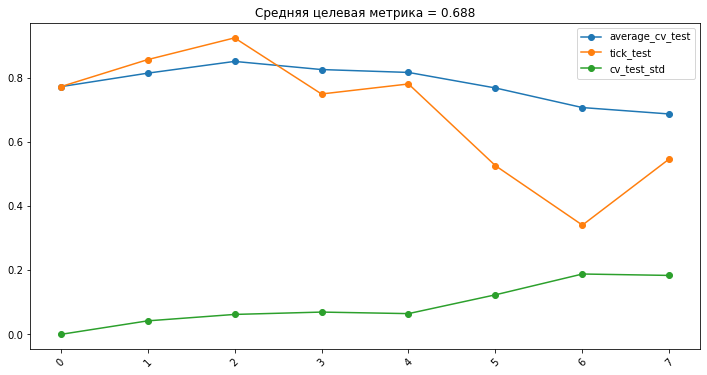

In [157]:
model = LogisticRegression()
metric_table = time_series_cv_cl_scores(
    model, 
    val_cv_indices,
    X_train,
    features,
    target,
    df_naive_logistic,
    ['Тюменская область', 'Пермский край']
    )
    
metric_visual(metric_table.iloc[:, :3])

In [158]:
display(metric_table)
results_cv['LogisticRegression'] = metric_table['tick_test']

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.772727   0.772727     0.000000      0.822910            0.822910   
1         0.814935   0.857143     0.042208      0.886011            0.854460   
2         0.851623   0.925000     0.062287      0.894952            0.867958   
3         0.826218   0.750000     0.069614      0.861292            0.866291   
4         0.817224   0.781250     0.064811      0.901743            0.873382   
5         0.768739   0.526316     0.123508      0.806147            0.862176   
6         0.707621   0.340909     0.188382      0.763708            0.848109   
7         0.687621   0.547619     0.183989      0.873147            0.851239   

   tick_f1_score  average_cv_f1_score  
0          0.000             0.000000  
1          0.000             0.000000  
2          0.000             0.000000  
3          0.000             0.000000  
4          0.000             0.000000  
5          0.000             0.000000  
6          0.000             0.000000  
7          0.125             0.015625

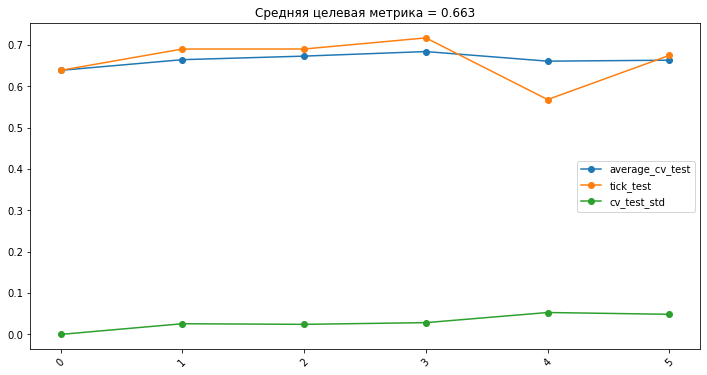

In [159]:
metric_table = time_series_cv_cl_scores(
    model, 
    test_cv_indices,
    X_train,
    features,
    target,
    df_naive_logistic,
    ['Тюменская область', 'Пермский край']
    )
    
metric_visual(metric_table.iloc[:, :3])

In [160]:
display(metric_table)
results_test['LogisticRegression'] = metric_table['tick_test']

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.638889   0.638889     0.000000      0.789945            0.789945   
1         0.664683   0.690476     0.025794      0.757108            0.773527   
2         0.673280   0.690476     0.024318      0.755058            0.767371   
3         0.684308   0.717391     0.028432      0.758107            0.765055   
4         0.661083   0.568182     0.052956      0.778171            0.767678   
5         0.663402   0.675000     0.048620      0.854327            0.782119   

   tick_f1_score  average_cv_f1_score  
0       0.142857             0.142857  
1       0.000000             0.071429  
2       0.000000             0.047619  
3       0.000000             0.035714  
4       0.000000             0.028571  
5       0.000000             0.023810

#### Пермский край

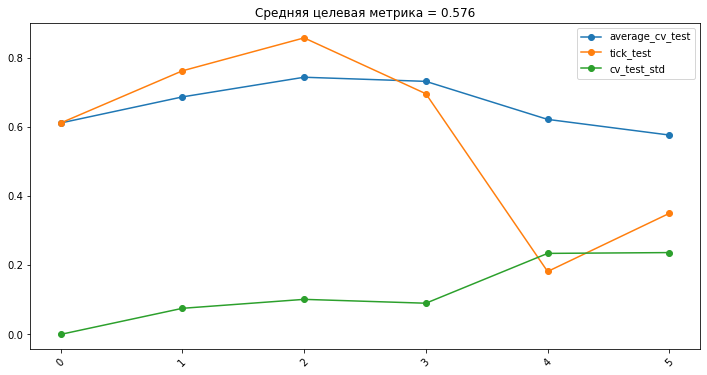

In [161]:
metric_table = time_series_cv_cl_scores(
    model, 
    test_cv_indices,
    X_train,
    features,
    target,
    df_naive_logistic,
    ['Пермский край']
    )
    
metric_visual(metric_table.iloc[:, :3])

In [162]:
display(metric_table)
results_test_perm['LogisticRegression'] = metric_table['tick_test']

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.611111   0.611111     0.000000      0.722222            0.722222   
1         0.686508   0.761905     0.075397      0.766440            0.744331   
2         0.743386   0.857143     0.101292      0.812664            0.767109   
3         0.731453   0.695652     0.090124      0.694053            0.748845   
4         0.621526   0.181818     0.234166      0.615544            0.722184   
5         0.576272   0.350000     0.236504      0.719808            0.721788   

   tick_f1_score  average_cv_f1_score  
0            0.0                  0.0  
1            0.0                  0.0  
2            0.0                  0.0  
3            0.0                  0.0  
4            0.0                  0.0  
5            0.0                  0.0

#### Тюмень

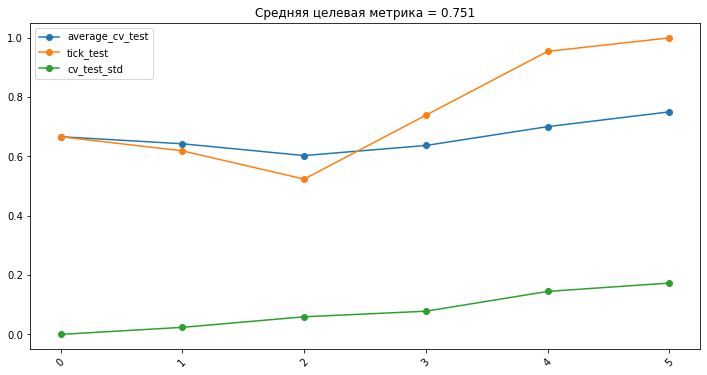

In [163]:
metric_table = time_series_cv_cl_scores(
    model, 
    test_cv_indices,
    X_train,
    features,
    target,
    df_naive_logistic,
    ['Тюменская область']
    )
    
metric_visual(metric_table.iloc[:, :3])

In [164]:
display(metric_table)
results_test_tyumen['LogisticRegression'] = metric_table['tick_test']

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.666667   0.666667     0.000000      0.847104            0.847104   
1         0.642857   0.619048     0.023810      0.745334            0.796219   
2         0.603175   0.523810     0.059391      0.691784            0.761407   
3         0.637164   0.739130     0.078174      0.825360            0.777395   
4         0.700640   0.954545     0.144934      0.902575            0.802431   
5         0.750533   1.000000     0.173066      0.988462            0.833436   

   tick_f1_score  average_cv_f1_score  
0           0.25             0.250000  
1           0.00             0.125000  
2           0.00             0.083333  
3           0.00             0.062500  
4           0.00             0.050000  
5           0.00             0.041667

## Преобразование признаков и Feature Engineering

In [165]:
df_fe = df.copy()

У нас есть признаки, которые также можно преобразовать и с которыми также можно сделать преобразования во временных рядах.  
Сделаем minmasx нормализацию потреблённой энергии по часам внутри дня.  
Посчитаем сумму потреблённой энергии в день и посмотрим долю потреблённой энергии в каждый час.

In [166]:
feats = ['energy_consumption'] # 'p1', 'p2', 'p3', 'p4', 'p5', 'p6'
for feat in feats:
    for cols, pre_name in zip([
        ['year','month','day', 'subject']],
        ['ymds']
        ):

        # нормализованная фича по дням

        mapping = df_fe[cols + [feat]].groupby(cols, as_index = False)[feat].max()
        max_feat = pd.merge(df_fe[cols], mapping, on = cols, how = 'left')[feat]

        mapping = df_fe[cols + [feat]].groupby(cols, as_index = False)[feat].min()
        min_feat = pd.merge(df_fe[cols], mapping, on = cols, how = 'left')[feat]
        
        new_feat_name_1 = '_'.join([pre_name, feat, 'minmax'])        
        df_fe[new_feat_name_1] = (df_fe[feat] - min_feat) / (max_feat - min_feat)

        # доля нормализованной фичи в сумме всех значений внутри дня
        mapping = df_fe[cols + [new_feat_name_1]].groupby(cols, as_index = False)[new_feat_name_1].sum()
        new_feat_name_2 = '_'.join([pre_name, feat, 'minmax_day_sum'])
        df_fe[new_feat_name_2] = pd.merge(df_fe[cols], mapping, on = cols, how = 'left')[new_feat_name_1]
        
        new_feat_name_3 = '_'.join([pre_name, new_feat_name_1, 'rat_sum'])  
        df_fe[new_feat_name_3] = df_fe[new_feat_name_1] / df_fe[new_feat_name_2]
        

Посмотрим как измелось распределение признака внутри одного часа по месяцам.

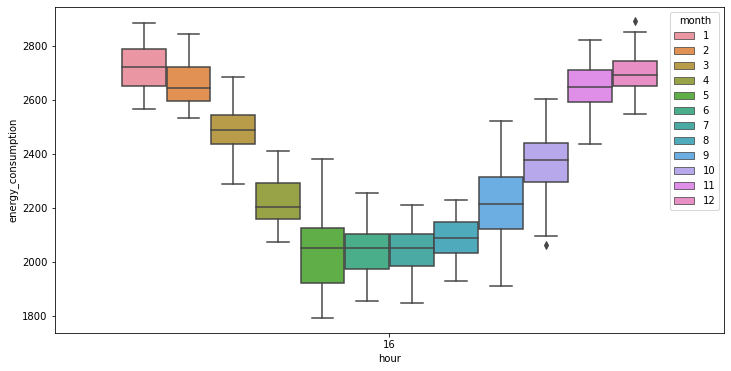

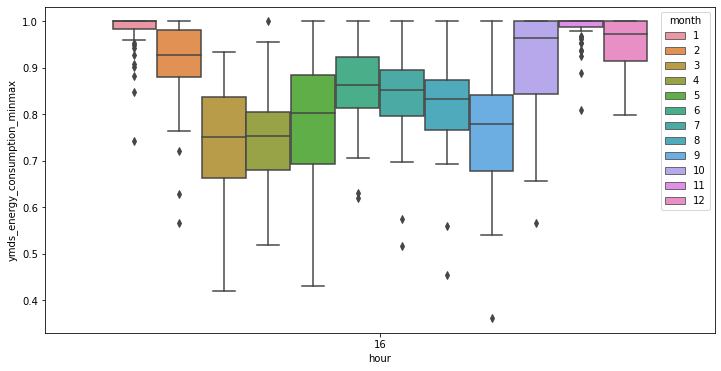

In [167]:
# было
plt.figure(figsize=(12,6))
sns.boxplot(data = df_fe[(df_fe['hour'] == 16) & (df_fe['subject'] == 'Пермский край') ], x = 'hour', y = 'energy_consumption', hue = 'month')
plt.show()

# стало
plt.figure(figsize=(12,6))
sns.boxplot(data = df_fe[(df_fe['hour'] == 16) & (df_fe['subject'] == 'Пермский край') ], x = 'hour', y = 'ymds_energy_consumption_minmax', hue = 'month')
plt.show()

Посмотрим на изменение нового признака по часам в течение нескольких дней с отмеченными максимумами.

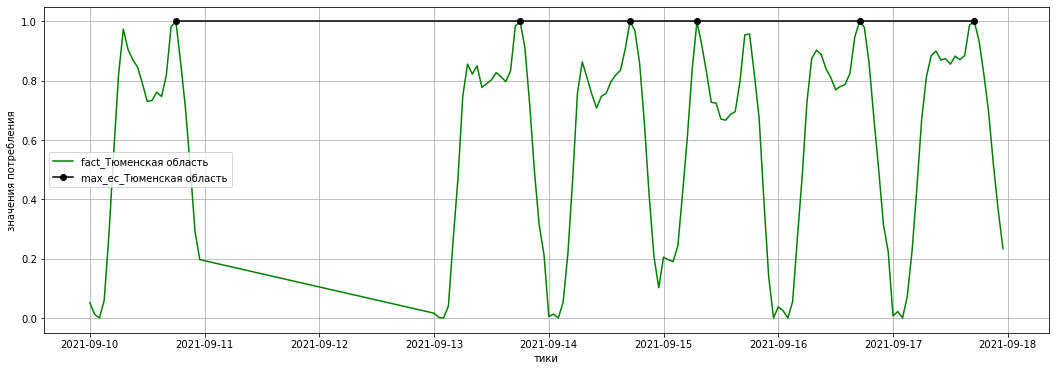

In [168]:
vis = df_fe[(df_fe.year == 2021) & (df_fe.month == 9) & (df_fe.day.isin(np.arange(10, 20)))]

# мастшабируем некоторые значения

t = vis['date'].unique()

ecf_t = vis.loc[vis['subject'] == 'Тюменская область', 'ymds_energy_consumption_minmax'].values
max_ec_t = (vis.loc[(vis['max_ec'] == 1) & (vis['subject'] == 'Тюменская область'), 'max_ec'] * vis.loc[(vis['max_ec'] == 1) & (vis['subject'] == 'Тюменская область'),'ymds_energy_consumption_minmax']).values


plt.figure(figsize= (18, 6))
plt.plot(t, ecf_t, 'g', label = 'fact_Тюменская область')

plt.plot(vis.loc[(vis['max_ec'] == 1) & (vis['subject'] == 'Тюменская область'), 'date'], max_ec_t, 'black', label = 'max_ec_Тюменская область', marker = 'o')

plt.grid()
plt.xlabel('тики')
plt.ylabel('значения потребления')
plt.legend()

Добавим инфомрацию о соседних часах.

In [169]:
for indx in df_fe.groupby(['year', 'month', 'day', 'subject']):
    year = indx[0][0]
    month = indx[0][1]
    day = indx[0][2]
    subject = indx[0][3]

    mask = ((df_fe['year'] == year) & (
        df_fe['month'] == month) & (
            df_fe['day'] == day) & (
                df_fe['subject'] == subject))

    df_fe.loc[mask, 'ymds_energy_consumption_minmax_day_shift_1'] = df_fe[mask]['ymds_energy_consumption_minmax'].shift(1).fillna(0)
    df_fe.loc[mask, 'ymds_energy_consumption_minmax_day_shift_-1'] = df_fe[mask]['ymds_energy_consumption_minmax'].shift(-1).fillna(0)

In [170]:
df_fe['ymds_energy_consumption_minmax_around_sum'] = df_fe[['ymds_energy_consumption_minmax', 'ymds_energy_consumption_minmax_day_shift_1', 'ymds_energy_consumption_minmax_day_shift_-1']].sum(axis = 1)
df_fe['ymds_energy_consumption_minmax_around_sum_ratio_day_sum'] = df_fe['ymds_energy_consumption_minmax_around_sum'] / df_fe['ymds_energy_consumption_minmax_day_sum']

Создадим признак, который копит кумулятивную информацию о потреблении

In [171]:
for indx in df_fe.groupby(['year', 'month', 'day', 'subject']):
    year = indx[0][0]
    month = indx[0][1]
    day = indx[0][2]
    subject = indx[0][3]

    mask = ((df_fe['year'] == year) & (
        df_fe['month'] == month) & (
            df_fe['day'] == day) & (
                df_fe['subject'] == subject))

    df_fe.loc[mask, 'ymds_ymds_energy_consumption_minmax_rat_sum_day_cumsum'] = df_fe[mask]['ymds_ymds_energy_consumption_minmax_rat_sum'].cumsum()

Создадим признак, который показывает насколько текущее потребление опережает равномерное потребление по времени.

In [172]:
df_fe['cumsum_day_ratio'] = df_fe['ymds_ymds_energy_consumption_minmax_rat_sum_day_cumsum'] / ((np.where(df['hour'] < 7, 0, df['hour'] - 6)) / (20-6))
df_fe['cumsum_day_ratio'] = np.where(df_fe['cumsum_day_ratio'] == np.inf, 1, df_fe['cumsum_day_ratio'])

Разобъём день на последовательные интервалы внутри дня по 12, 6, 4 часа

In [173]:
for interval in [12, 6, 4]:
    df_fe['interval_' + str(interval)] = df['hour'] // interval

intervals = ['interval_12', 'interval_6', 'interval_4']

Присвоим номера в порядке возрастания часов.  
Также отметим флагом те часы, которые входят в диапазон максимального потребления энергии.

In [174]:
feat = 'ymds_energy_consumption_minmax'
cols = ['year', 'month', 'day', 'subject', 'hour']
for indx in df_fe.groupby(['year', 'month', 'day', 'subject']):
    year = indx[0][0]
    month = indx[0][1]
    day = indx[0][2]
    subject = indx[0][3]

    mask = ((df_fe['year'] == year) & (
        df_fe['month'] == month) & (
            df_fe['day'] == day) & (
                df_fe['subject'] == subject))

    mapping = df_fe.loc[mask, cols + [feat]].sort_values(by = feat)
    mapping['rank_day'] = np.arange(0, 24)

    interval = np.array(mapping.iloc[-1]['hour'])
    for i in range(1,5):
        interval = mapping[mapping['hour'].isin(range(interval.min() - 1, interval.max() + 2))]['hour'].iloc[-i:]
    mapping['best_interval_flag'] = np.where(mapping['hour'].isin(interval), 1 , 0)

    df_fe.loc[mask, ['rank_day', 'best_interval_flag']] = pd.merge(df_fe[cols], mapping, on = cols, how = 'left')[['rank_day', 'best_interval_flag']]

<AxesSubplot:xlabel='hour', ylabel='rank_day'>

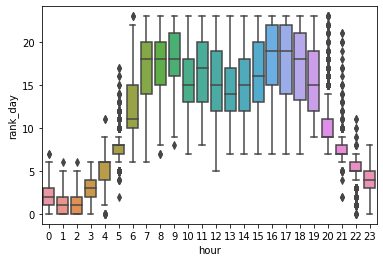

In [175]:
sns.boxplot(
    data = df_fe, 
    x = 'hour',
    y = 'rank_day')

<AxesSubplot:xlabel='hour', ylabel='Density'>

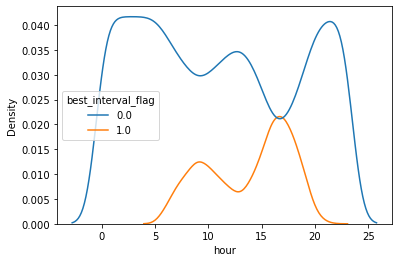

In [176]:
sns.kdeplot(
    data = df_fe, 
    x = 'hour',
    hue = 'best_interval_flag')

<AxesSubplot:xlabel='hour_dist', ylabel='Count'>

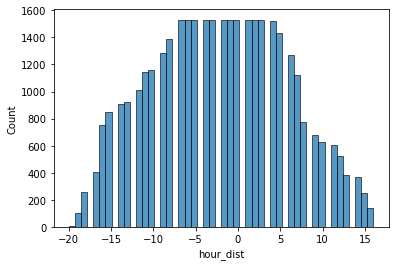

In [177]:
# удаление текущего часа от часа с максимальным потреблением
df_fe['hour_dist'] = df_fe['hour'] - df_fe['max_ec_hour']
sns.histplot(df_fe['hour_dist'])

Создадим немного фичей на временных рядах. Постараемся уложиться в 600 признаков.  
Чтобы не генерировать слишком много фичей, ограничимся функциями среднего и некоторыми преобразованиями.
Во временных рядах найдём:
- сдвиг на 1, 6 и 12 месяцев
- статистику за 3, 6, 12 предыдущих месяцев
- разницу между статистиками месяцев со сдвигом:   
    прошлый с позапрошлым,   
    прошлый со средним за последние 3 месяца,  
    прошлый со смещённым на 12 месяцев  

Так как у нас есть также временные ряды внутри дня, то группировать мы их будем по разному.  
Внутридневные признаки будем группировать по часовым внутри годов и месяцев и делать преобразования.  

In [178]:
work_with_month_hours = ['interval_12', 'interval_6', 'interval_4', 'hour']
month_hours_target = ['new_class', 'max_ec','rank_day','energy_consumption', # условные целевые переменные
       'ymds_energy_consumption_minmax', 'best_interval_flag', 'hour_dist',# условные целевые переменные
       'p1', 'p2', 'p4', # 'p3', 'p5', 'p6' признаки #
       'ymds_ymds_energy_consumption_minmax_rat_sum', # новые признаки
       'ymds_energy_consumption_minmax_day_shift_1',
       'ymds_energy_consumption_minmax_day_shift_-1',
       'ymds_ymds_energy_consumption_minmax_rat_sum_day_cumsum',
       'cumsum_day_ratio']

work_with_month_days = ['weekday']
month_days_target = ['energy_consumption','max_ec_hour', 'ymds_energy_consumption_minmax'] # 'p1','p2', 'p4', 

# также среднее по месяцу
month_target = ['max_ec_hour']

In [179]:
for interval in work_with_month_hours:
        new_feats = pd.DataFrame()
        for cols, pre_name in zip([
                ['year','month', interval, 'subject']],
                ['yms_' + interval]):

                for indx in df_fe.groupby([interval, 'subject']):
                        group = indx[0][0]
                        subject = indx[0][1]
                        
                        temp_df = df_fe[(df_fe[interval] == group) & (
                                        df_fe['subject'] == subject)
                                        ][cols + month_hours_target]

                        # создаём фичи
                        temp_df = make_time_series_feats(temp_df, temp_df.index, cols, month_hours_target, pre_name)
                        new_feats = pd.concat([new_feats, temp_df.drop(month_hours_target, axis = 1)])

        df_fe = pd.concat([df_fe, new_feats.sort_index().drop(cols, axis = 1)], axis = 1)

for interval in work_with_month_days:
        new_feats = pd.DataFrame()
        for cols, pre_name in zip([
                ['year','month', interval, 'subject']],
                ['yms_' + interval]):

                for indx in df_fe.groupby([interval, 'subject']):
                        group = indx[0][0]
                        subject = indx[0][1]
                        
                        temp_df = df_fe[(df_fe[interval] == group) & (
                                        df_fe['subject'] == subject)
                                        ][cols + month_days_target]
                        
                        # создаём фичи
                        temp_df = make_time_series_feats(temp_df, temp_df.index, cols, month_days_target, pre_name)
                        new_feats = pd.concat([new_feats, temp_df.drop(month_days_target, axis = 1)])

        df_fe = pd.concat([df_fe, new_feats.sort_index().drop(cols, axis = 1)], axis = 1)

new_feats = pd.DataFrame()
for cols, pre_name in zip([['year','month', 'subject'],], 
        ['ymonth_only']):
        for subject in df_fe['subject'].unique():
                
                temp_df = df_fe[df_fe['subject'] == subject
                                ][cols + month_target]

                # создаём фичи
                temp_df = make_time_series_feats(temp_df, temp_df.index, cols, month_target, pre_name)
                new_feats = pd.concat([new_feats, temp_df.drop(month_target, axis = 1)])

df_fe = pd.concat([df_fe, new_feats.sort_index().drop(cols, axis = 1)], axis = 1)

In [180]:
df_fe

date        p1        p2        p3       p4       p5  \
0     2019-09-04 00:00:00  2108.585  1925.165  1276.939   925.51   916.39   
1     2019-09-04 00:00:00  8048.975   477.945   391.531   896.61   870.14   
2     2019-09-04 01:00:00  2095.950  1753.115  1084.544   894.11   884.31   
3     2019-09-04 01:00:00  8023.158   386.711   592.522   894.45   867.82   
4     2019-09-04 02:00:00  2088.895  1558.524   877.092   878.75   867.91   
...                   ...       ...       ...       ...      ...      ...   
36715 2022-10-31 21:00:00  2200.384  1716.497  1915.647  1341.90  1315.29   
36716 2022-10-31 22:00:00  8648.255  1364.401   213.119  1006.81   972.51   
36717 2022-10-31 22:00:00  2135.249   933.732  1429.983  1154.63  1136.97   
36718 2022-10-31 23:00:00  2108.881   511.540   972.806  1034.74  1019.72   
36719 2022-10-31 23:00:00  8546.518   795.969   439.974   984.44   951.84   

              p6            subject  energy_consumption  year  ...  \
0       2404.885      Пермский край            2099.557  2019  ...   
1       9665.977  Тюменская область            8089.631  2019  ...   
2       2392.250      Пермский край            2105.597  2019  ...   
3       9640.160  Тюменская область            8081.073  2019  ...   
4       2385.195      Пермский край            2079.832  2019  ...   
...          ...                ...                 ...   ...  ...   
36715   2592.084      Пермский край            2185.941  2022  ...   
36716  10453.796  Тюменская область            8749.756  2022  ...   
36717   2526.949      Пермский край            2109.249  2022  ...   
36718   2498.581      Пермский край            2102.360  2022  ...   
36719  10351.941  Тюменская область            8668.574  2022  ...   

       yms_weekday_ymds_energy_consumption_minmax_mean_shift_1_diff_12  \
0                                                    NaN                 
1                                                    NaN                 
2                                                    NaN                 
3                                                    NaN                 
4                                                    NaN                 
...                                                  ...                 
36715                                           0.004636                 
36716                                          -0.020458                 
36717                                           0.004636                 
36718                                           0.004636                 
36719                                          -0.020458                 

       ymonth_only_max_ec_hour_shift_1_mean_3  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   
...                                       ...   
36715                               10.727681   
36716                               13.715854   
36717                               10.727681   
36718                               10.727681   
36719                               13.715854   

       ymonth_only_max_ec_hour_shift_1_mean_6  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   
...                                       ...   
36715                               10.546380   
36716                               13.265335   
36717                               10.546380   
36718                               10.546380   
36719                               13.265335   

      ymonth_only_max_ec_hour_shift_1_mean_12  \
0                                         NaN   
1                                         NaN   
2                                        

## LGBMClassifier(базовый + отбор признаков + гиперпараметры)

Выполним андерсемплинг, избавимся от пропусков.  
Попробуем решить задачу классификации и регрессии.  
Для классификации:  
Будем обучаться на три целевые перемеенны: max_ec, new_class, best_interval_flag.  
На лучшем результате будем осуществлять отбор признаков и подбор гиперпараметров по метрике Roc-auc.  

Для регрессии:  
Будем обучаться на три целевые перемеенны: ecergy_consumption, ymds_en ergy_consumption_minmax, rank_day.  
На лучшем результате будем осуществлять отбор признаков и подбор гиперпараметров по метрике Mae.  

In [181]:
df_fe_train = df_fe[df_fe['hour'].isin(np.arange(7, 21))]
df_fe_train = df_fe_train[~df_fe_train['ymonth_only_max_ec_hour_shift_12'].isna()].reset_index(drop = True)

In [182]:
# дополним данные фичами из прошлой модели
cols = ['hours4max_shift_year_flag',
       'hours4max2_shift_year_flag', 'hours4max3_shift_year_flag',
       'hours4max4_shift_year_flag', 
       'abs_dif_hour_hours4max2_shift_year',
       'abs_dif_hour_hours4max3_shift_year',
       'abs_dif_hour_hours4max4_shift_year']

df_fe_train = df_fe_train.merge(
    df_naive_logistic[cols + ['year','month', 'day', 'hour', 'subject']],
    on = ['year','month','day', 'hour', 'subject'])

In [183]:
# предобработаем категориальные признаки
df_fe_train_pre = pd.concat([
    df_fe_train,
    pd.get_dummies(
            data = df_fe_train[['year', 'month', 'day', 'hour', 'subject', 'weekday']], 
            columns = ['year', 'month', 'day', 'hour', 'subject', 'weekday'])], axis = 1).drop(['subject'], axis = 1)

In [184]:
# отбросим признаки, которые нам будут недоступны в момент предсказания

features = df_fe_train_pre.columns.drop([
    'best_interval_flag','hour_dist',
    'max_ec', 'max_ec_lim', 'max_ec_lim_hour', 'date_months', 
    'ec_interval_flag', 'new_class', 'max_ec_hour',  'date', #'date_months_le',
    'max_ep', 'max_ep_hour', 'max_ep_lim_hour', 'max_ep_lim',
    'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'energy_consumption', 'rank_day',
    'ymds_energy_consumption_minmax',
    'ymds_energy_consumption_minmax_day_sum',
    'ymds_ymds_energy_consumption_minmax_rat_sum',
    'ymds_energy_consumption_minmax_day_shift_1',
    'ymds_energy_consumption_minmax_day_shift_-1',
    'ymds_energy_consumption_minmax_around_sum',
    'ymds_energy_consumption_minmax_around_sum_ratio_day_sum',
    'ymds_ymds_energy_consumption_minmax_rat_sum_day_cumsum',
    'cumsum_day_ratio',
    ])
    
target = 'max_ec'

### Классификация. Валидация. Прогноз и оценка

In [185]:
X_train = df_fe_train_pre[features]

# выберем в трейн обе меткки, сравним
# y_train = df_fe_train_pre[target]

In [186]:
enc_ticks = LabelEncoder()

df_fe_train['date_months_le'] = enc_ticks.fit_transform(df_fe_train['date_months'])
time_series_ticks = df_fe_train['date_months_le']

# минимальная обучающая выборка = 12 месяцев,
# кросс валидация с 12го по 19ый
# тестирование с 19 по 25ый

# индексы для кросс валидации на временных рядах
val_cv_indices = time_series_cv_indices(
    df_fe_train, 
    time_series_ticks, 
    0, 19, 11)

# индексы для тестирования на временных рядах
test_cv_indices = time_series_cv_indices(
    df_fe_train, 
    time_series_ticks, 
    0, 25, 19)

#### Общий

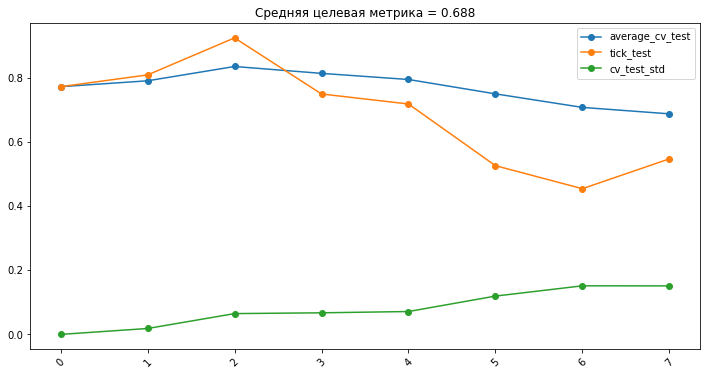

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.772727   0.772727     0.000000      0.865305            0.865305   
1         0.791126   0.809524     0.018398      0.913810            0.889558   
2         0.835750   0.925000     0.064872      0.928317            0.902478   
3         0.814313   0.750000     0.067343      0.825632            0.883266   
4         0.795200   0.718750     0.071338      0.891564            0.884926   
5         0.750386   0.526316     0.119509      0.829187            0.875636   
6         0.708123   0.454545     0.151523      0.890059            0.877696   
7         0.688060   0.547619     0.151350      0.892029            0.879488   

   tick_f1_score  average_cv_f1_score  
0       0.000000             0.000000  
1       0.230769             0.115385  
2       0.448276             0.226348  
3       0.043478             0.180631  
4       0.000000             0.144505  
5       0.093023             0.135924  
6       0.000000             0.116507  
7       0.000000             0.101943

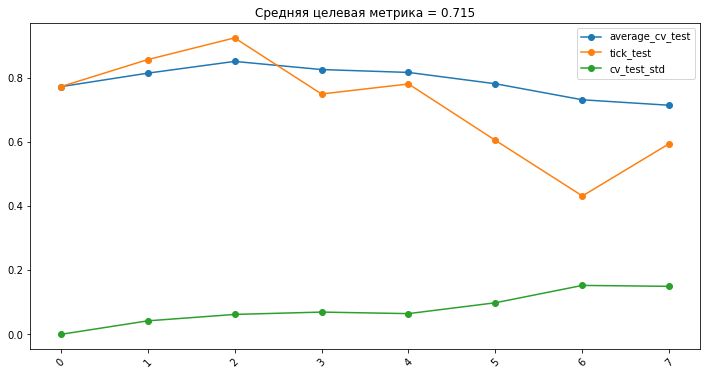

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.772727   0.772727     0.000000      0.845559            0.845559   
1         0.814935   0.857143     0.042208      0.918074            0.881816   
2         0.851623   0.925000     0.062287      0.935031            0.899555   
3         0.826218   0.750000     0.069614      0.834283            0.883237   
4         0.817224   0.781250     0.064811      0.860862            0.878762   
5         0.781897   0.605263     0.098693      0.808545            0.867059   
6         0.731886   0.431818     0.152825      0.766883            0.852748   
7         0.714805   0.595238     0.149928      0.880074            0.856164   

   tick_f1_score  average_cv_f1_score  
0       0.593640             0.593640  
1       0.736156             0.664898  
2       0.806452             0.712083  
3       0.638806             0.693763  
4       0.590000             0.673011  
5       0.514056             0.646518  
6       0.322581             0.600241  
7       0.607004             0.601087

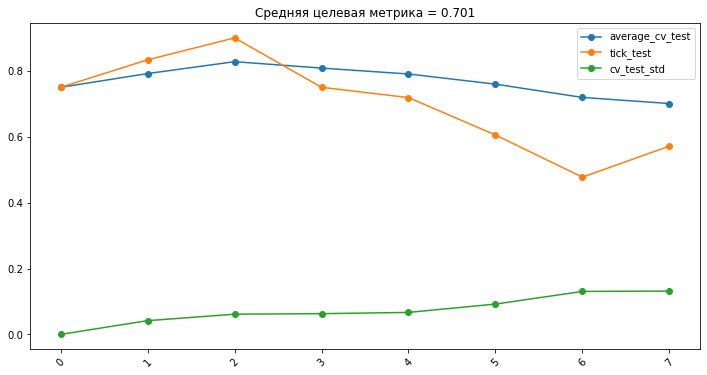

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.750000   0.750000     0.000000      0.770619            0.770619   
1         0.791667   0.833333     0.041667      0.873553            0.822086   
2         0.827778   0.900000     0.061363      0.884881            0.843018   
3         0.808333   0.750000     0.062915      0.717661            0.811679   
4         0.790417   0.718750     0.066714      0.811874            0.811718   
5         0.759558   0.605263     0.092034      0.764286            0.803812   
6         0.719231   0.477273     0.130451      0.786842            0.801388   
7         0.700756   0.571429     0.131452      0.866298            0.809502   

   tick_f1_score  average_cv_f1_score  
0       0.204768             0.204768  
1       0.511707             0.358238  
2       0.535504             0.417326  
3       0.331444             0.395856  
4       0.323167             0.381318  
5       0.365543             0.378689  
6       0.281518             0.364807  
7       0.276072             0.353716

In [187]:
model = LGBMClassifier(
    random_state = random_state)
data_frame = df_fe_train

for target in [
    'max_ec',
    'best_interval_flag',
    'new_class',
]:

    metric_table = time_series_cv_cl_scores(
        model, 
        val_cv_indices,
        X_train,
        features,
        target,
        data_frame,
        ['Тюменская область', 'Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_cv['_'.join(['LGBMClassifier', target])] = metric_table['tick_test']

max_ec


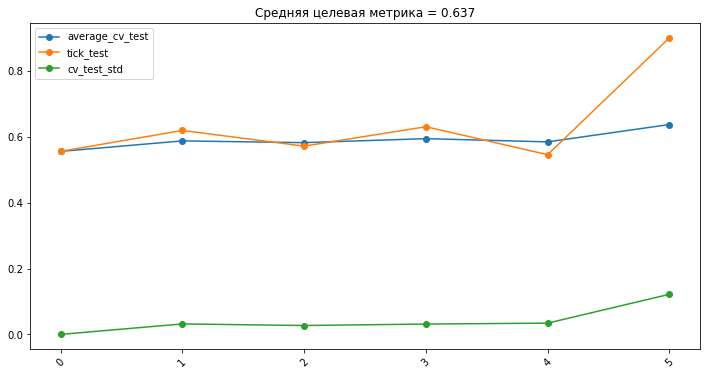

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.555556   0.555556     0.000000      0.789767            0.789767   
1         0.587302   0.619048     0.031746      0.757130            0.773449   
2         0.582011   0.571429     0.026979      0.796027            0.780975   
3         0.594117   0.630435     0.031394      0.795841            0.784691   
4         0.584384   0.545455     0.034166      0.848180            0.797389   
5         0.636987   0.900000     0.121688      0.893654            0.813433   

   tick_f1_score  average_cv_f1_score  
0       0.000000             0.000000  
1       0.040000             0.020000  
2       0.000000             0.013333  
3       0.000000             0.010000  
4       0.043478             0.016696  
5       0.291667             0.062524

best_interval_flag


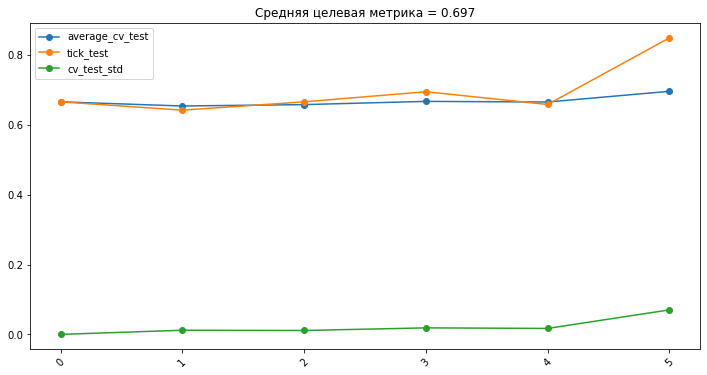

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.666667   0.666667     0.000000      0.848515            0.848515   
1         0.654762   0.642857     0.011905      0.754475            0.801495   
2         0.658730   0.666667     0.011224      0.832748            0.811913   
3         0.667961   0.695652     0.018711      0.822170            0.814477   
4         0.666187   0.659091     0.017107      0.872705            0.826123   
5         0.696822   0.850000     0.070261      0.939893            0.845085   

   tick_f1_score  average_cv_f1_score  
0       0.578947             0.578947  
1       0.577640             0.578294  
2       0.580645             0.579077  
3       0.578462             0.578923  
4       0.649819             0.593103  
5       0.746377             0.618648

new_class


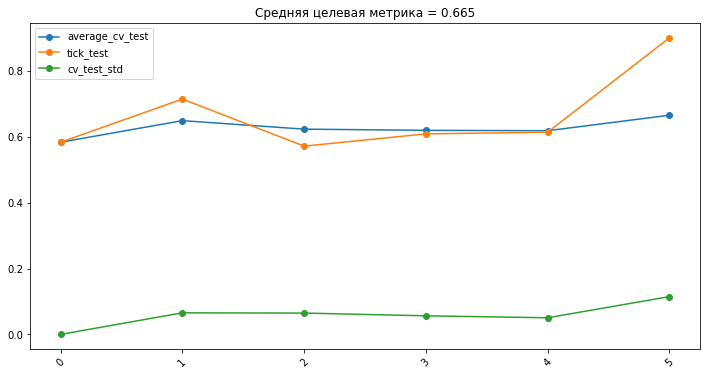

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.583333   0.583333     0.000000      0.784164            0.784164   
1         0.648810   0.714286     0.065476      0.735408            0.759786   
2         0.623016   0.571429     0.064720      0.774979            0.764850   
3         0.619436   0.608696     0.056391      0.727763            0.755578   
4         0.618276   0.613636     0.050491      0.820267            0.768516   
5         0.665230   0.900000     0.114664      0.902252            0.790805   

   tick_f1_score  average_cv_f1_score  
0       0.278263             0.278263  
1       0.285075             0.281669  
2       0.297756             0.287031  
3       0.294635             0.288932  
4       0.362531             0.303652  
5       0.647056             0.360886

In [188]:
model = LGBMClassifier(random_state = random_state)
data_frame = df_fe_train

for target in [
    'max_ec',
    'best_interval_flag',
    'new_class',
]:
    print (target)
    metric_table = time_series_cv_cl_scores(
        model, 
        test_cv_indices,
        X_train,
        features,
        target,
        data_frame,
        ['Тюменская область', 'Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test['_'.join(['LGBMClassifier', target])] = metric_table['tick_test']

#### Пермский край

max_ec


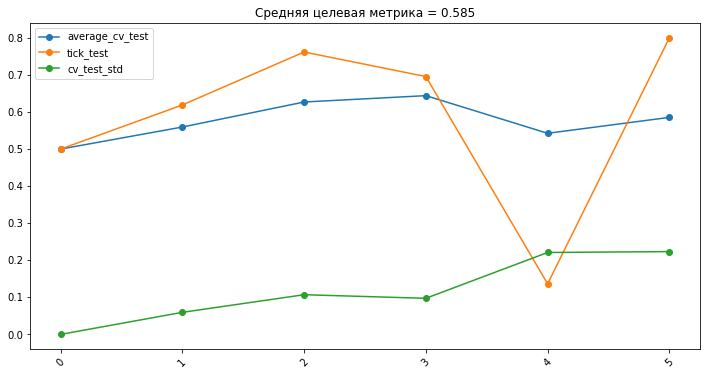

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.500000   0.500000     0.000000      0.746676            0.746676   
1         0.559524   0.619048     0.059524      0.812053            0.779365   
2         0.626984   0.761905     0.107069      0.871969            0.810233   
3         0.644151   0.695652     0.097376      0.770758            0.800364   
4         0.542594   0.136364     0.221001      0.711777            0.782647   
5         0.585495   0.800000     0.223391      0.739615            0.775475   

   tick_f1_score  average_cv_f1_score  
0       0.000000             0.000000  
1       0.071429             0.035714  
2       0.000000             0.023810  
3       0.000000             0.017857  
4       0.000000             0.014286  
5       0.000000             0.011905

best_interval_flag


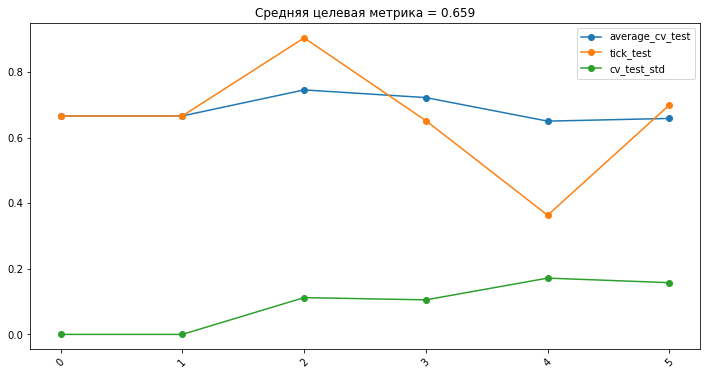

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.666667   0.666667     0.000000      0.878943            0.878943   
1         0.666667   0.666667     0.000000      0.845266            0.862105   
2         0.746032   0.904762     0.112239      0.944728            0.889646   
3         0.722567   0.652174     0.105356      0.854348            0.880821   
4         0.650781   0.363636     0.171735      0.672107            0.839079   
5         0.658984   0.700000     0.157842      0.818854            0.835708   

   tick_f1_score  average_cv_f1_score  
0       0.723404             0.723404  
1       0.638554             0.680979  
2       0.782609             0.714856  
3       0.670051             0.703654  
4       0.215686             0.606061  
5       0.465517             0.582637

new_class


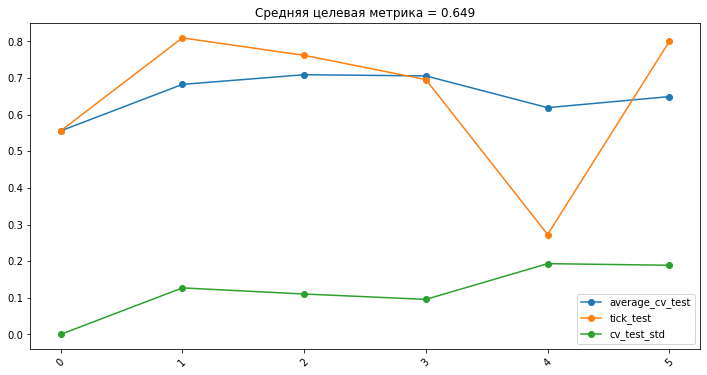

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.555556   0.555556     0.000000      0.787230            0.787230   
1         0.682540   0.809524     0.126984      0.772991            0.780111   
2         0.708995   0.761905     0.110226      0.848933            0.803052   
3         0.705659   0.695652     0.095633      0.724430            0.783396   
4         0.619073   0.272727     0.193146      0.640322            0.754781   
5         0.649227   0.800000     0.188770      0.743212            0.752853   

   tick_f1_score  average_cv_f1_score  
0       0.327410             0.327410  
1       0.295929             0.311670  
2       0.347732             0.323691  
3       0.320553             0.322906  
4       0.170534             0.292432  
5       0.261793             0.287325

In [189]:
model = LGBMClassifier(
    random_state = random_state)
data_frame = df_fe_train

for target in [
    'max_ec',
    'best_interval_flag',
    'new_class',
]:
    print (target)
    metric_table = time_series_cv_cl_scores(
        model, 
        test_cv_indices,
        X_train,
        features,
        target,
        data_frame,
        ['Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test_perm['_'.join(['LGBMClassifier', target])] = metric_table['tick_test']

#### Тюменская область

max_ec


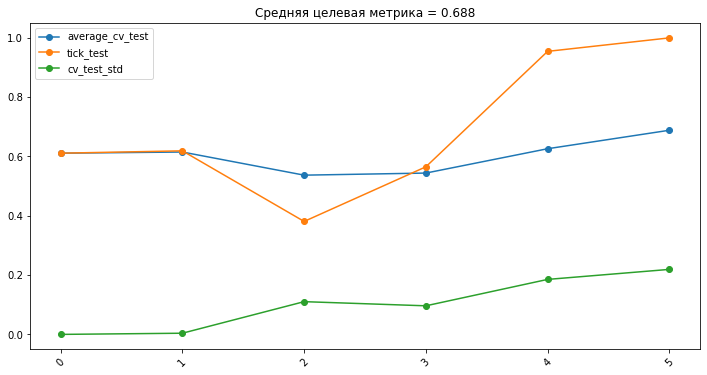

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.611111   0.611111     0.000000      0.849003            0.849003   
1         0.615079   0.619048     0.003968      0.678528            0.763765   
2         0.537037   0.380952     0.110416      0.688557            0.738696   
3         0.544082   0.565217     0.096399      0.848408            0.766124   
4         0.626175   0.954545     0.185448      0.948586            0.802616   
5         0.688479   1.000000     0.219245      0.976154            0.831539   

   tick_f1_score  average_cv_f1_score  
0       0.000000             0.000000  
1       0.000000             0.000000  
2       0.000000             0.000000  
3       0.000000             0.000000  
4       0.086957             0.017391  
5       0.500000             0.097826

best_interval_flag


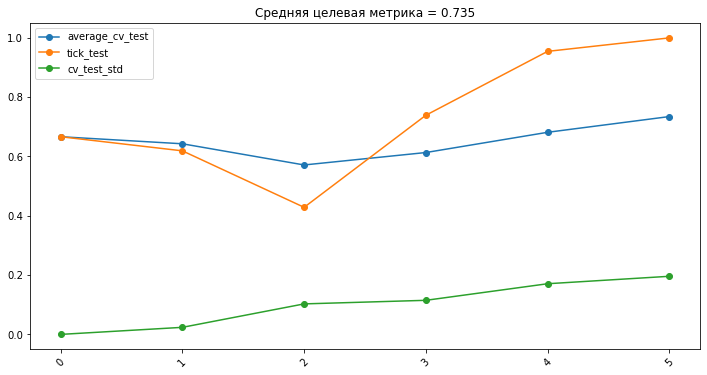

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.666667   0.666667     0.000000      0.836775            0.836775   
1         0.642857   0.619048     0.023810      0.678785            0.757780   
2         0.571429   0.428571     0.102869      0.675784            0.730448   
3         0.613354   0.739130     0.114934      0.806356            0.749425   
4         0.681592   0.954545     0.170861      0.968898            0.793320   
5         0.734660   1.000000     0.195982      0.994281            0.826813   

   tick_f1_score  average_cv_f1_score  
0       0.344828             0.344828  
1       0.512821             0.428824  
2       0.305085             0.387578  
3       0.437500             0.400058  
4       0.902857             0.500618  
5       0.950000             0.575515

new_class


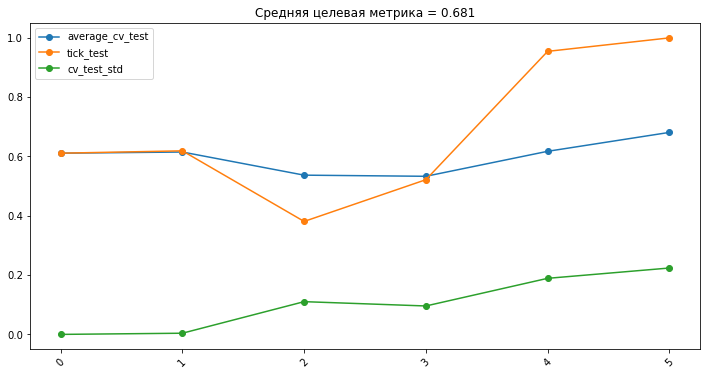

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.611111   0.611111     0.000000      0.773397            0.773397   
1         0.615079   0.619048     0.003968      0.684688            0.729043   
2         0.537037   0.380952     0.110416      0.675546            0.711211   
3         0.533213   0.521739     0.095852      0.737840            0.717868   
4         0.617479   0.954545     0.189086      0.920726            0.758439   
5         0.681233   1.000000     0.223869      0.981451            0.795608   

   tick_f1_score  average_cv_f1_score  
0       0.197233             0.197233  
1       0.269952             0.233593  
2       0.234264             0.233816  
3       0.253419             0.238717  
4       0.490032             0.288980  
5       0.846727             0.381938

In [190]:
model = LGBMClassifier(
    random_state = random_state)
data_frame = df_fe_train

for target in [
    'max_ec',
    'best_interval_flag',
    'new_class',
]:
    print (target)
    metric_table = time_series_cv_cl_scores(
        model, 
        test_cv_indices,
        X_train,
        features,
        target,
        data_frame,
        ['Тюменская область']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test_tyumen['_'.join(['LGBMClassifier', target])] = metric_table['tick_test']

### Отбор фичей для best_interval_flag. Предсказание

Отбирать будем по целевой переменной, которая показала себя наилучшим образом - best_interval_flag,  
а также потому что обучение на таргет с одним классом происходит быстрее.  
Отбирать фичи будем по метрике Roc-auc. Чем выше данная метрике, тем лучше происходит ранжирование вероятностей выпадения классов.  
Затем подберём гиперпараметры основываясь также на Roc-Auc.

In [191]:
# доля отбрасываемых признаков
step = 0.1

# количество итераций
ps = range(0, 40)

# таблицы для сбора метрики на трейне и тесте
metric_fs_train = pd.DataFrame()
metric_fs_test = pd.DataFrame()
# основной алгоритм

target = 'best_interval_flag'

In [192]:
cl = LGBMClassifier(
    n_jobs = -1,
    random_state=random_state,
    )

#алгоритмы для отбора фичей встроенным методом

lg_gain = LGBMClassifier(
    n_jobs = -1,
    random_state=random_state,
    importance_type = 'gain',
    )

rf = RandomForestClassifier(
    n_jobs = -1, 
    random_state=random_state,
    )

In [ ]:
lgbm_feats, metric_fs_train, metric_fs_test = cl_fs(
    cl, cl, X_train, df_fe_train[target], X_train.index, step, 
    ps, features, val_cv_indices, metric_fs_train, 
    metric_fs_test, 'roc_auc_ovr', 'lgbm'
    )

lgbm_gain_feats, metric_fs_train, metric_fs_test = cl_fs(
    cl, lg_gain, X_train, df_fe_train[target], X_train.index,
    step, ps, features, val_cv_indices, 
    metric_fs_train, metric_fs_test, 'roc_auc_ovr', 'lgbm_gain'
    )

rf_feats, metric_fs_train, metric_fs_test = cl_fs(
    cl, rf, X_train, df_fe_train[target], X_train.index,
    step, ps, features, val_cv_indices, 
    metric_fs_train, metric_fs_test, 'roc_auc_ovr', 'rf'
    )

In [194]:
metric_fs_test.iloc[np.where(metric_fs_test == metric_fs_test.max().max())]

24
lgbm  0.864893

In [195]:
metric_fs_test

0         1         2         3         4         5  \
lgbm       0.851468  0.855409  0.852977  0.854622  0.854023  0.851842   
lgbm_gain  0.851036  0.851557  0.857793  0.855369  0.846990  0.853634   
rf         0.851376  0.850366  0.851266  0.853044  0.846677  0.852695   

                  6         7         8         9  ...        30        31  \
lgbm       0.852296  0.851285  0.850000  0.851619  ...  0.856532  0.856347   
lgbm_gain  0.854088  0.856642  0.858282  0.853757  ...  0.855701  0.851534   
rf         0.852418  0.851710  0.855465  0.852653  ...  0.845945  0.845316   

                 32        33        34        35        36        37  \
lgbm       0.851197  0.853720  0.859690  0.861154  0.852818  0.857670   
lgbm_gain  0.853738  0.853783  0.853904  0.850576  0.852221  0.845917   
rf         0.846222  0.850155  0.852565  0.848366  0.847122  0.848151   

                 38        39  
lgbm       0.856073  0.857324  
lgbm_gain  0.853057  0.845700  
rf         0.845559  0.851337  

[3 rows x 40 columns]

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

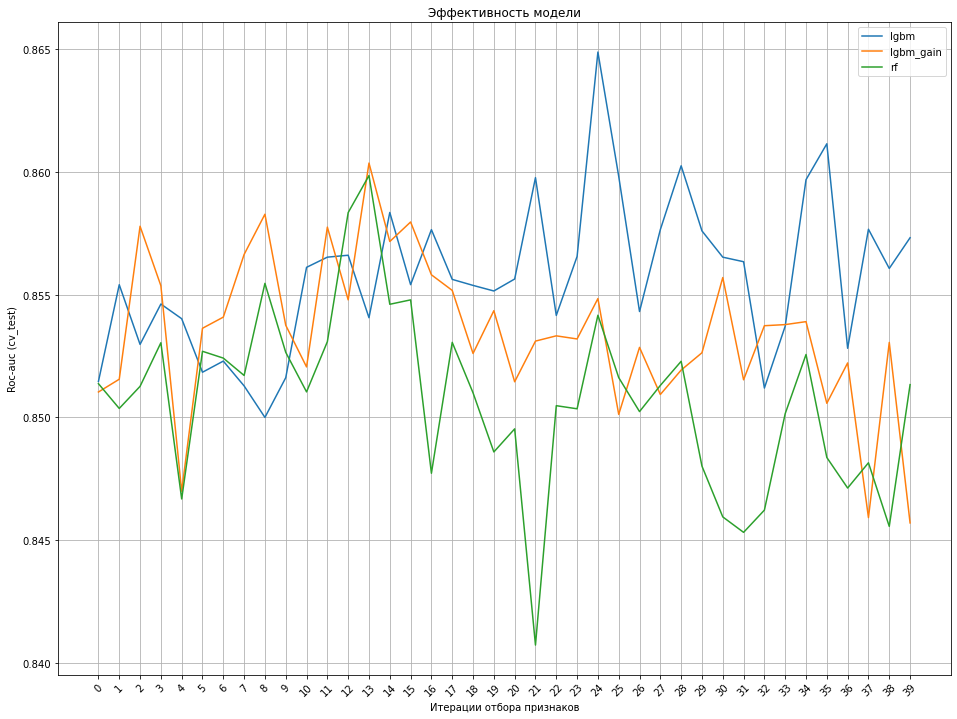

In [196]:
fig, ax = plt.subplots(figsize=(16, 12))
for i in metric_fs_test.index:
    ax.plot(metric_fs_test.columns, metric_fs_test.loc[i, :], label=i)
ax.legend()
plt.title("Эффективность модели")
ax.set_xlabel('Итерации отбора признаков')
ax.set_ylabel('Roc-auc (cv_test)')
ax.grid(True)
plt.xticks(metric_fs_test.columns, rotation = 45)
plt.show()

In [197]:
# у кривой lgbm_gain видно более плавный выход на пик с последующим снижением качества, 
# что может свидетельстовать о лучшем ранжировании признаков, поэтому отбираем признаки 13 итерации lgbm_gain
new_feats = lgbm_gain_feats[13]
new_feats

['yms_interval_12_ymds_ymds_energy_consumption_minmax_rat_sum_day_cumsum_mean_shift_1_diff_mean3',
 'yms_hour_energy_consumption_shift_1_mean_12',
 'yms_interval_4_ymds_energy_consumption_minmax_day_shift_-1_mean_shift_1_diff_2',
 'yms_hour_ymds_ymds_energy_consumption_minmax_rat_sum_day_cumsum_mean_shift_1_diff_12',
 'yms_interval_12_max_ec_shift_1_mean_6',
 'yms_interval_4_ymds_energy_consumption_minmax_shift_1',
 'yms_hour_ymds_energy_consumption_minmax_day_shift_-1_shift_12',
 'yms_hour_ymds_energy_consumption_minmax_day_shift_-1_shift_1',
 'yms_interval_12_ymds_ymds_energy_consumption_minmax_rat_sum_day_cumsum_shift_6',
 'yms_hour_new_class_mean_shift_1_diff_mean3',
 'yms_weekday_energy_consumption_shift_1_mean_12',
 'yms_hour_hour_dist_shift_1',
 'yms_interval_4_energy_consumption_shift_6',
 'yms_hour_ymds_energy_consumption_minmax_day_shift_1_shift_1_mean_6',
 'yms_interval_6_ymds_energy_consumption_minmax_day_shift_1_mean_shift_1_diff_mean3',
 'yms_hour_ymds_energy_consumption_

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

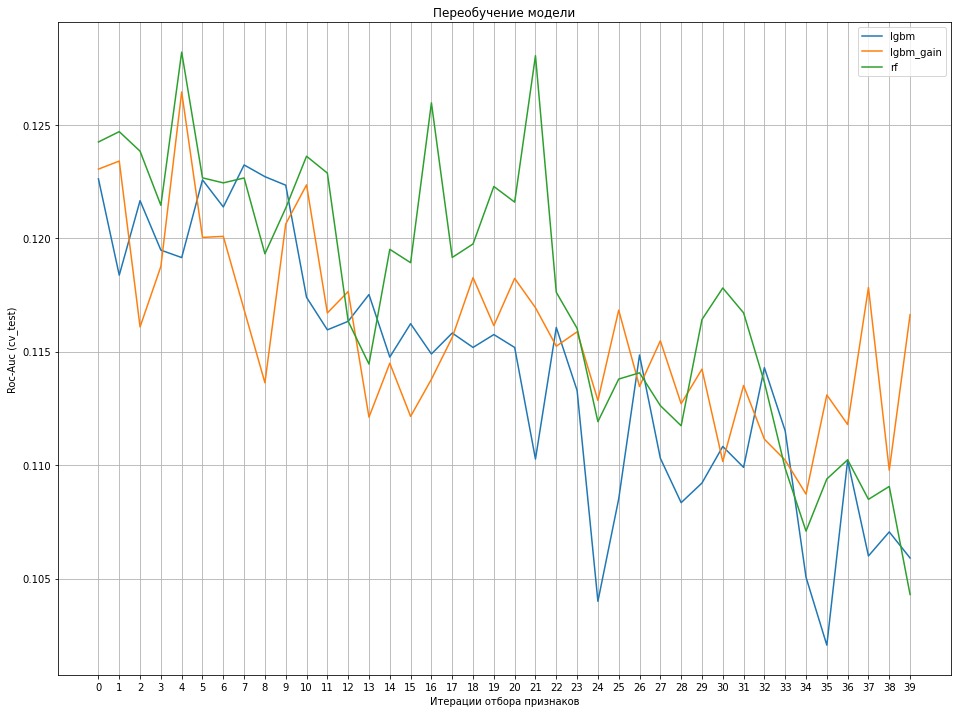

In [198]:
# кривые переобучения
metric_fs_dif = metric_fs_train - metric_fs_test
fig, ax = plt.subplots(figsize=(16, 12))
for i in metric_fs_dif.index:
    ax.plot(np.array(metric_fs_dif.columns), metric_fs_dif.loc[i, :], label=i)
ax.legend()
plt.title("Переобучение модели")
ax.set_xlabel('Итерации отбора признаков')
ax.set_ylabel('Roc-Auc (cv_test)')
ax.grid(True)
plt.show()

#### Оценка прогноза

best_interval_flag


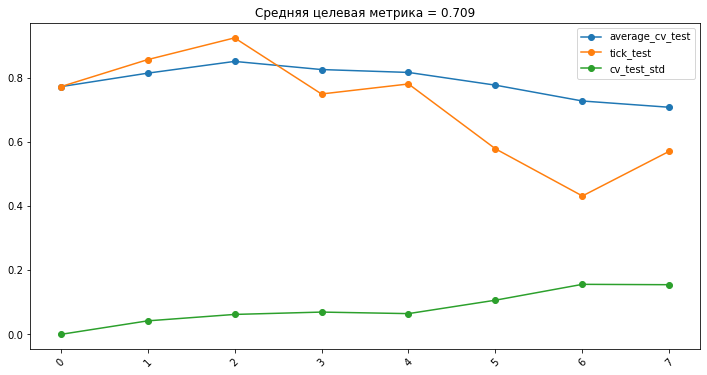

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.772727   0.772727     0.000000      0.865811            0.865811   
1         0.814935   0.857143     0.042208      0.918209            0.892010   
2         0.851623   0.925000     0.062287      0.948883            0.910968   
3         0.826218   0.750000     0.069614      0.821620            0.888631   
4         0.817224   0.781250     0.064811      0.867047            0.884314   
5         0.777511   0.578947     0.106705      0.820351            0.873654   
6         0.728127   0.431818     0.156181      0.755147            0.856724   
7         0.708539   0.571429     0.155013      0.885875            0.860368   

   tick_f1_score  average_cv_f1_score  
0       0.638298             0.638298  
1       0.741214             0.689756  
2       0.812903             0.730805  
3       0.629630             0.705511  
4       0.607843             0.685978  
5       0.489451             0.653223  
6       0.400000             0.617048  
7       0.666667             0.623251

In [199]:
model = LGBMClassifier(random_state = random_state)
data_frame = df_fe_train

for target in [
    'best_interval_flag',
]:
    print (target)
    metric_table = time_series_cv_cl_scores(
        model, 
        val_cv_indices,
        X_train,
        new_feats,
        target,
        data_frame,
        ['Тюменская область', 'Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_cv['_'.join(['LGBMClassifier_feature_selected', target])] = metric_table['tick_test']

best_interval_flag


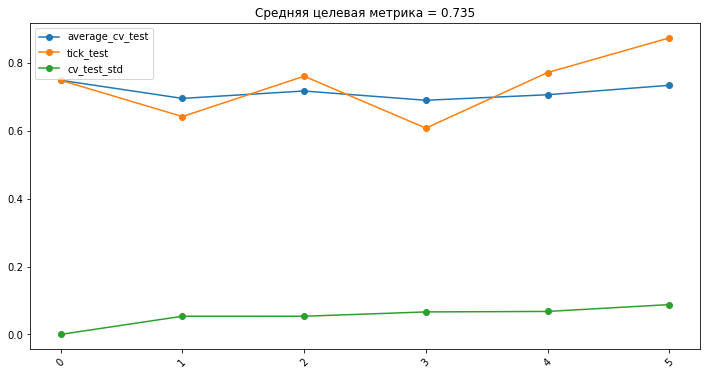

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.750000   0.750000     0.000000      0.855867            0.855867   
1         0.696429   0.642857     0.053571      0.764275            0.810071   
2         0.718254   0.761905     0.053535      0.825401            0.815181   
3         0.690864   0.608696     0.066333      0.825792            0.817834   
4         0.707237   0.772727     0.067766      0.898672            0.834001   
5         0.735197   0.875000     0.087954      0.937301            0.851218   

   tick_f1_score  average_cv_f1_score  
0       0.474227             0.474227  
1       0.524917             0.499572  
2       0.567474             0.522206  
3       0.572308             0.534731  
4       0.622222             0.552230  
5       0.751678             0.585471

In [200]:
model = LGBMClassifier(random_state = random_state)
data_frame = df_fe_train

for target in [
    'best_interval_flag',
]:
    print (target)
    metric_table = time_series_cv_cl_scores(
        model, 
        test_cv_indices,
        X_train,
        new_feats,
        target,
        data_frame,
        ['Тюменская область', 'Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test['_'.join(['LGBMClassifier_feature_selected', target])] = metric_table['tick_test']

best_interval_flag


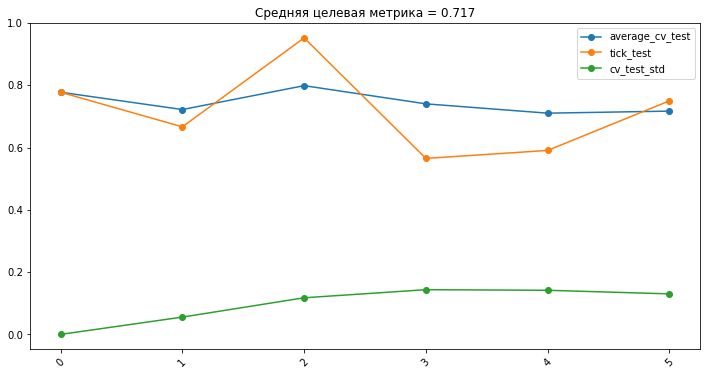

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.777778   0.777778     0.000000      0.880718            0.880718   
1         0.722222   0.666667     0.055556      0.841383            0.861051   
2         0.798942   0.952381     0.117598      0.932200            0.884767   
3         0.740511   0.565217     0.143578      0.861815            0.879029   
4         0.710590   0.590909     0.141678      0.745222            0.852268   
5         0.717159   0.750000     0.130165      0.817894            0.846539   

   tick_f1_score  average_cv_f1_score  
0       0.391753             0.391753  
1       0.528571             0.460162  
2       0.750000             0.556775  
3       0.666667             0.584248  
4       0.178218             0.503042  
5       0.521739             0.506158

In [201]:
model = LGBMClassifier(random_state = random_state)
data_frame = df_fe_train

for target in [
    'best_interval_flag',
]:
    print (target)
    metric_table = time_series_cv_cl_scores(
        model, 
        test_cv_indices,
        X_train,
        new_feats,
        target,
        data_frame,
        ['Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test_perm['_'.join(['LGBMClassifier_feature_selected', target])] = metric_table['tick_test']

best_interval_flag


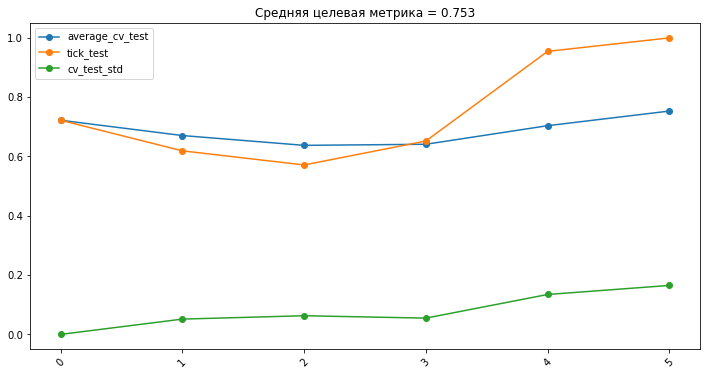

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.722222   0.722222     0.000000      0.818840            0.818840   
1         0.670635   0.619048     0.051587      0.689830            0.754335   
2         0.637566   0.571429     0.062939      0.678268            0.728979   
3         0.641218   0.652174     0.054872      0.829868            0.754201   
4         0.703884   0.954545     0.134598      0.979794            0.799320   
5         0.753236   1.000000     0.165153      0.992844            0.831574   

   tick_f1_score  average_cv_f1_score  
0       0.556701             0.556701  
1       0.521739             0.539220  
2       0.364964             0.481135  
3       0.419355             0.465690  
4       0.887574             0.550066  
5       0.950000             0.616722

In [202]:
model = LGBMClassifier(random_state = random_state)
data_frame = df_fe_train

for target in [
    'best_interval_flag',
]:
    print (target)
    metric_table = time_series_cv_cl_scores(
        model, 
        test_cv_indices,
        X_train,
        new_feats,
        target,
        data_frame,
        ['Тюменская область']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test_tyumen['_'.join(['LGBMClassifier_feature_selected', target])] = metric_table['tick_test']

### Подбор гиперпараметров. Предсказание

In [203]:
metric_table = pd.DataFrame()

i = 0
for max_depth in [4, 5, 6, 7, 8, 9, 10, -1]:
    for num_leaves in [24, 31, 37]:
                    cl = LGBMClassifier(
                        n_jobs = -1, 
                        max_depth = max_depth,
                        random_state = random_state,
                        num_leaves = num_leaves,
                        )
            
                    cv_res = cross_validate(
                        cl, X_train[new_feats], 
                        df_fe_train[target], 
                        scoring= 'roc_auc_ovr', 
                        n_jobs = -1, 
                        cv = val_cv_indices, 
                        return_train_score = True,
                         verbose = 0
                         )
                         
                    metric_table.loc[i, 'max_depth'] = max_depth
                    metric_table.loc[i, 'num_leaves'] = num_leaves
                    
                    metric_table.loc[i, 'cv_train'] = cv_res['train_score'].mean()
                    metric_table.loc[i, 'cv_test'] = cv_res['test_score'].mean()

                    # print (i)

                    i+= 1
            
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

In [204]:
metric_table.sort_values(by = 'cv_test', ascending = False)

max_depth  num_leaves  cv_train   cv_test    cv_dif
5         5.0        37.0  0.938267  0.862578  0.075689
19       10.0        31.0  0.971322  0.861848  0.109473
20       10.0        37.0  0.978174  0.861483  0.116691
0         4.0        24.0  0.910950  0.860769  0.050181
1         4.0        31.0  0.910950  0.860769  0.050181
2         4.0        37.0  0.910950  0.860769  0.050181
21       -1.0        24.0  0.959502  0.860622  0.098879
22       -1.0        31.0  0.972481  0.860368  0.112113
23       -1.0        37.0  0.980623  0.860311  0.120312
9         7.0        24.0  0.954022  0.859976  0.094046
13        8.0        31.0  0.968679  0.859211  0.109469
10        7.0        31.0  0.966354  0.859071  0.107283
18       10.0        24.0  0.958521  0.858438  0.100083
4         5.0        31.0  0.938720  0.858169  0.080550
8         6.0        37.0  0.959885  0.857971  0.101914
11        7.0        37.0  0.970733  0.857157  0.113577
12        8.0        24.0  0.955679  0.857099  0.098581
14        8.0        37.0  0.976659  0.856976  0.119683
15        9.0        24.0  0.957593  0.856918  0.100675
3         5.0        24.0  0.935519  0.856865  0.078653
7         6.0        31.0  0.957143  0.855390  0.101753
16        9.0        31.0  0.970880  0.855327  0.115552
17        9.0        37.0  0.978005  0.855076  0.122929
6         6.0        24.0  0.949460  0.853531  0.095929

best_interval_flag


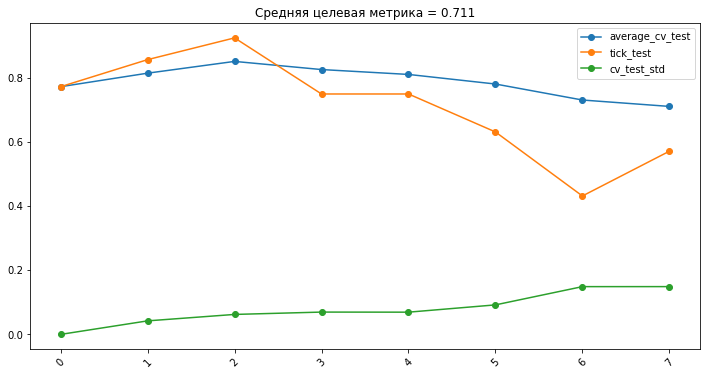

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.772727   0.772727     0.000000      0.867496            0.867496   
1         0.814935   0.857143     0.042208      0.912114            0.889805   
2         0.851623   0.925000     0.062287      0.940852            0.906821   
3         0.826218   0.750000     0.069614      0.829287            0.887437   
4         0.810974   0.750000     0.069328      0.877078            0.885365   
5         0.781075   0.631579     0.092060      0.814292            0.873520   
6         0.731181   0.431818     0.148999      0.765217            0.858048   
7         0.711212   0.571429     0.149054      0.894291            0.862578   

   tick_f1_score  average_cv_f1_score  
0       0.641379             0.641379  
1       0.754839             0.698109  
2       0.807818             0.734679  
3       0.621118             0.706288  
4       0.630542             0.691139  
5       0.514768             0.661744  
6       0.367347             0.619687  
7       0.693141             0.628869

In [205]:
model = LGBMClassifier(
    max_depth = 5,
    num_leaves = 37,
    random_state = random_state)
data_frame = df_fe_train

for target in [
    'best_interval_flag',
]:
    print (target)
    metric_table = time_series_cv_cl_scores(
        model, 
        val_cv_indices,
        X_train,
        new_feats,
        target,
        data_frame,
        ['Тюменская область', 'Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_cv['_'.join(['LGBMClassifier_feature_selected_hyperparams', target])] = metric_table['tick_test']

best_interval_flag


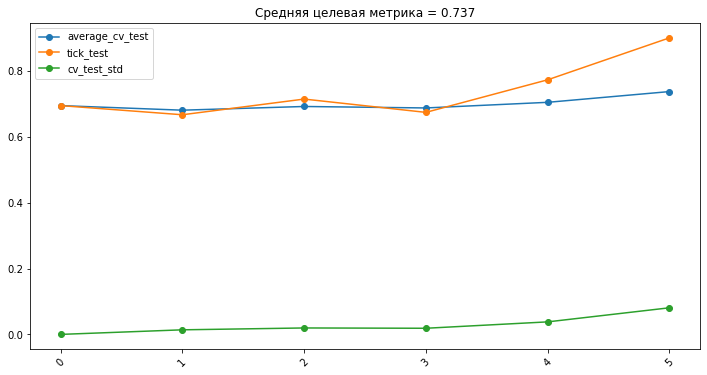

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.694444   0.694444     0.000000      0.878146            0.878146   
1         0.680556   0.666667     0.013889      0.767273            0.822710   
2         0.691799   0.714286     0.019530      0.820957            0.822125   
3         0.687327   0.673913     0.018603      0.813871            0.820062   
4         0.704407   0.772727     0.037997      0.914512            0.838952   
5         0.737006   0.900000     0.080725      0.940747            0.855918   

   tick_f1_score  average_cv_f1_score  
0       0.575472             0.575472  
1       0.580645             0.578058  
2       0.603774             0.586630  
3       0.488136             0.562007  
4       0.634686             0.576542  
5       0.785714             0.611404

In [206]:
model = LGBMClassifier(
    max_depth = 5,
    num_leaves = 37,
    random_state = random_state)
data_frame = df_fe_train

for target in [
    'best_interval_flag',
]:
    print (target)
    metric_table = time_series_cv_cl_scores(
        model, 
        test_cv_indices,
        X_train,
        new_feats,
        target,
        data_frame,
        ['Тюменская область', 'Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test['_'.join(['LGBMClassifier_feature_selected_hyperparams', target])] = metric_table['tick_test']

best_interval_flag


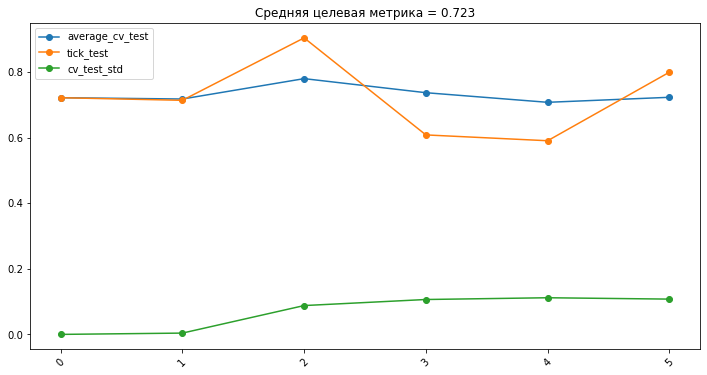

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.722222   0.722222     0.000000      0.897257            0.897257   
1         0.718254   0.714286     0.003968      0.854280            0.875769   
2         0.780423   0.904762     0.087980      0.931434            0.894324   
3         0.737491   0.608696     0.106465      0.852198            0.883792   
4         0.708175   0.590909     0.111829      0.778487            0.862731   
5         0.723479   0.800000     0.107669      0.829601            0.857209   

   tick_f1_score  average_cv_f1_score  
0       0.644628             0.644628  
1       0.602740             0.623684  
2       0.797688             0.681685  
3       0.634409             0.669866  
4       0.213592             0.578611  
5       0.608108             0.583527

In [207]:
model = LGBMClassifier(
    max_depth = 5,
    num_leaves = 37,
    random_state = random_state)
data_frame = df_fe_train

for target in [
    'best_interval_flag',
]:
    print (target)
    metric_table = time_series_cv_cl_scores(
        model, 
        test_cv_indices,
        X_train,
        new_feats,
        target,
        data_frame,
        ['Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test_perm['_'.join(['LGBMClassifier_feature_selected_hyperparams', target])] = metric_table['tick_test']

best_interval_flag


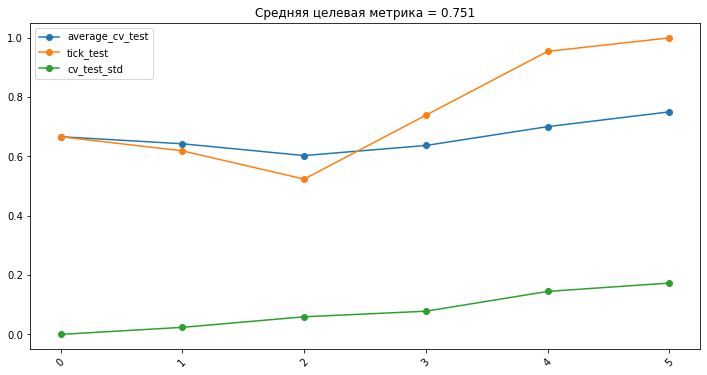

average_cv_test  tick_test  cv_test_std  tick_roc_auc  average_cv_roc_auc  \
0         0.666667   0.666667     0.000000      0.856273            0.856273   
1         0.642857   0.619048     0.023810      0.697279            0.776776   
2         0.603175   0.523810     0.059391      0.645949            0.733167   
3         0.637164   0.739130     0.078174      0.812027            0.752882   
4         0.700640   0.954545     0.144934      0.987414            0.799788   
5         0.750533   1.000000     0.173066      0.993406            0.832058   

   tick_f1_score  average_cv_f1_score  
0       0.483516             0.483516  
1       0.560976             0.522246  
2       0.372414             0.472302  
3       0.238532             0.413859  
4       0.892857             0.509659  
5       0.950000             0.583049

In [208]:
model = LGBMClassifier(
    max_depth = 5,
    num_leaves = 37,
    random_state = random_state)
data_frame = df_fe_train

for target in [
    'best_interval_flag',
]:
    print (target)
    metric_table = time_series_cv_cl_scores(
        model, 
        test_cv_indices,
        X_train,
        new_feats,
        target,
        data_frame,
        ['Тюменская область']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test_tyumen['_'.join(['LGBMClassifier_feature_selected_hyperparams', target])] = metric_table['tick_test']

### Регрессия. Валидация. Прогноз и оценка

In [209]:
X_train = df_fe_train_pre[features]

# выберем в трейн обе меткки, сравним
# y_train = df_fe_train_pre[target]

In [210]:
enc_ticks = LabelEncoder()

df_fe_train['date_months_le'] = enc_ticks.fit_transform(df_fe_train['date_months'])
time_series_ticks = df_fe_train['date_months_le']

# минимальная обучающая выборка = 12 месяцев,
# кросс валидация с 12го по 19ый
# тестирование с 19 по 25ый

# индексы для кросс валидации на временных рядах
val_cv_indices = time_series_cv_indices(
    df_fe_train, 
    time_series_ticks, 
    0, 19, 11)

# индексы для тестирования на временных рядах
test_cv_indices = time_series_cv_indices(
    df_fe_train, 
    time_series_ticks, 
    0, 25, 19)

#### Общий

energy_consumption


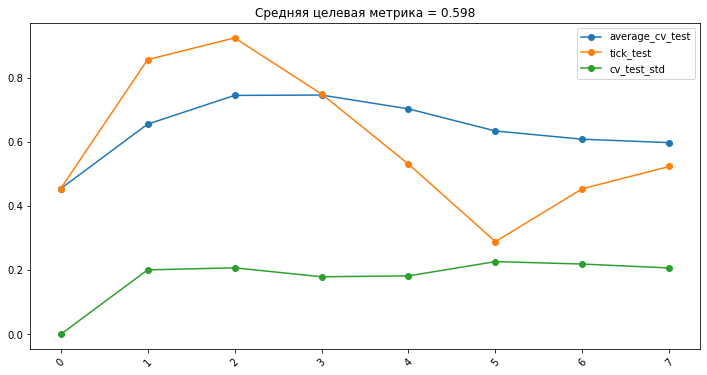

average_cv_test  tick_test  cv_test_std  cv_test_mae    cv_test_mse
0         0.454545   0.454545     0.000000   382.673715  268048.951675
1         0.655844   0.857143     0.201299   494.977687  429949.003877
2         0.745563   0.925000     0.207637   446.164993  353346.564804
3         0.746672   0.750000     0.179829   394.890670  289922.277025
4         0.703588   0.531250     0.182471   331.349824  233787.685963
5         0.634569   0.289474     0.227078   297.496069  199972.493046
6         0.608851   0.454545     0.219469   384.060269  359495.927019
7         0.598221   0.523810     0.207212   399.483572  372022.801846

rank_day


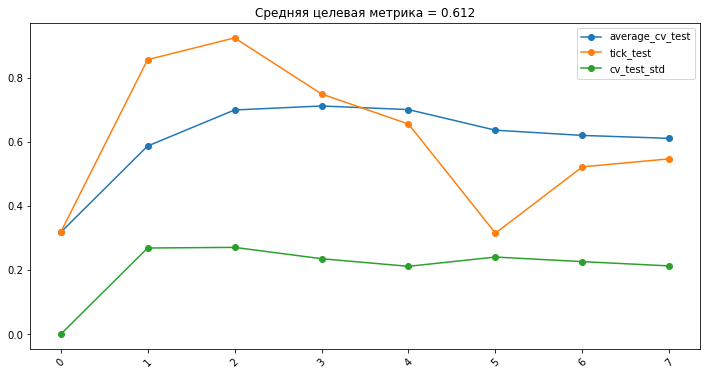

average_cv_test  tick_test  cv_test_std  cv_test_mae  cv_test_mse
0         0.318182   0.318182     0.000000     2.500962     9.557527
1         0.587662   0.857143     0.269481     2.403975     9.048380
2         0.700108   0.925000     0.271480     2.300284     8.453885
3         0.712581   0.750000     0.236099     2.344484     8.668758
4         0.701315   0.656250     0.212372     2.293875     8.241227
5         0.637061   0.315789     0.241305     2.283982     8.232098
6         0.620727   0.522727     0.226959     2.258746     8.023373
7         0.611589   0.547619     0.213673     2.280893     8.184732

ymds_energy_consumption_minmax


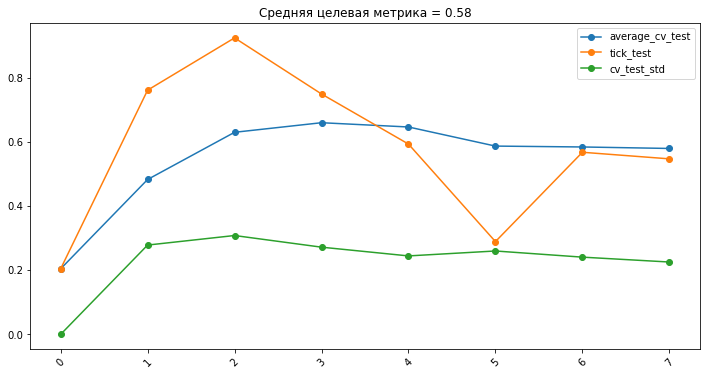

average_cv_test  tick_test  cv_test_std  cv_test_mae  cv_test_mse
0         0.204545   0.204545     0.000000     0.069529     0.007642
1         0.483225   0.761905     0.278680     0.065474     0.006821
2         0.630483   0.925000     0.308456     0.061687     0.006152
3         0.660363   0.750000     0.272097     0.059683     0.005797
4         0.647040   0.593750     0.244826     0.058574     0.005498
5         0.587446   0.289474     0.260206     0.058315     0.005467
6         0.584694   0.568182     0.240998     0.061966     0.006371
7         0.580059   0.547619     0.225766     0.063407     0.006668

In [211]:
model = LGBMRegressor(
    random_state = random_state)
data_frame = df_fe_train

for target in [
    'energy_consumption',
    'rank_day',
    'ymds_energy_consumption_minmax'
]:

    print (target)
    metric_table = time_series_cv_reg_scores(
        model, 
        val_cv_indices,
        X_train,
        features,
        target,
        data_frame,
        ['Тюменская область', 'Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_cv['_'.join(['LGBMRegressor', target])] = metric_table['tick_test']

energy_consumption


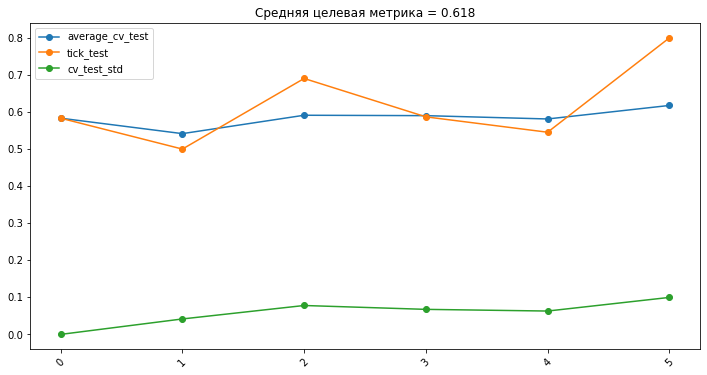

average_cv_test  tick_test  cv_test_std  cv_test_mae    cv_test_mse
0         0.583333   0.583333     0.000000   594.516611  637785.717124
1         0.541667   0.500000     0.041667   359.032590  328876.035728
2         0.591270   0.690476     0.077964   281.858799  228513.986402
3         0.590192   0.586957     0.067544   258.005190  185195.208598
4         0.581244   0.545455     0.063008   239.661917  158067.496817
5         0.617703   0.800000     0.099774   239.435318  151547.915369

rank_day


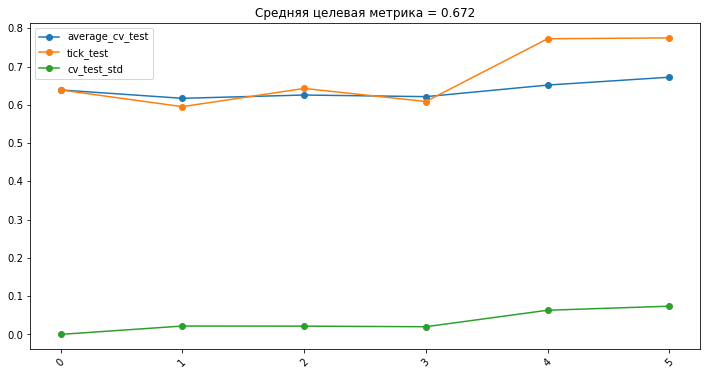

average_cv_test  tick_test  cv_test_std  cv_test_mae  cv_test_mse
0         0.638889   0.638889     0.000000     2.852957    12.093560
1         0.617063   0.595238     0.021825     2.824482    12.090710
2         0.625661   0.642857     0.021573     2.647428    10.719031
3         0.621420   0.608696     0.020076     2.645516    10.784421
4         0.651681   0.772727     0.063130     2.549059    10.176185
5         0.672235   0.775000     0.073711     2.440166     9.613158

ymds_energy_consumption_minmax


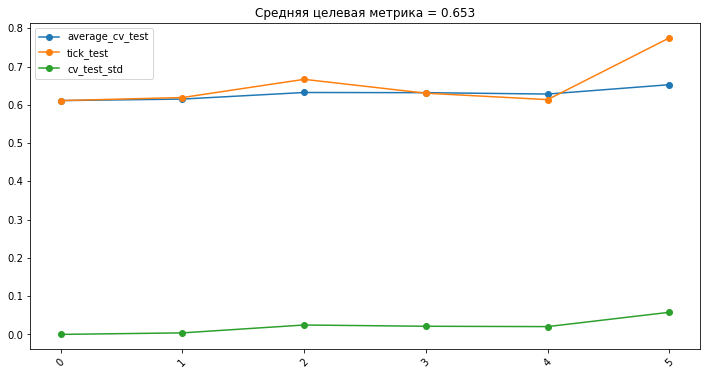

average_cv_test  tick_test  cv_test_std  cv_test_mae  cv_test_mse
0         0.611111   0.611111     0.000000     0.082646     0.012265
1         0.615079   0.619048     0.003968     0.075652     0.009870
2         0.632275   0.666667     0.024533     0.068014     0.008093
3         0.631815   0.630435     0.021261     0.067494     0.007786
4         0.628179   0.613636     0.020360     0.066425     0.007411
5         0.652649   0.775000     0.057787     0.065495     0.007180

In [212]:
model = LGBMRegressor(
    random_state = random_state)
data_frame = df_fe_train

for target in [
    'energy_consumption',
    'rank_day',
    'ymds_energy_consumption_minmax'
]:

    print (target)
    metric_table = time_series_cv_reg_scores(
        model, 
        test_cv_indices,
        X_train,
        features,
        target,
        data_frame,
        ['Тюменская область', 'Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test['_'.join(['LGBMRegressor', target])] = metric_table['tick_test']

#### Пермский край

energy_consumption


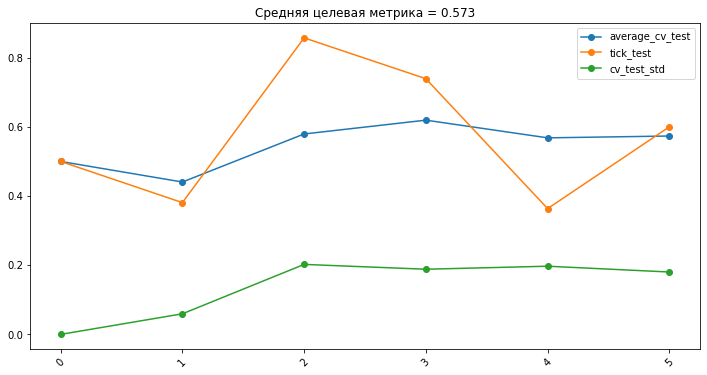

average_cv_test  tick_test  cv_test_std  cv_test_mae   cv_test_mse
0         0.500000   0.500000     0.000000    73.152255   9850.676603
1         0.440476   0.380952     0.059524    92.855994  12626.445740
2         0.579365   0.857143     0.202342    86.015045  11143.273908
3         0.619306   0.739130     0.188395    79.640124   9637.152853
4         0.568172   0.363636     0.197111    78.787073   9448.538313
5         0.573477   0.600000     0.180328    78.275634   9176.013832

rank_day


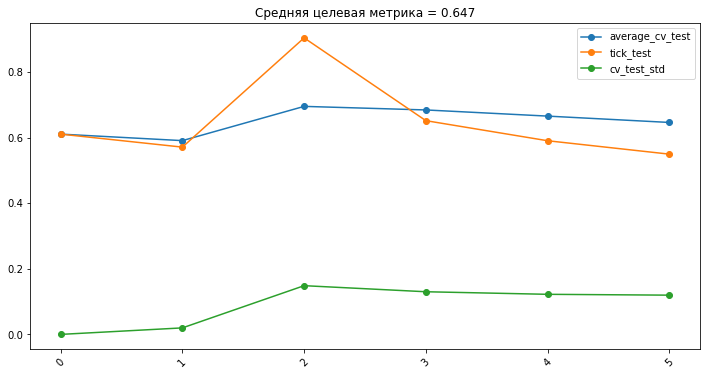

average_cv_test  tick_test  cv_test_std  cv_test_mae  cv_test_mse
0         0.611111   0.611111     0.000000     2.795067    11.512722
1         0.591270   0.571429     0.019841     2.612050    10.541511
2         0.695767   0.904762     0.148667     2.325367     8.661695
3         0.684869   0.652174     0.130126     2.323419     8.639722
4         0.666077   0.590909     0.122306     2.386145     9.073615
5         0.646731   0.550000     0.119737     2.393916     9.256346

ymds_energy_consumption_minmax


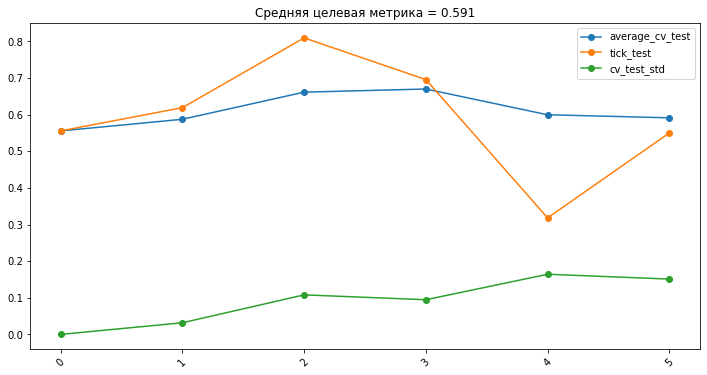

average_cv_test  tick_test  cv_test_std  cv_test_mae  cv_test_mse
0         0.555556   0.555556     0.000000     0.090979     0.015151
1         0.587302   0.619048     0.031746     0.078706     0.011079
2         0.661376   0.809524     0.107916     0.071048     0.009062
3         0.669945   0.695652     0.094629     0.071488     0.008876
4         0.599592   0.318182     0.164200     0.072019     0.008737
5         0.591327   0.550000     0.151029     0.072633     0.008710

In [213]:
model = LGBMRegressor(
    random_state = random_state)
data_frame = df_fe_train

for target in [
    'energy_consumption',
    'rank_day',
    'ymds_energy_consumption_minmax'
]:

    print (target)
    metric_table = time_series_cv_reg_scores(
        model, 
        test_cv_indices,
        X_train,
        features,
        target,
        data_frame,
        ['Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test_perm['_'.join(['LGBMRegressor', target])] = metric_table['tick_test']

#### Тюменская область

energy_consumption


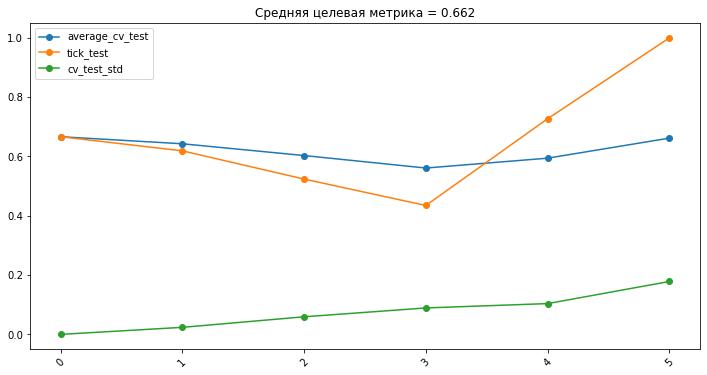

average_cv_test  tick_test  cv_test_std  cv_test_mae   cv_test_mse
0         0.666667   0.666667     0.000000  1115.880967  1.265721e+06
1         0.642857   0.619048     0.023810   625.209186  6.451256e+05
2         0.603175   0.523810     0.059391   477.702554  4.458847e+05
3         0.561077   0.434783     0.089231   436.370255  3.607533e+05
4         0.594316   0.727273     0.103871   400.536762  3.066865e+05
5         0.661930   1.000000     0.178464   400.595001  2.939198e+05

rank_day


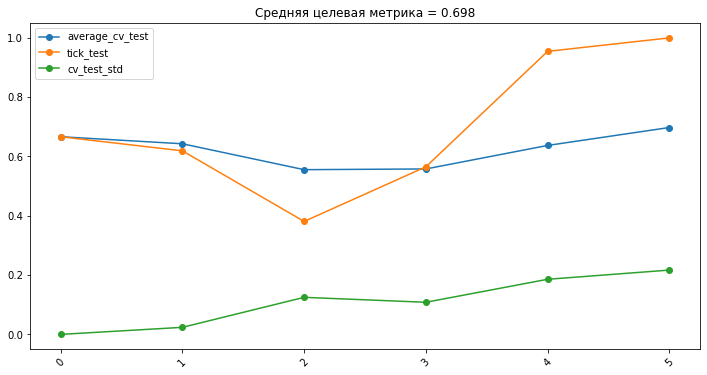

average_cv_test  tick_test  cv_test_std  cv_test_mae  cv_test_mse
0         0.666667   0.666667     0.000000     2.910847    12.674399
1         0.642857   0.619048     0.023810     3.036914    13.639908
2         0.555556   0.380952     0.124984     2.969488    12.776367
3         0.557971   0.565217     0.108320     2.967613    12.929119
4         0.637286   0.954545     0.185876     2.711973    11.278755
5         0.697738   1.000000     0.216943     2.486416     9.969971

ymds_energy_consumption_minmax


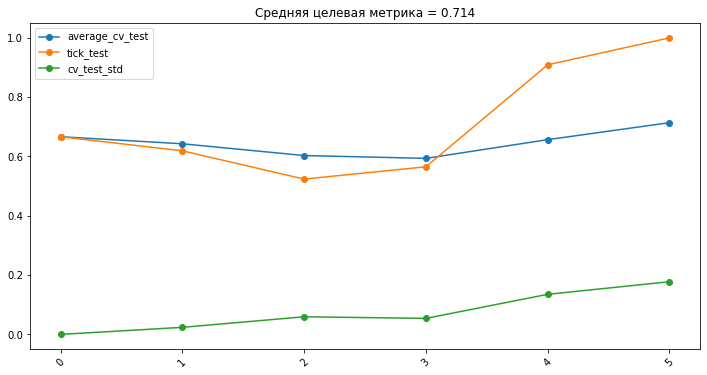

average_cv_test  tick_test  cv_test_std  cv_test_mae  cv_test_mse
0         0.666667   0.666667     0.000000     0.074312     0.009379
1         0.642857   0.619048     0.023810     0.072598     0.008661
2         0.603175   0.523810     0.059391     0.064980     0.007124
3         0.593685   0.565217     0.053997     0.063501     0.006696
4         0.656766   0.909091     0.135090     0.060832     0.006086
5         0.713972   1.000000     0.177680     0.058357     0.005649

In [214]:
model = LGBMRegressor(
    random_state = random_state)
data_frame = df_fe_train

for target in [
    'energy_consumption',
    'rank_day',
    'ymds_energy_consumption_minmax'
]:

    print (target)
    metric_table = time_series_cv_reg_scores(
        model, 
        test_cv_indices,
        X_train,
        features,
        target,
        data_frame,
        ['Тюменская область']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test_tyumen['_'.join(['LGBMRegressor', target])] = metric_table['tick_test']

### Отбор фичей для Rank day. Предсказание

In [215]:
# доля отбрасываемых признаков
step = 0.1

# количество итераций
ps = range(0, 40)

# таблицы для сбора метрики на трейне и тесте
metric_fs_train = pd.DataFrame()
metric_fs_test = pd.DataFrame()
# основной алгоритм

target = 'rank_day'

X_train = df_fe_train_pre[features]

# выберем в трейн обе меткки, сравним
y_train = df_fe_train_pre[[target]]

In [216]:
cl = LGBMRegressor(
    n_jobs = -1,
    random_state=random_state,
    )

#алгоритмы для отбора фичей встроенным методом

lg_gain = LGBMRegressor(
    n_jobs = -1,
    random_state=random_state,
    importance_type = 'gain',
    )

rf = RandomForestRegressor(
    n_jobs = -1, 
    random_state=random_state
    )

In [ ]:
lgbm_feats, metric_fs_train, metric_fs_test = cl_fs(
    cl, cl, X_train, y_train[target], X_train.index, step, 
    ps, features, val_cv_indices, metric_fs_train, 
    metric_fs_test, 'neg_mean_absolute_error', 'lgbm'
    )

lgbm_gain_feats, metric_fs_train, metric_fs_test = cl_fs(
    cl, lg_gain, X_train, y_train[target], X_train.index,
    step, ps, features, val_cv_indices, 
    metric_fs_train, metric_fs_test, 'neg_mean_absolute_error', 'lgbm_gain'
    )

rf_feats, metric_fs_train, metric_fs_test = cl_fs(
    cl, rf, X_train, y_train[target], X_train.index,
    step, ps, features, val_cv_indices, 
    metric_fs_train, metric_fs_test, 'neg_mean_absolute_error', 'rf'
    )

In [218]:
metric_fs_test.iloc[np.where(metric_fs_test == metric_fs_test.max().max())]

34
lgbm -2.235821

In [219]:
metric_fs_test

0         1         2         3         4         5  \
lgbm      -2.292347 -2.300702 -2.296637 -2.292760 -2.274479 -2.260722   
lgbm_gain -2.277532 -2.282341 -2.279323 -2.293655 -2.279944 -2.285279   
rf        -2.306623 -2.286052 -2.291684 -2.273157 -2.294960 -2.296456   

                  6         7         8         9  ...        30        31  \
lgbm      -2.279095 -2.284277 -2.299311 -2.307626  ... -2.259707 -2.256362   
lgbm_gain -2.270863 -2.269188 -2.263776 -2.278224  ... -2.275911 -2.305246   
rf        -2.295881 -2.295426 -2.287050 -2.269601  ... -2.273218 -2.257169   

                 32        33        34        35        36        37  \
lgbm      -2.245142 -2.235876 -2.235821 -2.239343 -2.258891 -2.248974   
lgbm_gain -2.288586 -2.279117 -2.271435 -2.277955 -2.283951 -2.265121   
rf        -2.250112 -2.258555 -2.263767 -2.251052 -2.262819 -2.279458   

                 38        39  
lgbm      -2.254675 -2.264559  
lgbm_gain -2.272747 -2.255923  
rf        -2.270828 -2.253804  

[3 rows x 40 columns]

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

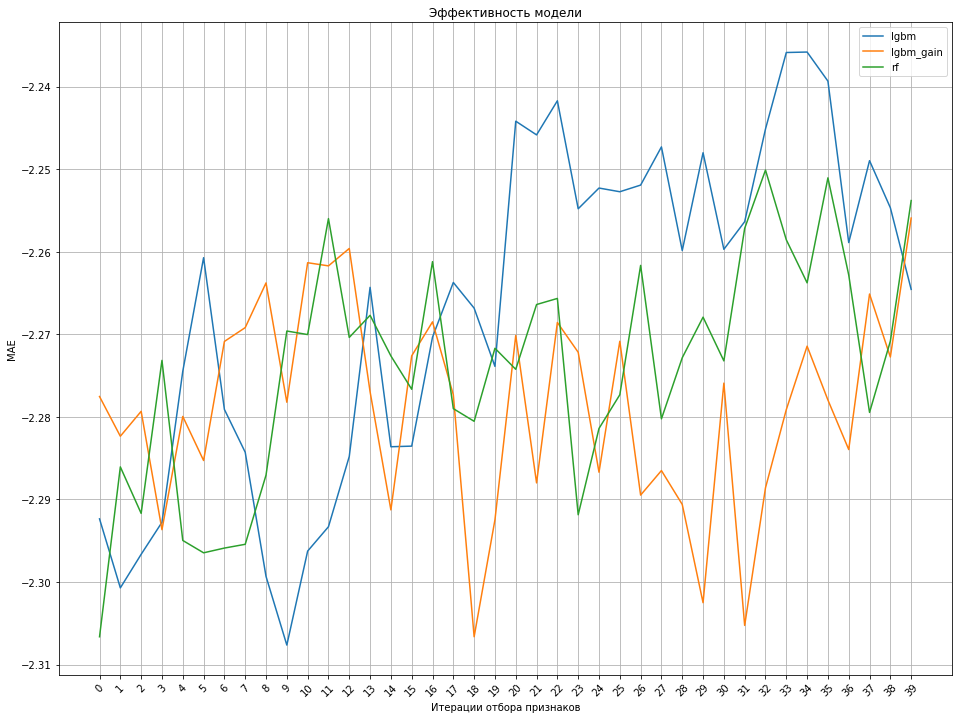

In [220]:
fig, ax = plt.subplots(figsize=(16, 12))
for i in metric_fs_test.index:
    ax.plot(metric_fs_test.columns, metric_fs_test.loc[i, :], label=i)
ax.legend()
plt.title("Эффективность модели")
ax.set_xlabel('Итерации отбора признаков')
ax.set_ylabel('MAE')
ax.grid(True)
plt.xticks(metric_fs_test.columns, rotation = 45)
plt.show()

In [221]:
# берём точку 22 lgbm, где есть небольшой перелом в тренде изменения метрики
new_feats = lgbm_feats[22]
new_feats

['yms_weekday_energy_consumption_mean_shift_1_diff_2',
 'yms_hour_ymds_energy_consumption_minmax_day_shift_-1_mean_shift_1_diff_2',
 'yms_hour_ymds_energy_consumption_minmax_day_shift_-1_shift_12',
 'yms_hour_max_ec_shift_1_mean_6',
 'yms_hour_best_interval_flag_mean_shift_1_diff_12',
 'yms_interval_6_ymds_ymds_energy_consumption_minmax_rat_sum_day_cumsum_shift_1_mean_12',
 'yms_hour_rank_day_mean_shift_1_diff_mean3',
 'yms_hour_ymds_energy_consumption_minmax_day_shift_-1_shift_1',
 'weekday',
 'yms_weekday_energy_consumption_mean_shift_1_diff_mean3',
 'yms_hour_ymds_ymds_energy_consumption_minmax_rat_sum_day_cumsum_shift_1_mean_12',
 'yms_hour_hour_dist_shift_12',
 'yms_hour_ymds_energy_consumption_minmax_shift_1_mean_12',
 'half_month',
 'yms_interval_4_p2_mean_shift_1_diff_mean3',
 'yms_hour_new_class_shift_1_mean_6',
 'yms_interval_6_ymds_ymds_energy_consumption_minmax_rat_sum_day_cumsum_shift_6',
 'yms_weekday_energy_consumption_shift_1_mean_12',
 'yms_hour_p2_mean_shift_1_diff_2'

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

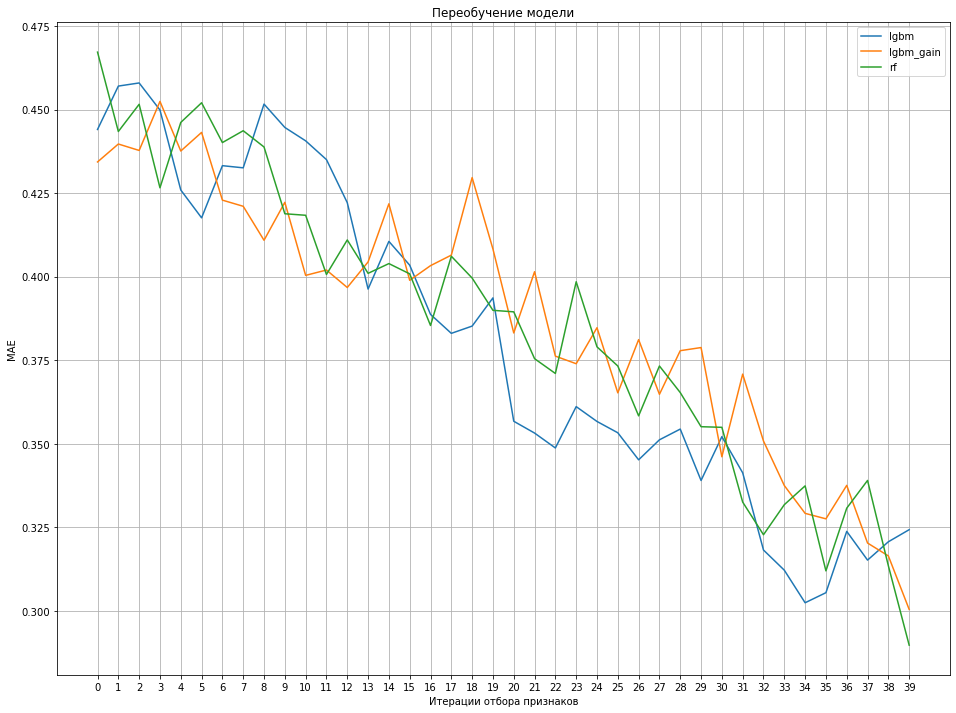

In [222]:
# кривые переобучения
metric_fs_dif = metric_fs_train - metric_fs_test
fig, ax = plt.subplots(figsize=(16, 12))
for i in metric_fs_dif.index:
    ax.plot(np.array(metric_fs_dif.columns), metric_fs_dif.loc[i, :], label=i)
ax.legend()
plt.title("Переобучение модели")
ax.set_xlabel('Итерации отбора признаков')
ax.set_ylabel('MAE')
ax.grid(True)
plt.show()

#### Оценка прогноза

rank_day


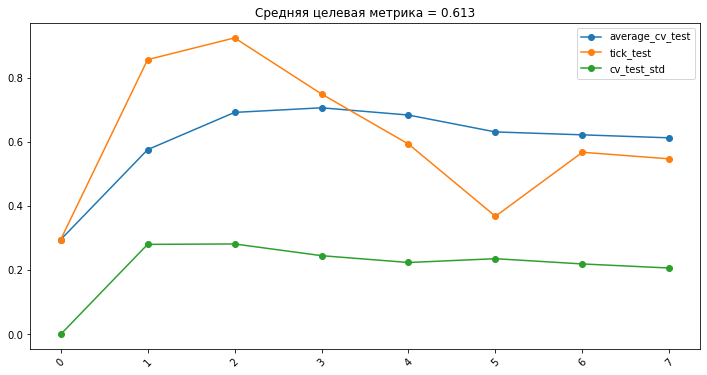

average_cv_test  tick_test  cv_test_std  cv_test_mae  cv_test_mse
0         0.295455   0.295455     0.000000     2.477800     9.408196
1         0.576299   0.857143     0.280844     2.342289     8.538178
2         0.692532   0.925000     0.282140     2.256028     8.035968
3         0.706899   0.750000     0.245604     2.300047     8.303516
4         0.684269   0.593750     0.224289     2.237026     7.852786
5         0.631628   0.368421     0.236171     2.230574     7.887442
6         0.622564   0.568182     0.219776     2.214491     7.752040
7         0.613196   0.547619     0.207071     2.241721     7.945885

In [223]:
model = LGBMRegressor(random_state = random_state)
data_frame = df_fe_train

for target in [
    'rank_day',
]:
    print (target)
    metric_table = time_series_cv_reg_scores(
        model, 
        val_cv_indices,
        X_train,
        new_feats,
        target,
        data_frame,
        ['Тюменская область', 'Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_cv['_'.join(['LGBMRegressor_feature_selected', target])] = metric_table['tick_test']

rank_day


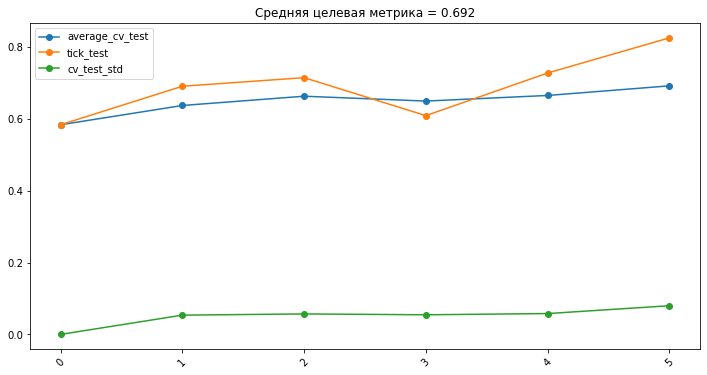

average_cv_test  tick_test  cv_test_std  cv_test_mae  cv_test_mse
0         0.583333   0.583333     0.000000     2.869413    12.108845
1         0.636905   0.690476     0.053571     2.787635    11.888145
2         0.662698   0.714286     0.056955     2.619152    10.594169
3         0.649198   0.608696     0.054587     2.626551    10.691247
4         0.664813   0.727273     0.057958     2.523516    10.066027
5         0.691511   0.825000     0.079769     2.416180     9.475912

In [224]:
model = LGBMRegressor(random_state = random_state)
data_frame = df_fe_train

for target in [
    'rank_day',
]:
    print (target)
    metric_table = time_series_cv_reg_scores(
        model, 
        test_cv_indices,
        X_train,
        new_feats,
        target,
        data_frame,
        ['Тюменская область', 'Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test['_'.join(['LGBMRegressor_feature_selected', target])] = metric_table['tick_test']

rank_day


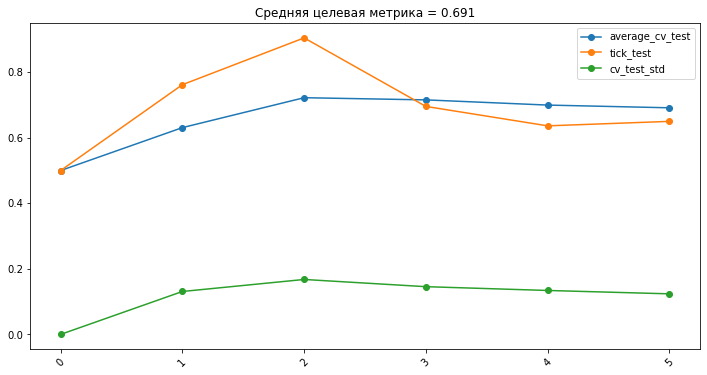

average_cv_test  tick_test  cv_test_std  cv_test_mae  cv_test_mse
0         0.500000   0.500000     0.000000     2.799571    11.628223
1         0.630952   0.761905     0.130952     2.525866    10.022037
2         0.722222   0.904762     0.167609     2.282261     8.446819
3         0.715580   0.695652     0.145609     2.293609     8.444678
4         0.699736   0.636364     0.134036     2.348269     8.860211
5         0.691447   0.650000     0.123753     2.358708     9.023684

In [225]:
model = LGBMRegressor(random_state = random_state)
data_frame = df_fe_train

for target in [
    'rank_day',
]:
    print (target)
    metric_table = time_series_cv_reg_scores(
        model, 
        test_cv_indices,
        X_train,
        new_feats,
        target,
        data_frame,
        ['Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test_perm['_'.join(['LGBMRegressor_feature_selected', target])] = metric_table['tick_test']

rank_day


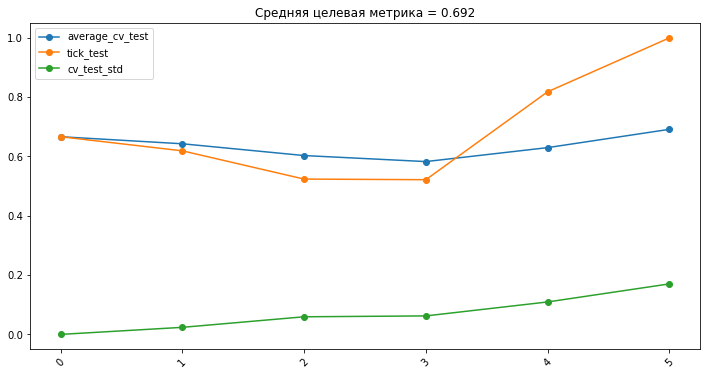

average_cv_test  tick_test  cv_test_std  cv_test_mae  cv_test_mse
0         0.666667   0.666667     0.000000     2.939254    12.589467
1         0.642857   0.619048     0.023810     3.049404    13.754254
2         0.603175   0.523810     0.059391     2.956044    12.741519
3         0.582816   0.521739     0.062361     2.959494    12.937816
4         0.629889   0.818182     0.109429     2.698762    11.271843
5         0.691574   1.000000     0.170306     2.473653     9.928140

In [226]:
model = LGBMRegressor(random_state = random_state)
data_frame = df_fe_train

for target in [
    'rank_day',
]:
    print (target)
    metric_table = time_series_cv_reg_scores(
        model, 
        test_cv_indices,
        X_train,
        new_feats,
        target,
        data_frame,
        ['Тюменская область']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test_tyumen['_'.join(['LGBMRegressor_feature_selected', target])] = metric_table['tick_test']

### Подбор гиперпараметров. Предсказание

In [227]:
metric_table = pd.DataFrame()

i = 0
for max_depth in [4, 5, 6, 7, 8, 9, 10, -1]:
    for num_leaves in [24, 31, 37]:
                    cl = LGBMRegressor(
                        n_jobs = -1, 
                        max_depth = max_depth,
                        random_state = random_state,
                        num_leaves = num_leaves,
                        )
            
                    cv_res = cross_validate(
                        cl, X_train[new_feats], 
                        df_fe_train[target], 
                        scoring= 'neg_mean_absolute_error', 
                        n_jobs = -1, 
                        cv = val_cv_indices, 
                        return_train_score = True,
                         verbose = 0
                         )
                         
                    metric_table.loc[i, 'max_depth'] = max_depth
                    metric_table.loc[i, 'num_leaves'] = num_leaves
                    
                    metric_table.loc[i, 'cv_train'] = cv_res['train_score'].mean()
                    metric_table.loc[i, 'cv_test'] = cv_res['test_score'].mean()

                    # print (i)

                    i+= 1
            
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

In [228]:
metric_table.sort_values(by = 'cv_test', ascending = False)

max_depth  num_leaves  cv_train   cv_test    cv_dif
6         6.0        24.0 -2.018439 -2.226411  0.207972
18       10.0        24.0 -1.972279 -2.226550  0.254271
8         6.0        37.0 -1.941319 -2.227436  0.286117
21       -1.0        24.0 -1.971836 -2.227682  0.255847
15        9.0        24.0 -1.977702 -2.228687  0.250985
9         7.0        24.0 -1.992563 -2.232225  0.239661
19       10.0        31.0 -1.895446 -2.234030  0.338584
11        7.0        37.0 -1.883161 -2.234330  0.351169
13        8.0        31.0 -1.911876 -2.235386  0.323511
0         4.0        24.0 -2.184239 -2.238443  0.054204
2         4.0        37.0 -2.184239 -2.238443  0.054204
1         4.0        31.0 -2.184239 -2.238443  0.054204
7         6.0        31.0 -1.964465 -2.239200  0.274736
12        8.0        24.0 -1.980733 -2.240353  0.259621
4         5.0        31.0 -2.061028 -2.240426  0.179398
5         5.0        37.0 -2.055491 -2.241502  0.186010
22       -1.0        31.0 -1.892990 -2.241721  0.348731
3         5.0        24.0 -2.073094 -2.242280  0.169186
17        9.0        37.0 -1.841187 -2.253347  0.412160
14        8.0        37.0 -1.855748 -2.254260  0.398512
16        9.0        31.0 -1.900815 -2.254984  0.354169
20       10.0        37.0 -1.831255 -2.261004  0.429748
23       -1.0        37.0 -1.822985 -2.272467  0.449482
10        7.0        31.0 -1.920688 -2.275037  0.354348

rank_day


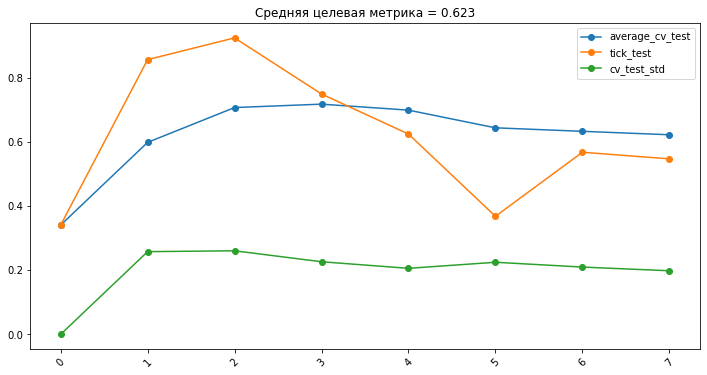

average_cv_test  tick_test  cv_test_std  cv_test_mae  cv_test_mse
0         0.340909   0.340909     0.000000     2.427523     8.989691
1         0.599026   0.857143     0.258117     2.329209     8.379341
2         0.707684   0.925000     0.260824     2.244593     7.959183
3         0.718263   0.750000     0.226622     2.288123     8.253914
4         0.699610   0.625000     0.206102     2.230633     7.813503
5         0.644412   0.368421     0.225017     2.221608     7.810337
6         0.633522   0.568182     0.210026     2.203949     7.682954
7         0.622784   0.547619     0.198505     2.226411     7.851186

In [229]:
model = LGBMRegressor(
    max_depth = 6,
    num_leaves = 24,
    random_state = random_state
    )
data_frame = df_fe_train

for target in [
    'rank_day',
]:
    print (target)
    metric_table = time_series_cv_reg_scores(
        model, 
        val_cv_indices,
        X_train,
        new_feats,
        target,
        data_frame,
        ['Тюменская область', 'Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_cv['_'.join(['LGBMRegressor_feature_selected_hyperparams', target])] = metric_table['tick_test']

rank_day


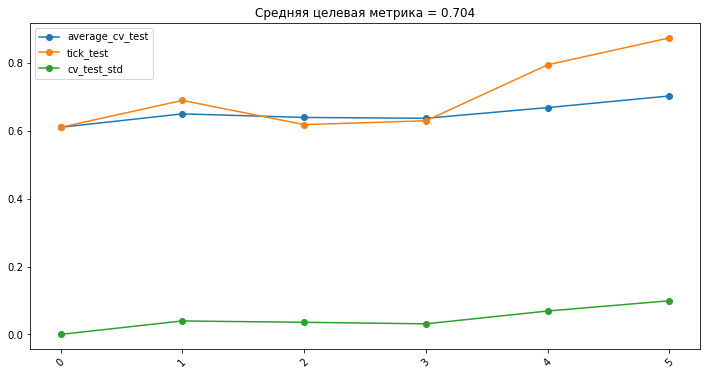

average_cv_test  tick_test  cv_test_std  cv_test_mae  cv_test_mse
0         0.611111   0.611111     0.000000     2.902017    12.290028
1         0.650794   0.690476     0.039683     2.799204    11.923521
2         0.640212   0.619048     0.035690     2.631251    10.608969
3         0.637767   0.630435     0.031197     2.644955    10.847393
4         0.669305   0.795455     0.068971     2.549366    10.254132
5         0.703587   0.875000     0.099200     2.433342     9.630718

In [230]:
model = LGBMRegressor(
    max_depth = 6,
    num_leaves = 24,
    random_state = random_state
    )
data_frame = df_fe_train

for target in [
    'rank_day',
]:
    print (target)
    metric_table = time_series_cv_reg_scores(
        model, 
        test_cv_indices,
        X_train,
        new_feats,
        target,
        data_frame,
        ['Тюменская область', 'Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test['_'.join(['LGBMRegressor_feature_selected_hyperparams', target])] = metric_table['tick_test']

rank_day


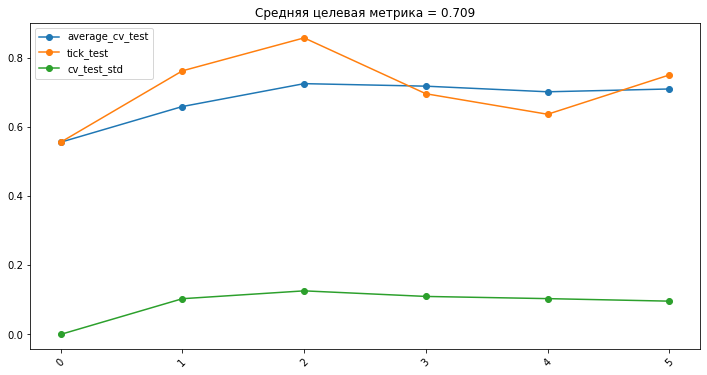

average_cv_test  tick_test  cv_test_std  cv_test_mae  cv_test_mse
0         0.555556   0.555556     0.000000     2.914441    12.510282
1         0.658730   0.761905     0.103175     2.582680    10.361261
2         0.724868   0.857143     0.125877     2.336732     8.723635
3         0.717564   0.695652     0.109744     2.326074     8.644442
4         0.701324   0.636364     0.103392     2.391647     9.138964
5         0.709436   0.750000     0.096111     2.389768     9.257644

In [231]:
model = LGBMRegressor(
    max_depth = 6,
    num_leaves = 24,
    random_state = random_state
    )
data_frame = df_fe_train

for target in [
    'rank_day',
]:
    print (target)
    metric_table = time_series_cv_reg_scores(
        model, 
        test_cv_indices,
        X_train,
        new_feats,
        target,
        data_frame,
        ['Пермский край']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test_perm['_'.join(['LGBMRegressor_feature_selected_hyperparams', target])] = metric_table['tick_test']

rank_day


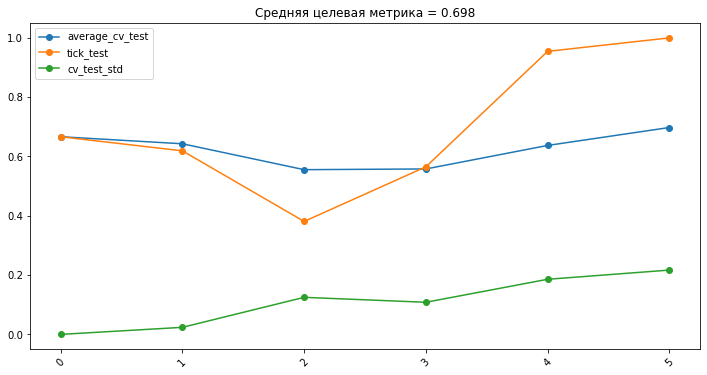

average_cv_test  tick_test  cv_test_std  cv_test_mae  cv_test_mse
0         0.666667   0.666667     0.000000     2.889592    12.069773
1         0.642857   0.619048     0.023810     3.015727    13.485781
2         0.555556   0.380952     0.124984     2.925770    12.494303
3         0.557971   0.565217     0.108320     2.963836    13.050344
4         0.637286   0.954545     0.185876     2.707084    11.369301
5         0.697738   1.000000     0.216943     2.476916    10.003791

In [232]:
model = LGBMRegressor(
    max_depth = 6,
    num_leaves = 24,
    random_state = random_state
    )
data_frame = df_fe_train

for target in [
    'rank_day',
]:
    print (target)
    metric_table = time_series_cv_reg_scores(
        model, 
        test_cv_indices,
        X_train,
        new_feats,
        target,
        data_frame,
        ['Тюменская область']
        )
        
    metric_visual(metric_table.iloc[:, :3])

    display(metric_table)
    results_test_tyumen['_'.join(['LGBMRegressor_feature_selected_hyperparams', target])] = metric_table['tick_test']

# Выгрузка итоговых таблиц

In [234]:
# вернём в индексы месяцы
cv_months = enc_ticks.classes_[12:20]
test_months = enc_ticks.classes_[20:26]

results_cv.index = cv_months
results_cv_perm.index = cv_months
results_cv_tyumen.index = cv_months

results_test.index = test_months
results_test_perm.index = test_months
results_test_tyumen.index = test_months

In [235]:
# csv
results_cv.to_csv('data/results_cv.csv')
results_cv_perm.to_csv('data/results_cv_perm.csv')
results_cv_tyumen.to_csv('data/results_cv_tyumen.csv')

results_test.to_csv('data/results_test.csv')
results_test_perm.to_csv('data/results_test_perm.csv')
results_test_tyumen.to_csv('data/results_test_tyumen.csv')

In [236]:
# excel
results_cv.to_excel('data/results_cv.xlsx')
results_cv_perm.to_excel('data/results_cv_perm.xlsx')
results_cv_tyumen.to_excel('data/results_cv_tyumen.xlsx')

results_test.to_excel('data/results_test.xlsx')
results_test_perm.to_excel('data/results_test_perm.xlsx')
results_test_tyumen.to_excel('data/results_test_tyumen.xlsx')

# Обзор результатов и выводы

Посмотрим бегло на среднюю метрику на:
- общей кросс-валидации
- общей тестовой выборке
- тестовой выобрке для Пермского края
- тестовой выборке для Тюменской области

In [237]:
results_cv.mean()

baseline                                                          0.681328
stat_model_1                                                      0.704474
stat_model_2                                                      0.662979
stat_model_3                                                      0.698565
LogisticRegression                                                0.687621
LGBMClassifier_max_ec                                             0.688060
LGBMClassifier_best_interval_flag                                 0.714805
LGBMClassifier_new_class                                          0.700756
LGBMClassifier_feature_selected_best_interval_flag                0.708539
LGBMClassifier_feature_selected_hyperparams_best_interval_flag    0.711212
LGBMRegressor_energy_consumption                                  0.643482
LGBMRegressor_rank_day                                            0.611153
LGBMRegressor_ymds_energy_consumption_minmax                      0.547232
LGBMRegressor_feature_sel

In [238]:
results_test.mean()

baseline                                                          0.605259
stat_model_1                                                      0.607329
stat_model_2                                                      0.611873
stat_model_3                                                      0.595537
LogisticRegression                                                0.663402
LGBMClassifier_max_ec                                             0.636987
LGBMClassifier_best_interval_flag                                 0.696822
LGBMClassifier_new_class                                          0.665230
LGBMClassifier_feature_selected_best_interval_flag                0.735197
LGBMClassifier_feature_selected_hyperparams_best_interval_flag    0.737006
LGBMRegressor_energy_consumption                                  0.617703
LGBMRegressor_rank_day                                            0.672235
LGBMRegressor_ymds_energy_consumption_minmax                      0.652649
LGBMRegressor_feature_sel

In [240]:
results_test_perm.mean()

baseline                                                          0.552462
stat_model_1                                                      0.485174
stat_model_2                                                      0.559076
stat_model_3                                                      0.451179
LogisticRegression                                                0.576272
LGBMClassifier_max_ec                                             0.585495
LGBMClassifier_best_interval_flag                                 0.658984
LGBMClassifier_new_class                                          0.649227
LGBMClassifier_feature_selected_best_interval_flag                0.717159
LGBMClassifier_feature_selected_hyperparams_best_interval_flag    0.723479
LGBMRegressor_energy_consumption                                  0.573477
LGBMRegressor_rank_day                                            0.646731
LGBMRegressor_ymds_energy_consumption_minmax                      0.591327
LGBMRegressor_feature_sel

In [241]:
results_test_tyumen.mean()

baseline                                                          0.658056
stat_model_1                                                      0.729484
stat_model_2                                                      0.664669
stat_model_3                                                      0.739894
LogisticRegression                                                0.750533
LGBMClassifier_max_ec                                             0.688479
LGBMClassifier_best_interval_flag                                 0.734660
LGBMClassifier_new_class                                          0.681233
LGBMClassifier_feature_selected_best_interval_flag                0.753236
LGBMClassifier_feature_selected_hyperparams_best_interval_flag    0.750533
LGBMRegressor_energy_consumption                                  0.661930
LGBMRegressor_rank_day                                            0.697738
LGBMRegressor_ymds_energy_consumption_minmax                      0.713972
LGBMRegressor_feature_sel

Предварительно можно сказать, что мы достигли существенного улучшения модели.   
Предварительно лучшей можно назвать модель классификации LGBMClassifier_feature_selected_hyperparams_best_interval_flag.  
Посмотрим на разницу по месяцам и на среднюю разницу метрик этой и эталонной базовой модели  

In [242]:
results_test['LGBMClassifier_feature_selected_hyperparams_best_interval_flag'] - results_test['baseline']

2022-05-01    0.055556
2022-06-01    0.095238
2022-07-01    0.166667
2022-08-01    0.043478
2022-09-01    0.204545
2022-10-01    0.225000
dtype: float64

In [243]:
(results_test['LGBMClassifier_feature_selected_hyperparams_best_interval_flag'] - results_test['baseline']).mean()

0.13174733881255618

В среднем модель показывает результат лучший на 13%.

Выводы  
Среди всех моделей своей эффективностью выделяются модели, которые решали задачу бинарной классификации целевой переменной best_interval_flag.  
Предполагаю, что т.к. наша основная метрика основана на поиске 4-х часового интервала и переменная best_interval_flag была рассчитана по приблизительно такому же принципу, то это дало прирост к качеству.  
По основной метрике лучшей является модель LGBMClassifier_feature_selected_hyperparams_best_interval_flag,  которая в среднем превышает эффективность эталонной на 13%. Для предсказаний модель использует ~150 отобранных признаков.  
Отбор признаков существенно увеличил метрику и уменьшил риск переобучения. Также для этой модели был проведён неглубокий подбор гиперпараметров. 
Переход от поиска единственного максимального часа max_ec  к мультиклассификации new_class увеличила эффективность модели, которая основана на бустинге.   
В задаче регрессии переход от прогнозирования абсолютных значений  energy_consumption к прогнозированию относительных внутридневных значений rank_day и  ymds_energy_consumption_minmax позволил увеличить эффективность модели.  
Несмотря на то, что регрессионные модели в данном кейсе выглядят слабее классификационных, можно заметить, что они показывают себя хуже на валидации, но имеют сравнительно высокую эффективность на тесте. Возможно, для раскрытия потенциала данных моделей необходимо провести дополнительный разведочный анализ, провести генерацию признаков, корректировку целевой переменной.  
Логистическая регрессия, которая объединяет преобразованные прогнозы статистических моделей, может использоваться как простой вариант предсказаний, который ощутимо превышает эффективность отдельно взятой эталонной и других рассмотренных статистических моделей.  
Модели, которые в среднем лучше эталонной модели в общем случае,  в среднем лучше проявляют себя и в отдельных регионах.   Драйверами роста эффективности моделей в данном кейсе стал поиск правильной целевой переменной, преобразование существующих признаков и генерация новых признаков на временных рядах.
